In [1]:
# !pip install perceval-quandela

In [2]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm

In [3]:
nphotons = 4
seed = 100
np.random.seed(seed)

In [4]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
del_0_v = -1/coefii
omega_0_v = 383.9911/coefii

In [5]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

# def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
#     return u_zegond+np.sin(x)
def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
    # print(len(u_zegond))
    # print(len(u_prime))
    # print(len(u))
    delta = u
    delta_prime = u_prime
    omega = delta_prime+ws
    omega_prime = u_zegond
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [6]:
# # Boundary condition (f(x_0)=f_0)
# x_0 = 0
# f_0 = np.sin(0)

In [7]:
# Differential equation's exact solution - for comparison
def u(x):
    return np.sin(x)

In [8]:
# Modeling parameters
n_grid = 50    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 1  # maximum of the interval on which we wish to approximate our function
X = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid

In [9]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# dx serves for the numerical differentiation of f
dx = (range_max-range_min) / (n_grid - 1)

In [10]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1>


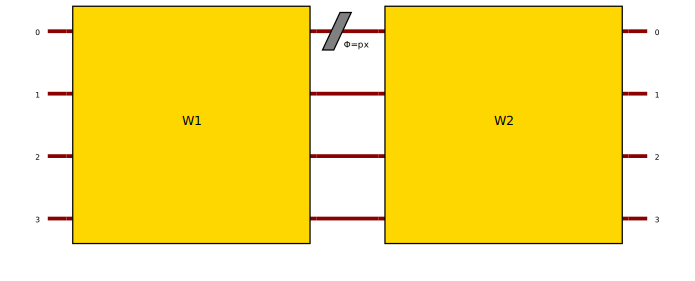

In [11]:
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=4*m**2)

px = pcvl.P("px")
c = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(px))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[2 * m ** 2:]), name="W2")

simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
s1 = simulator_backend(pcvl.Matrix.random_unitary(m))
s1.compile(input_state)

pcvl.pdisplay(c)

In [12]:
def computation(params):
    global current_loss
    global computation_count
    "compute the loss function of a given differential equation in order for it to be optimized"
    computation_count += 1

    loss_i = 0 

    delta_0 = None  # boundary condition
    omega_0 = None  # boundary condition

    coefs = lambda_random  # coefficients of the M observable
    # initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = pcvl.Matrix.random_unitary(m, params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, params[2 * m ** 2:])

    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    px.set_value(np.pi * 0)
    U = c.compute_unitary(use_symbolic=False)
    s1.U = U
    delta_0 = np.sum(np.multiply(s1.all_prob(input_state), coefs))
    



    # loss=0


    # Y[0] is before the domain we are interested in (used for differentiation), x_0 is at Y[1]
    Y = np.zeros(n_grid + 2)

    # x_0 is at the beginning of the domain, already calculated
    Y[1] = delta_0

    px.set_value(np.pi * (range_min - dx)/range_max)
    s1.U = c.compute_unitary(use_symbolic=False)
    Y[0] = np.sum(np.multiply(s1.all_prob(input_state), coefs))


    for i in range(1, n_grid):
        x = X[i]
        px.set_value(np.pi * x/range_max)
        s1.U = c.compute_unitary(use_symbolic=False)
        Y[i + 1] = np.sum(np.multiply(s1.all_prob(input_state), coefs))

    px.set_value(np.pi * (range_max + dx)/range_max)
    s1.U = c.compute_unitary(use_symbolic=False)
    Y[n_grid + 1] = np.sum(np.multiply(s1.all_prob(input_state), coefs))


    # Differentiation
    Y_prime = (Y[2:] - Y[:-2])/(2*dx)
    omega_0 = Y_prime[0]+ws

    Y_zegond = (Y_prime[2:] - Y_prime[:-2])/(2*dx)
    DE_err = np.sum((F(Y_zegond,Y_prime[1:-1], Y[2:-2], X[1:-1]))**2) 
    print('DE ERR:',DE_err)
    loss_i += DE_err
    
    # boundary condition given a weight eta
    loss_b = eta * (delta_0 - del_0_v) ** 2 * len(X)
    loss_b += eta * (omega_0 - omega_0_v) ** 2 * len(X)



    current_loss = (loss_i+loss_b) / len(X)
    return current_loss

In [13]:
a = [1,2,3,4,5,6,7,8]
print(a[2:])
print(a[:-2])
print(a[2:-2])


[3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6]
[3, 4, 5, 6]


In [14]:
def callbackF(parameters):
    """callback function called by scipy.optimize.minimize allowing to monitor progress"""
    global current_loss
    global computation_count
    global loss_evolution
    global start_time
    global best_param

    now = time.time()
    pbar.set_description("M= %d Loss: %0.5f #computations: %d elapsed: %0.5f" %
                         (m, current_loss, computation_count, now-start_time))
    pbar.update(1)
    loss_evolution.append((current_loss, now-start_time))
    computation_count = 0
    start_time = now
    best_param = parameters

In [15]:
computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []

pbar = tqdm.tqdm()
res = minimize(computation, parameters, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

0it [00:00, ?it/s]

DE ERR: 4366098.791757954
DE ERR: 4366098.68513936
DE ERR: 4366098.986357773
DE ERR: 4366098.68091714
DE ERR: 4366098.792819912
DE ERR: 4366099.024339011
DE ERR: 4366098.586764844
DE ERR: 4366098.866868756
DE ERR: 4366098.799907425
DE ERR: 4366098.482836188
DE ERR: 4366098.951084638
DE ERR: 4366098.823738564
DE ERR: 4366098.805676368
DE ERR: 4366099.162025412
DE ERR: 4366098.662643708
DE ERR: 4366098.585054625
DE ERR: 4366098.769103898
DE ERR: 4366099.024239044
DE ERR: 4366098.548495814
DE ERR: 4366098.643972618
DE ERR: 4366098.775226091
DE ERR: 4366098.668925836
DE ERR: 4366098.92471317
DE ERR: 4366098.785871845
DE ERR: 4366098.800341672
DE ERR: 4366098.847415137
DE ERR: 4366098.748277694
DE ERR: 4366098.644628571
DE ERR: 4366098.783327625
DE ERR: 4366099.475253478
DE ERR: 4366098.011880374
DE ERR: 4366098.7893628795
DE ERR: 4366098.787001135
DE ERR: 4366098.627459914
DE ERR: 4366098.766898198
DE ERR: 4366098.711212358
DE ERR: 4366098.791757941
DE ERR: 4366098.919712566
DE ERR: 436609

M= 4 Loss: 36119.67093 #computations: 260 elapsed: 5.68746: : 1it [00:05,  5.68s/it]

DE ERR: 1569876.2653675117
DE ERR: 1569876.2641784614
DE ERR: 1569876.3312321682
DE ERR: 1569876.224633589
DE ERR: 1569876.2774978592
DE ERR: 1569876.264178461
DE ERR: 1569876.3585053931
DE ERR: 1569876.2836425642
DE ERR: 1569876.237907547
DE ERR: 1569876.264178462
DE ERR: 1569876.177712686
DE ERR: 1569876.1697947118
DE ERR: 1569876.3020477428
DE ERR: 1569876.2641784586
DE ERR: 1569876.4208756578
DE ERR: 1569876.3425649686
DE ERR: 1569876.2177217866
DE ERR: 1569876.2641784558
DE ERR: 1569876.2448968631
DE ERR: 1569876.2857669378
DE ERR: 1569876.277226775
DE ERR: 1569876.2641784574
DE ERR: 10573871.434333593
DE ERR: 10573871.119653534
DE ERR: 10573871.811289143
DE ERR: 10573871.398741487
DE ERR: 10573871.42449998
DE ERR: 10573871.549214063
DE ERR: 10573871.104306607
DE ERR: 10573871.313429344
DE ERR: 10573871.45299105
DE ERR: 10573871.223040882
DE ERR: 10573871.322322138
DE ERR: 10573871.31911449
DE ERR: 10573871.49133582
DE ERR: 10573870.795554075
DE ERR: 10573872.011594094
DE ERR: 105

M= 4 Loss: 28357.29046 #computations: 130 elapsed: 2.85396: : 2it [00:08,  4.02s/it]

DE ERR: 1155226.329041935
DE ERR: 1155226.3101661275
DE ERR: 1155226.313303383
DE ERR: 661093.0514485999
DE ERR: 661093.0212527701
DE ERR: 661093.1326051716
DE ERR: 661093.0297078504
DE ERR: 661093.0515618603
DE ERR: 661093.0973454743
DE ERR: 661092.9624996472
DE ERR: 661093.0503111265
DE ERR: 661093.054552091
DE ERR: 661092.9686898593
DE ERR: 661093.0795874214
DE ERR: 661093.052498923
DE ERR: 661093.0581896872
DE ERR: 661093.055581066
DE ERR: 661093.0893660046
DE ERR: 661093.0142163523
DE ERR: 661093.0404142308
DE ERR: 661093.1163251596
DE ERR: 661093.0308840675
DE ERR: 661093.0230886532
DE ERR: 661093.0441885843
DE ERR: 661093.075038601
DE ERR: 661093.0824503246
DE ERR: 661093.0472168487
DE ERR: 661093.0557235874
DE ERR: 661093.0365011932
DE ERR: 661093.0627161583
DE ERR: 661093.0282937925
DE ERR: 661093.0472239656
DE ERR: 661093.2291434342
DE ERR: 661092.8427829568
DE ERR: 661093.0185510706
DE ERR: 661093.0492744187
DE ERR: 661093.0036784548
DE ERR: 661093.0794941895
DE ERR: 661093.

M= 4 Loss: 17887.53355 #computations: 65 elapsed: 1.37732: : 3it [00:09,  2.81s/it] 

DE ERR: 1555787.2578912033
DE ERR: 1555787.1136781084
DE ERR: 1555787.3938532872
DE ERR: 1555787.2624331194
DE ERR: 1555787.2568052516
DE ERR: 1555787.3679228039
DE ERR: 1555787.2067933187
DE ERR: 1555787.2296401893
DE ERR: 1555787.2626060545
DE ERR: 1555787.2134544956
DE ERR: 1555787.2878225797
DE ERR: 1555787.27959127
DE ERR: 1555787.2718135114
DE ERR: 1555787.163656459
DE ERR: 1555787.4229024812
DE ERR: 1555787.2225911205
DE ERR: 1555787.2349532205
DE ERR: 1555787.244750121
DE ERR: 1555787.298878396
DE ERR: 1555787.2204062094
DE ERR: 1555787.2438227911
DE ERR: 1555787.2028089985
DE ERR: 1555787.2727640737
DE ERR: 1555787.2613300034
DE ERR: 1555787.2660440244
DE ERR: 1555787.227684599
DE ERR: 1555787.3476742995
DE ERR: 1555787.2635402386
DE ERR: 1555787.24879037
DE ERR: 1555787.463690056
DE ERR: 1555787.1592174338
DE ERR: 1555787.150780272
DE ERR: 1555787.253571795
DE ERR: 1555787.17808333
DE ERR: 1555787.2614437605
DE ERR: 1555787.2705576336
DE ERR: 1555787.2578912023
DE ERR: 155578

M= 4 Loss: 14813.78029 #computations: 130 elapsed: 2.78882: : 4it [00:12,  2.80s/it]

DE ERR: 496531.69834181
DE ERR: 496531.69037272525
DE ERR: 496531.7011704142
DE ERR: 342047.4144377856
DE ERR: 342047.35906366596
DE ERR: 342047.480651225
DE ERR: 342047.4115468628
DE ERR: 342047.4143291642
DE ERR: 342047.4548359073
DE ERR: 342047.38440094073
DE ERR: 342047.4067068271
DE ERR: 342047.4161471962
DE ERR: 342047.3802297113
DE ERR: 342047.43082969316
DE ERR: 342047.42422810977
DE ERR: 342047.418674096
DE ERR: 342047.38186763437
DE ERR: 342047.4846582099
DE ERR: 342047.3897655696
DE ERR: 342047.40741015575
DE ERR: 342047.42161367927
DE ERR: 342047.4362542787
DE ERR: 342047.393400906
DE ERR: 342047.40997587057
DE ERR: 342047.40150323376
DE ERR: 342047.4326112907
DE ERR: 342047.41770504485
DE ERR: 342047.4171125141
DE ERR: 342047.38587981556
DE ERR: 342047.4374750365
DE ERR: 342047.407914522
DE ERR: 342047.41164061194
DE ERR: 342047.51439143845
DE ERR: 342047.37375360995
DE ERR: 342047.3733336197
DE ERR: 342047.4131068784
DE ERR: 342047.38135539787
DE ERR: 342047.42744126427
D

M= 4 Loss: 10849.06033 #computations: 65 elapsed: 1.43257: : 5it [00:14,  2.31s/it] 

DE ERR: 441804.6020564212
DE ERR: 441804.65510986757
DE ERR: 441804.49117364513
DE ERR: 441804.5949615697
DE ERR: 441804.6023202121
DE ERR: 441804.59611158725
DE ERR: 441804.69567461987
DE ERR: 441804.6273341456
DE ERR: 441804.59994274564
DE ERR: 441804.64528218785
DE ERR: 441804.591191959
DE ERR: 441804.59736171144
DE ERR: 441804.59632225684
DE ERR: 441804.77822324244
DE ERR: 441804.456852147
DE ERR: 441804.60836010915
DE ERR: 441804.61191528453
DE ERR: 441804.5588558552
DE ERR: 441804.57539059664
DE ERR: 441804.6177610611
DE ERR: 441804.60802723427
DE ERR: 441804.51527154644
DE ERR: 441804.6008584438
DE ERR: 441804.60372856504
DE ERR: 441804.59813729924
DE ERR: 441804.6586237439
DE ERR: 441804.54213202815
DE ERR: 441804.5918907733
DE ERR: 441804.6059795115
DE ERR: 441804.4550088139
DE ERR: 441804.7812380196
DE ERR: 441804.6769955
DE ERR: 441804.6038931023
DE ERR: 441804.5983349117
DE ERR: 441804.53112632135
DE ERR: 441804.6579836353
DE ERR: 441804.6020564279
DE ERR: 441804.6492348800

M= 4 Loss: 8591.36559 #computations: 130 elapsed: 2.78352: : 6it [00:16,  2.47s/it]

DE ERR: 128014.61679953906
DE ERR: 128014.63448515783
DE ERR: 128014.5735379525
DE ERR: 128014.61515868259
DE ERR: 128014.61680830044
DE ERR: 128014.60786683837
DE ERR: 128014.65244057597
DE ERR: 128014.622749696
DE ERR: 128014.61665315987
DE ERR: 128014.63610706644
DE ERR: 128014.60114108742
DE ERR: 128014.61487023116
DE ERR: 128014.61642416257
DE ERR: 128014.65782433818
DE ERR: 128014.58690391181
DE ERR: 128014.6195454899
DE ERR: 128014.61744394037
DE ERR: 128014.59760220692
DE ERR: 128014.61789424813
DE ERR: 128014.62173810626
DE ERR: 128014.61720920692
DE ERR: 128014.59468929657
DE ERR: 128014.6044426302
DE ERR: 128014.61725483651
DE ERR: 128014.61653800283
DE ERR: 128014.62516061103
DE ERR: 128014.60316363125
DE ERR: 128014.61460108739
DE ERR: 128014.61705673556
DE ERR: 128014.55832754294
DE ERR: 128014.69386357824
DE ERR: 128014.6359015805
DE ERR: 128014.61692899598
DE ERR: 128014.62358137494
DE ERR: 128014.59464715623
DE ERR: 128014.63506620553
DE ERR: 128014.61679953529
DE ERR:

M= 4 Loss: 7261.95234 #computations: 65 elapsed: 1.39102: : 7it [00:18,  2.12s/it] 

DE ERR: 122195.37779449025
DE ERR: 122195.35026196577
DE ERR: 122195.40881483059
DE ERR: 122195.39342503117
DE ERR: 122195.37765430161
DE ERR: 122195.36325063209
DE ERR: 122195.36321941577
DE ERR: 122195.36054672925
DE ERR: 122195.37927648248
DE ERR: 122195.38737888861
DE ERR: 122195.35462466467
DE ERR: 122195.3783214738
DE ERR: 122195.38130939844
DE ERR: 122195.26240961594
DE ERR: 122195.47196109056
DE ERR: 122195.39599581862
DE ERR: 122195.37162335668
DE ERR: 122195.35547867647
DE ERR: 122195.43279761336
DE ERR: 122195.38336381299
DE ERR: 122195.37366980841
DE ERR: 122195.41903931866
DE ERR: 122195.3599761617
DE ERR: 122195.37575495802
DE ERR: 122195.380243119
DE ERR: 122195.33789015017
DE ERR: 122195.42758838859
DE ERR: 122195.39756010745
DE ERR: 122195.3753942842
DE ERR: 122195.36530446842
DE ERR: 122195.39580516372
DE ERR: 122195.34373150565
DE ERR: 122195.37643400209
DE ERR: 122195.3906778493
DE ERR: 122195.40006591188
DE ERR: 122195.36819733301
DE ERR: 122195.37779448884
DE ERR:

M= 4 Loss: 6359.48806 #computations: 130 elapsed: 2.75648: : 8it [00:21,  2.32s/it]

DE ERR: 41779.72010318662
DE ERR: 41779.71744276081
DE ERR: 41779.72890277532
DE ERR: 41779.721941940224
DE ERR: 41779.720106218345
DE ERR: 41779.71585787911
DE ERR: 41779.71692042538
DE ERR: 41779.71926712811
DE ERR: 41779.72024384194
DE ERR: 41779.7142165596
DE ERR: 41779.722870645914
DE ERR: 41779.721340707954
DE ERR: 41779.72039130179
DE ERR: 41779.708891514965
DE ERR: 41779.7288839215
DE ERR: 41779.72044930706
DE ERR: 41779.71958191271
DE ERR: 41779.722940273896
DE ERR: 41779.725317047814
DE ERR: 41779.72003591242
DE ERR: 41779.7197421373
DE ERR: 41779.728056883345
DE ERR: 41779.72253869999
DE ERR: 41779.72102779502
DE ERR: 41779.72032388218
DE ERR: 41779.71460708319
DE ERR: 41779.72812339911
DE ERR: 41779.72141327654
DE ERR: 41779.71989822446
DE ERR: 41779.71956177757
DE ERR: 41779.71789408702
DE ERR: 41779.71796984527
DE ERR: 41779.71998187986
DE ERR: 41779.72078512967
DE ERR: 41779.72631902459
DE ERR: 41779.71538535513
DE ERR: 41779.72010319212
DE ERR: 41779.7136697711
DE ERR: 

M= 4 Loss: 5631.53840 #computations: 65 elapsed: 1.38342: : 9it [00:22,  2.03s/it] 

DE ERR: 41779.73277274881
DE ERR: 41779.72426042768
DE ERR: 41779.717586117695
DE ERR: 41779.720103190346
DE ERR: 74109.85137624861
DE ERR: 74109.89341753005
DE ERR: 74109.79243292942
DE ERR: 74109.85899697716
DE ERR: 74109.85124021169
DE ERR: 74109.79492445911
DE ERR: 74109.90867014148
DE ERR: 74109.85603412663
DE ERR: 74109.8493459979
DE ERR: 74109.8762077071
DE ERR: 74109.83240031156
DE ERR: 74109.84996938269
DE ERR: 74109.8475887319
DE ERR: 74109.86953188217
DE ERR: 74109.79475224073
DE ERR: 74109.87169536963
DE ERR: 74109.85839467253
DE ERR: 74109.82876271472
DE ERR: 74109.86686828354
DE ERR: 74109.87057931747
DE ERR: 74109.85632471944
DE ERR: 74109.86146613772
DE ERR: 74109.84697470651
DE ERR: 74109.8532683438
DE ERR: 74109.84840150652
DE ERR: 74109.83784898923
DE ERR: 74109.85206659013
DE ERR: 74109.8623879866
DE ERR: 74109.85414169879
DE ERR: 74109.71381322514
DE ERR: 74109.99708171707
DE ERR: 74109.8833681233
DE ERR: 74109.85307198469
DE ERR: 74109.86996567632
DE ERR: 74109.84

M= 4 Loss: 5220.88452 #computations: 65 elapsed: 1.39230: : 10it [00:23,  1.83s/it]

DE ERR: 74109.84231861429
DE ERR: 74109.85137624711
DE ERR: 74109.82989587082
DE ERR: 74109.8588403374
DE ERR: 74109.85521169272
DE ERR: 74109.85137624701
DE ERR: 77430.87454499924
DE ERR: 77430.9254080631
DE ERR: 77430.80380794623
DE ERR: 77430.87447905864
DE ERR: 77430.87440130087
DE ERR: 77430.83222314151
DE ERR: 77430.92307863595
DE ERR: 77430.88199178572
DE ERR: 77430.87267807953
DE ERR: 77430.90172452325
DE ERR: 77430.85320875485
DE ERR: 77430.87038810417
DE ERR: 77430.87128759193
DE ERR: 77430.92795424047
DE ERR: 77430.7930205766
DE ERR: 77430.88952515369
DE ERR: 77430.88066642571
DE ERR: 77430.86355635143
DE ERR: 77430.86547000497
DE ERR: 77430.89080520475
DE ERR: 77430.87891842039
DE ERR: 77430.87480744591
DE ERR: 77430.86460109247
DE ERR: 77430.87352113507
DE ERR: 77430.87197820164
DE ERR: 77430.87896128933
DE ERR: 77430.85930084794
DE ERR: 77430.87954995706
DE ERR: 77430.87694319114
DE ERR: 77430.76343172148
DE ERR: 77430.97589142903
DE ERR: 77430.91107527264
DE ERR: 77430.8

M= 4 Loss: 4819.38902 #computations: 65 elapsed: 1.37486: : 11it [00:25,  1.69s/it]

DE ERR: 68224.14537121027
DE ERR: 68224.18423316833
DE ERR: 68224.09269000398
DE ERR: 68224.14717590927
DE ERR: 68224.1452663851
DE ERR: 68224.10984453841
DE ERR: 68224.17960617777
DE ERR: 68224.14826597163
DE ERR: 68224.14400730416
DE ERR: 68224.16972239158
DE ERR: 68224.12422895008
DE ERR: 68224.14073605042
DE ERR: 68224.14305898041
DE ERR: 68224.17258594825
DE ERR: 68224.08947705931
DE ERR: 68224.16200306389
DE ERR: 68224.14979084748
DE ERR: 68224.13392811772
DE ERR: 68224.14607939398
DE ERR: 68224.16051974968
DE ERR: 68224.14844952716
DE ERR: 68224.15301156018
DE ERR: 68224.13647540765
DE ERR: 68224.143467597
DE ERR: 68224.14350521944
DE ERR: 68224.14561885971
DE ERR: 68224.13763902702
DE ERR: 68224.15259500951
DE ERR: 68224.14710063199
DE ERR: 68224.05439609266
DE ERR: 68224.22778134778
DE ERR: 68224.17065151045
DE ERR: 68224.14645799843
DE ERR: 68224.15708047328
DE ERR: 68224.13488873898
DE ERR: 68224.15136738996
DE ERR: 68224.14537120631
DE ERR: 68224.14694757591
DE ERR: 68224.1

M= 4 Loss: 3994.89926 #computations: 65 elapsed: 1.38288: : 12it [00:26,  1.60s/it]

DE ERR: 66016.79418003738
DE ERR: 66016.79691637098
DE ERR: 66016.79973669547
DE ERR: 66016.78769778486
DE ERR: 66016.794244653
DE ERR: 66016.80930669743
DE ERR: 66016.77033524326
DE ERR: 66016.79417346184
DE ERR: 66016.79486727846
DE ERR: 66016.78945531796
DE ERR: 66016.80017983838
DE ERR: 66016.78927912985
DE ERR: 66016.79524369657
DE ERR: 66016.8087524481
DE ERR: 66016.78008320698
DE ERR: 66016.79217277082
DE ERR: 66016.79203724436
DE ERR: 66016.81048979907
DE ERR: 66016.77227813653
DE ERR: 66016.7922369589
DE ERR: 66016.79276767996
DE ERR: 66016.79545527339
DE ERR: 66016.79540902458
DE ERR: 66016.78902262772
DE ERR: 66016.79511655911
DE ERR: 66016.81390778064
DE ERR: 66016.78174567639
DE ERR: 66016.78963721167
DE ERR: 66016.79334046016
DE ERR: 66016.83791130816
DE ERR: 66016.71878475687
DE ERR: 66016.79280471534
DE ERR: 66016.79366113072
DE ERR: 66016.79055648275
DE ERR: 66016.79377588567
DE ERR: 66016.78959345694
DE ERR: 66016.79418003469
DE ERR: 66016.8176595052
DE ERR: 66016.801

M= 4 Loss: 2788.62378 #computations: 65 elapsed: 1.37075: : 13it [00:27,  1.53s/it]

DE ERR: 66016.7941800351
DE ERR: 242732.23125379934
DE ERR: 242732.16397816018
DE ERR: 242732.31794749672
DE ERR: 242732.24112146127
DE ERR: 242732.2319203645
DE ERR: 242732.2829622929
DE ERR: 242732.1540254246
DE ERR: 242732.200876566
DE ERR: 242732.23811843834
DE ERR: 242732.2112141971
DE ERR: 242732.23613074003
DE ERR: 242732.2352518554
DE ERR: 242732.2398197201
DE ERR: 242732.06021850408
DE ERR: 242732.4479380985
DE ERR: 242732.23433281953
DE ERR: 242732.21229168514
DE ERR: 242732.2206916124
DE ERR: 242732.2846101681
DE ERR: 242732.21875230508
DE ERR: 242732.22000377736
DE ERR: 242732.26406937424
DE ERR: 242732.20893171767
DE ERR: 242732.2253412992
DE ERR: 242732.23932836886
DE ERR: 242732.21148072934
DE ERR: 242732.2832207288
DE ERR: 242732.2405065268
DE ERR: 242732.2241154732
DE ERR: 242732.36038032194
DE ERR: 242732.1210681895
DE ERR: 242732.1432567392
DE ERR: 242732.2266486397
DE ERR: 242732.23293853537
DE ERR: 242732.26347407408
DE ERR: 242732.21970028878
DE ERR: 242732.231253

M= 4 Loss: 2411.95570 #computations: 130 elapsed: 2.79875: : 14it [00:30,  1.91s/it]

DE ERR: 66602.86928887811
DE ERR: 66602.87567573121
DE ERR: 66602.87044238529
DE ERR: 66602.89612955654
DE ERR: 66602.86669212092
DE ERR: 66602.86678782814
DE ERR: 66602.87044238433
DE ERR: 50673.83382128846
DE ERR: 50673.81980516555
DE ERR: 50673.85887976495
DE ERR: 50673.83252392095
DE ERR: 50673.83394679417
DE ERR: 50673.85150560302
DE ERR: 50673.8051132253
DE ERR: 50673.82792811285
DE ERR: 50673.835303006985
DE ERR: 50673.82504764827
DE ERR: 50673.842526269036
DE ERR: 50673.83216167738
DE ERR: 50673.83588225597
DE ERR: 50673.80885378273
DE ERR: 50673.86762869889
DE ERR: 50673.8327099795
DE ERR: 50673.829492838486
DE ERR: 50673.84173679169
DE ERR: 50673.83275758942
DE ERR: 50673.830110521245
DE ERR: 50673.83114268985
DE ERR: 50673.840587981176
DE ERR: 50673.834422303626
DE ERR: 50673.830083412075
DE ERR: 50673.83567453202
DE ERR: 50673.83924389431
DE ERR: 50673.837170649975
DE ERR: 50673.83302105294
DE ERR: 50673.832187098655
DE ERR: 50673.88562049737
DE ERR: 50673.76854169302
DE ER

M= 4 Loss: 1841.08852 #computations: 65 elapsed: 1.39795: : 15it [00:32,  1.76s/it] 

DE ERR: 50673.833821291686
DE ERR: 50673.82468699907
DE ERR: 50673.82863769848
DE ERR: 50673.837233977625
DE ERR: 50673.83382128776
DE ERR: 50673.81359166709
DE ERR: 50673.82970330983
DE ERR: 50673.83701734399
DE ERR: 50673.83382129388
DE ERR: 50673.85218516409
DE ERR: 50673.830777700336
DE ERR: 50673.83095693101
DE ERR: 50673.833821289474
DE ERR: 108553.9449159771
DE ERR: 108554.00092254762
DE ERR: 108553.86239596293
DE ERR: 108553.94854038882
DE ERR: 108553.94440290073
DE ERR: 108553.87597297519
DE ERR: 108554.01857084803
DE ERR: 108553.94916860606
DE ERR: 108553.94131654329
DE ERR: 108553.9876630342
DE ERR: 108553.90013949739
DE ERR: 108553.93647697971
DE ERR: 108553.94002340836
DE ERR: 108553.99085728842
DE ERR: 108553.83518828463
DE ERR: 108553.9769356664
DE ERR: 108553.9556383212
DE ERR: 108553.92409162218
DE ERR: 108553.95056584696
DE ERR: 108553.97101466435
DE ERR: 108553.95112485615
DE ERR: 108553.95545283685
DE ERR: 108553.93904229316
DE ERR: 108553.94354455822
DE ERR: 108553

M= 4 Loss: 1636.54714 #computations: 130 elapsed: 2.78275: : 16it [00:34,  2.07s/it]

DE ERR: 41281.40659192614
DE ERR: 41281.405925649946
DE ERR: 41281.40390322372
DE ERR: 41281.40216224316
DE ERR: 41281.40426570311
DE ERR: 41281.405925655716
DE ERR: 41281.40802378366
DE ERR: 41281.40895324529
DE ERR: 41281.4090361017
DE ERR: 41281.40592565142
DE ERR: 41281.39468022557
DE ERR: 41281.402898172324
DE ERR: 41281.40486224297
DE ERR: 41281.40592565341
DE ERR: 41281.411247921584
DE ERR: 41281.40513508082
DE ERR: 41281.40512834856
DE ERR: 41281.40592564944
DE ERR: 31210.756349437477
DE ERR: 31210.752355544395
DE ERR: 31210.76227006533
DE ERR: 31210.754303183843
DE ERR: 31210.75644656695
DE ERR: 31210.76601611106
DE ERR: 31210.74435592946
DE ERR: 31210.75442655748
DE ERR: 31210.757140464833
DE ERR: 31210.754502991556
DE ERR: 31210.75757735071
DE ERR: 31210.75476105247
DE ERR: 31210.757385997986
DE ERR: 31210.752569049793
DE ERR: 31210.768001806704
DE ERR: 31210.75506789409
DE ERR: 31210.75412286231
DE ERR: 31210.76034506139
DE ERR: 31210.752334467532
DE ERR: 31210.754095474244

M= 4 Loss: 1507.21696 #computations: 65 elapsed: 1.39786: : 17it [00:36,  1.87s/it] 

DE ERR: 28822.55463012211
DE ERR: 28822.55141814111
DE ERR: 28822.56359092356
DE ERR: 28822.554036883957
DE ERR: 28822.55458604436
DE ERR: 28822.55924732715
DE ERR: 28822.547835994694
DE ERR: 28822.55512615444
DE ERR: 28822.554340427105
DE ERR: 28822.548218490676
DE ERR: 28822.563760048994
DE ERR: 28822.554684305556
DE ERR: 28822.554291527318
DE ERR: 28822.559693684765
DE ERR: 28822.546492654958
DE ERR: 28822.55327296271
DE ERR: 28822.555376565004
DE ERR: 28822.559045738555
DE ERR: 28822.549759306843
DE ERR: 28822.553680039273
DE ERR: 28822.555103643794
DE ERR: 28822.550670269724
DE ERR: 28822.5654434702
DE ERR: 28822.554520618047
DE ERR: 28822.554288812746
DE ERR: 28822.55838556512
DE ERR: 28822.554366310047
DE ERR: 28822.553749551378
DE ERR: 28822.55491278416
DE ERR: 28822.569626024422
DE ERR: 28822.534153054887
DE ERR: 28822.554279711156
DE ERR: 28822.554825275663
DE ERR: 28822.550256929484
DE ERR: 28822.556321105403
DE ERR: 28822.554661078502
DE ERR: 28822.554630120572
DE ERR: 2882

M= 4 Loss: 1437.77201 #computations: 65 elapsed: 1.41552: : 18it [00:37,  1.73s/it]

DE ERR: 41964.65065824489
DE ERR: 41964.64809699404
DE ERR: 41964.65335560639
DE ERR: 41964.6592876807
DE ERR: 41964.6505173122
DE ERR: 41964.640215299834
DE ERR: 41964.658920151734
DE ERR: 41964.64416661404
DE ERR: 41964.64980148148
DE ERR: 41964.652698104066
DE ERR: 41964.64655021087
DE ERR: 41964.652395533354
DE ERR: 41964.6496819403
DE ERR: 41964.62125996752
DE ERR: 41964.656861616364
DE ERR: 41964.66350577507
DE ERR: 41964.652868050085
DE ERR: 41964.635206702354
DE ERR: 41964.675269727435
DE ERR: 41964.6589769509
DE ERR: 41964.65206451404
DE ERR: 41964.65868021856
DE ERR: 41964.6621808851
DE ERR: 41964.65396716733
DE ERR: 41964.64966960119
DE ERR: 41964.633024967705
DE ERR: 41964.67105307769
DE ERR: 41964.66057500863
DE ERR: 41964.65150436929
DE ERR: 41964.61514540341
DE ERR: 41964.70701401218
DE ERR: 41964.648060867185
DE ERR: 41964.65123422801
DE ERR: 41964.64729024378
DE ERR: 41964.655045350715
DE ERR: 41964.65190397675
DE ERR: 41964.65065824638
DE ERR: 41964.65037467322
DE ERR

M= 4 Loss: 1427.24016 #computations: 130 elapsed: 2.81464: : 19it [00:40,  2.06s/it]

DE ERR: 28879.57190608626
DE ERR: 28879.571931645674
DE ERR: 28879.57306587151
DE ERR: 28879.57464668685
DE ERR: 29080.172158278772
DE ERR: 29080.169858021138
DE ERR: 29080.180074438693
DE ERR: 29080.172340470526
DE ERR: 29080.172058696586
DE ERR: 29080.1737508123
DE ERR: 29080.171011644066
DE ERR: 29080.17359159201
DE ERR: 29080.17155594142
DE ERR: 29080.16530578448
DE ERR: 29080.182178393177
DE ERR: 29080.172892703573
DE ERR: 29080.171473375678
DE ERR: 29080.182792359476
DE ERR: 29080.157323214287
DE ERR: 29080.170880945196
DE ERR: 29080.17368376957
DE ERR: 29080.175600972325
DE ERR: 29080.16840393328
DE ERR: 29080.171799957618
DE ERR: 29080.173127853355
DE ERR: 29080.165275279996
DE ERR: 29080.1872454991
DE ERR: 29080.173305545766
DE ERR: 29080.171460179175
DE ERR: 29080.174120484015
DE ERR: 29080.17325231083
DE ERR: 29080.171726951165
DE ERR: 29080.172736944354
DE ERR: 29080.178716673614
DE ERR: 29080.164791400966
DE ERR: 29080.17434006436
DE ERR: 29080.172556787387
DE ERR: 29080.1

M= 4 Loss: 1422.25697 #computations: 130 elapsed: 2.79892: : 20it [00:43,  2.28s/it]

DE ERR: 28234.01319255338
DE ERR: 28234.0110219323
DE ERR: 28234.02033293013
DE ERR: 28234.014234089234
DE ERR: 28234.013096876144
DE ERR: 28234.013603543666
DE ERR: 28234.012338219665
DE ERR: 28234.01345498334
DE ERR: 28234.01259513261
DE ERR: 28234.007433478007
DE ERR: 28234.02127844267
DE ERR: 28234.013842753986
DE ERR: 28234.012507875155
DE ERR: 28234.01832311615
DE ERR: 28234.001549731376
DE ERR: 28234.013790924302
DE ERR: 28234.01471697109
DE ERR: 28234.01443324656
DE ERR: 28234.012808170024
DE ERR: 28234.013926570806
DE ERR: 28234.014161580555
DE ERR: 28234.008782720895
DE ERR: 28234.027122338615
DE ERR: 28234.01430557794
DE ERR: 28234.012497009964
DE ERR: 28234.013018171005
DE ERR: 28234.01632799682
DE ERR: 28234.014004397868
DE ERR: 28234.013772818158
DE ERR: 28234.01543394871
DE ERR: 28234.01197157322
DE ERR: 28234.014543119276
DE ERR: 28234.01359181827
DE ERR: 28234.008447674678
DE ERR: 28234.014886918256
DE ERR: 28234.014023853342
DE ERR: 28234.013192557286
DE ERR: 28234.01

M= 4 Loss: 1384.19682 #computations: 130 elapsed: 2.82299: : 21it [00:46,  2.44s/it]

DE ERR: 23656.221312299436
DE ERR: 23656.22207964967
DE ERR: 23656.223192687008
DE ERR: 23656.223158151017
DE ERR: 23656.22124693445
DE ERR: 23656.218759466996
DE ERR: 23656.220038904103
DE ERR: 23656.218942225758
DE ERR: 23656.220909176238
DE ERR: 23656.22180882282
DE ERR: 23656.22197480512
DE ERR: 23656.220652170872
DE ERR: 23656.22086903792
DE ERR: 23656.21513787106
DE ERR: 23656.21530618077
DE ERR: 23656.226649141136
DE ERR: 23656.222315242325
DE ERR: 23656.21887773517
DE ERR: 23656.22638740755
DE ERR: 23656.22480464096
DE ERR: 23656.221960091818
DE ERR: 23656.224752500428
DE ERR: 23656.228847169106
DE ERR: 23656.221073748704
DE ERR: 23656.22087037328
DE ERR: 23656.218879388463
DE ERR: 23656.225028504436
DE ERR: 23656.224581352188
DE ERR: 23656.2217084893
DE ERR: 23656.21362579835
DE ERR: 23656.22956450809
DE ERR: 23656.221567182714
DE ERR: 23656.221582736325
DE ERR: 23656.21804869384
DE ERR: 23656.2229127264
DE ERR: 23656.222163725597
DE ERR: 23656.22131230263
DE ERR: 23656.228446

M= 4 Loss: 1339.68761 #computations: 65 elapsed: 1.42176: : 22it [00:47,  2.14s/it] 

DE ERR: 23656.21463752046
DE ERR: 23656.21895100737
DE ERR: 23656.22287313299
DE ERR: 23656.221312298672
DE ERR: 23656.216635801058
DE ERR: 23656.217832200506
DE ERR: 23656.21816850901
DE ERR: 23656.221312298483
DE ERR: 23656.224298211135
DE ERR: 23656.222909727214
DE ERR: 23656.226890158956
DE ERR: 23656.221312300135
DE ERR: 23656.219785270318
DE ERR: 23656.218873849783
DE ERR: 23656.217367038065
DE ERR: 23656.22131230052
DE ERR: 23656.21940892205
DE ERR: 23656.219310116983
DE ERR: 23656.220524833938
DE ERR: 23656.221312299123
DE ERR: 33230.195111939094
DE ERR: 33230.216650620685
DE ERR: 33230.1679269625
DE ERR: 33230.19292031694
DE ERR: 33230.19479853091
DE ERR: 33230.17681348986
DE ERR: 33230.21158820747
DE ERR: 33230.196825523024
DE ERR: 33230.193395744805
DE ERR: 33230.21051044753
DE ERR: 33230.182070038514
DE ERR: 33230.18958660203
DE ERR: 33230.193320256694
DE ERR: 33230.21400922756
DE ERR: 33230.14972820963
DE ERR: 33230.204622405676
DE ERR: 33230.19921663398
DE ERR: 33230.1920

M= 4 Loss: 1327.31040 #computations: 130 elapsed: 2.81754: : 23it [00:50,  2.34s/it]

DE ERR: 23745.44017188035
DE ERR: 23745.4456390619
DE ERR: 23745.441973749854
DE ERR: 23745.444188042326
DE ERR: 23745.44529072135
DE ERR: 23745.445639060585
DE ERR: 23191.466091482725
DE ERR: 23191.46907253113
DE ERR: 23191.464857463016
DE ERR: 23191.466061577434
DE ERR: 23191.466040894993
DE ERR: 23191.463897126538
DE ERR: 23191.464615623474
DE ERR: 23191.464718532494
DE ERR: 23191.465799540754
DE ERR: 23191.467603465466
DE ERR: 23191.465691756996
DE ERR: 23191.46461041169
DE ERR: 23191.46578266932
DE ERR: 23191.465671479025
DE ERR: 23191.457821002776
DE ERR: 23191.469863157436
DE ERR: 23191.466795298933
DE ERR: 23191.465861762314
DE ERR: 23191.467311373086
DE ERR: 23191.46866316889
DE ERR: 23191.46655223547
DE ERR: 23191.469056000205
DE ERR: 23191.470380139464
DE ERR: 23191.46474480917
DE ERR: 23191.465780930284
DE ERR: 23191.46662798134
DE ERR: 23191.464921206923
DE ERR: 23191.467717862426
DE ERR: 23191.46636852676
DE ERR: 23191.46098326137
DE ERR: 23191.468676546938
DE ERR: 23191.

M= 4 Loss: 1315.44126 #computations: 65 elapsed: 1.40928: : 23it [00:51,  2.34s/it] 

DE ERR: 23191.466637914178
DE ERR: 23191.47016527465
DE ERR: 23191.46609148227
DE ERR: 23191.46452349815
DE ERR: 23191.465537726544
DE ERR: 23191.462819895773
DE ERR: 23191.466091482052
DE ERR: 23191.464790621623
DE ERR: 23191.464703103244
DE ERR: 23191.46564408629
DE ERR: 23191.466091484457


M= 4 Loss: 1315.44126 #computations: 65 elapsed: 1.40928: : 24it [00:51,  2.06s/it]

DE ERR: 23517.028080045355
DE ERR: 23517.030918622902
DE ERR: 23517.02752728046
DE ERR: 23517.025863442974
DE ERR: 23517.028074709488
DE ERR: 23517.029757377342
DE ERR: 23517.022634692985
DE ERR: 23517.028022411985
DE ERR: 23517.028047896194
DE ERR: 23517.027745969237
DE ERR: 23517.03042468549
DE ERR: 23517.0261773645
DE ERR: 23517.028046388485
DE ERR: 23517.035523208855
DE ERR: 23517.016269468833
DE ERR: 23517.02871389476
DE ERR: 23517.028156363478
DE ERR: 23517.031927592307
DE ERR: 23517.022768219744
DE ERR: 23517.02853317588
DE ERR: 23517.028130882896
DE ERR: 23517.027874112515
DE ERR: 23517.032021146468
DE ERR: 23517.025784503006
DE ERR: 23517.02804675353
DE ERR: 23517.033178412443
DE ERR: 23517.022465989852
DE ERR: 23517.027232121614
DE ERR: 23517.028110348852
DE ERR: 23517.034952531485
DE ERR: 23517.012487035427
DE ERR: 23517.029611444523
DE ERR: 23517.028101832948
DE ERR: 23517.0261881618
DE ERR: 23517.0277077992
DE ERR: 23517.029014439642
DE ERR: 23517.028080043434
DE ERR: 2351

M= 4 Loss: 1307.48530 #computations: 65 elapsed: 1.40671: : 25it [00:53,  1.86s/it]

DE ERR: 23517.0284715034
DE ERR: 23517.030542521738
DE ERR: 23517.02450305569
DE ERR: 23517.028080044445
DE ERR: 23517.028339628407
DE ERR: 23517.026219869076
DE ERR: 23517.027473157174
DE ERR: 23517.028080044696
DE ERR: 22073.408601858326
DE ERR: 22073.41046340455
DE ERR: 22073.40928768352
DE ERR: 22073.406227056792
DE ERR: 22073.408614119686
DE ERR: 22073.4114402466
DE ERR: 22073.402180298996
DE ERR: 22073.408612821728
DE ERR: 22073.408675610972
DE ERR: 22073.407238560187
DE ERR: 22073.41184136556
DE ERR: 22073.406892610965
DE ERR: 22073.40868012362
DE ERR: 22073.416038950218
DE ERR: 22073.39855053802
DE ERR: 22073.408435495185
DE ERR: 22073.408426733367
DE ERR: 22073.41298284535
DE ERR: 22073.40286620881
DE ERR: 22073.40841285073
DE ERR: 22073.408484512343
DE ERR: 22073.40772706836
DE ERR: 22073.41248539102
DE ERR: 22073.406372187826
DE ERR: 22073.408678078442
DE ERR: 22073.413924853136
DE ERR: 22073.40316979273
DE ERR: 22073.407308665606
DE ERR: 22073.408530924185
DE ERR: 22073.418

M= 4 Loss: 1292.83390 #computations: 65 elapsed: 1.42629: : 26it [00:54,  1.73s/it]

DE ERR: 20636.749226393196
DE ERR: 20636.754444894188
DE ERR: 20636.74404125346
DE ERR: 20636.7465484156
DE ERR: 20636.74920185019
DE ERR: 20636.749307681435
DE ERR: 20636.747825889062
DE ERR: 20636.75037720937
DE ERR: 20636.749079500813
DE ERR: 20636.75020909394
DE ERR: 20636.74976558737
DE ERR: 20636.747111336932
DE ERR: 20636.749067317334
DE ERR: 20636.762772909853
DE ERR: 20636.73192528972
DE ERR: 20636.74924429761
DE ERR: 20636.7495784925
DE ERR: 20636.752855460272
DE ERR: 20636.74199478535
DE ERR: 20636.749746395522
DE ERR: 20636.749465318284
DE ERR: 20636.747462799336
DE ERR: 20636.751413335955
DE ERR: 20636.747113163503
DE ERR: 20636.749073440213
DE ERR: 20636.754885736536
DE ERR: 20636.74169865738
DE ERR: 20636.747982528766
DE ERR: 20636.7493723918
DE ERR: 20636.751233737763
DE ERR: 20636.73941855983
DE ERR: 20636.75335005918
DE ERR: 20636.749332718857
DE ERR: 20636.74855722322
DE ERR: 20636.747450546947
DE ERR: 20636.75052768541
DE ERR: 20636.74922639276
DE ERR: 20636.7570214

M= 4 Loss: 1271.16494 #computations: 65 elapsed: 1.39831: : 26it [00:56,  1.73s/it]

DE ERR: 20636.750579897627
DE ERR: 20636.748547121337
DE ERR: 20636.750449423664
DE ERR: 20636.749226393273
DE ERR: 20636.7537883826
DE ERR: 20636.751742408844
DE ERR: 20636.747271757737
DE ERR: 20636.749226391796
DE ERR: 20636.74577731645
DE ERR: 20636.746594253607
DE ERR: 20636.75286430525
DE ERR: 20636.74922639171
DE ERR: 20636.751880360942
DE ERR: 20636.753001837595
DE ERR: 20636.74580843636
DE ERR: 20636.749226392836
DE ERR: 20636.747572089465
DE ERR: 20636.747763867035
DE ERR: 20636.749070424892
DE ERR: 20636.749226392756


M= 4 Loss: 1271.16494 #computations: 65 elapsed: 1.39831: : 27it [00:56,  1.63s/it]

DE ERR: 18508.706208627045
DE ERR: 18508.713723269808
DE ERR: 18508.69662508785
DE ERR: 18508.70430758241
DE ERR: 18508.70613636914
DE ERR: 18508.70293413109
DE ERR: 18508.710273905235
DE ERR: 18508.708030338916
DE ERR: 18508.70571001048
DE ERR: 18508.709514300033
DE ERR: 18508.704114516895
DE ERR: 18508.704046084982
DE ERR: 18508.705657135833
DE ERR: 18508.721784994534
DE ERR: 18508.683489974595
DE ERR: 18508.70731950893
DE ERR: 18508.707410442486
DE ERR: 18508.707568379228
DE ERR: 18508.700001509063
DE ERR: 18508.708094183086
DE ERR: 18508.707050268647
DE ERR: 18508.70439196783
DE ERR: 18508.708106132
DE ERR: 18508.704783752182
DE ERR: 18508.705693524054
DE ERR: 18508.710569010702
DE ERR: 18508.698866575294
DE ERR: 18508.706028619887
DE ERR: 18508.706726651235
DE ERR: 18508.698017685267
DE ERR: 18508.70935071948
DE ERR: 18508.713414755603
DE ERR: 18508.706608745357
DE ERR: 18508.706334098562
DE ERR: 18508.703437945383
DE ERR: 18508.707978545124
DE ERR: 18508.706208625008
DE ERR: 1850

M= 4 Loss: 1227.70420 #computations: 65 elapsed: 1.41658: : 28it [00:57,  1.57s/it]

DE ERR: 18508.706208625586
DE ERR: 18508.7077004389
DE ERR: 18508.70657390501
DE ERR: 18508.70445957585
DE ERR: 18508.706208625063
DE ERR: 18508.704500948475
DE ERR: 18508.704562054227
DE ERR: 18508.709592506322
DE ERR: 18508.70620862622
DE ERR: 18508.710487147895
DE ERR: 18508.710055451455
DE ERR: 18508.702403998308
DE ERR: 18508.70620862716
DE ERR: 18508.70182197555
DE ERR: 18508.705249273713
DE ERR: 18508.706379333078
DE ERR: 18508.7062086257
DE ERR: 25394.10335382783
DE ERR: 25394.11396663722
DE ERR: 25394.085388858824
DE ERR: 25394.108871848217
DE ERR: 25394.103139434817
DE ERR: 25394.087402882185
DE ERR: 25394.130838222503
DE ERR: 25394.10569415162
DE ERR: 25394.10137093509
DE ERR: 25394.115311787562
DE ERR: 25394.090665207797
DE ERR: 25394.10242881646
DE ERR: 25394.10107587187
DE ERR: 25394.117926690284
DE ERR: 25394.066988811795
DE ERR: 25394.112743239704
DE ERR: 25394.108171102438
DE ERR: 25394.0906238943
DE ERR: 25394.110585601622
DE ERR: 25394.112000043973
DE ERR: 25394.1069

M= 4 Loss: 1205.90015 #computations: 130 elapsed: 2.80345: : 29it [01:00,  1.94s/it]

DE ERR: 21034.731427615734
DE ERR: 21034.73874011785
DE ERR: 21034.717628465216
DE ERR: 21034.734369445883
DE ERR: 21034.731368428544
DE ERR: 21034.72352363773
DE ERR: 21034.743983529694
DE ERR: 21034.73115752682
DE ERR: 21034.730699445754
DE ERR: 21034.740295996417
DE ERR: 21034.72040621322
DE ERR: 21034.730310035095
DE ERR: 21034.73053956214
DE ERR: 21034.737792449592
DE ERR: 21034.71359641893
DE ERR: 21034.73832281135
DE ERR: 21034.733307058217
DE ERR: 21034.72317830644
DE ERR: 21034.737589066033
DE ERR: 21034.736820033595
DE ERR: 21034.732753557586
DE ERR: 21034.731793145744
DE ERR: 21034.73049424812
DE ERR: 21034.731946410066
DE ERR: 21034.730645605025
DE ERR: 21034.726898673165
DE ERR: 21034.73315548844
DE ERR: 21034.736198328006
DE ERR: 21034.732258092954
DE ERR: 21034.701990242604
DE ERR: 21034.769439236206
DE ERR: 21034.73838178124
DE ERR: 21034.732129737968
DE ERR: 21034.732965816842
DE ERR: 21034.728523096932
DE ERR: 21034.733823432496
DE ERR: 21034.731427615843
DE ERR: 2103

M= 4 Loss: 1201.42525 #computations: 130 elapsed: 2.79414: : 30it [01:03,  2.20s/it]

DE ERR: 17784.602328965204
DE ERR: 17784.601734850192
DE ERR: 17979.885438733487
DE ERR: 17979.893959811743
DE ERR: 17979.872941749243
DE ERR: 17979.884937690906
DE ERR: 17979.88533347195
DE ERR: 17979.879598635438
DE ERR: 17979.89531247895
DE ERR: 17979.887854564244
DE ERR: 17979.884585979067
DE ERR: 17979.890312799515
DE ERR: 17979.881197675975
DE ERR: 17979.88353708541
DE ERR: 17979.884458831526
DE ERR: 17979.90332443391
DE ERR: 17979.857524667736
DE ERR: 17979.887855529498
DE ERR: 17979.88753023448
DE ERR: 17979.883821886942
DE ERR: 17979.881167315238
DE ERR: 17979.88865976094
DE ERR: 17979.886936547977
DE ERR: 17979.882176889398
DE ERR: 17979.88837502244
DE ERR: 17979.88504824029
DE ERR: 17979.884549929826
DE ERR: 17979.88792887199
DE ERR: 17979.87987941579
DE ERR: 17979.886674120964
DE ERR: 17979.886360528286
DE ERR: 17979.86751631522
DE ERR: 17979.902792469235
DE ERR: 17979.89531933741
DE ERR: 17979.886192298392
DE ERR: 17979.88568930685
DE ERR: 17979.88187786818
DE ERR: 17979.8

M= 4 Loss: 1195.45119 #computations: 65 elapsed: 1.38887: : 31it [01:04,  1.95s/it] 

DE ERR: 17979.885438732214
DE ERR: 17979.877550795405
DE ERR: 17979.884604912426
DE ERR: 17979.885992152784
DE ERR: 17979.88543873414
DE ERR: 17298.469463933845
DE ERR: 17298.4759449054
DE ERR: 17298.46040612732
DE ERR: 17298.468785711055
DE ERR: 17298.46937871012
DE ERR: 17298.465418959546
DE ERR: 17298.47721465984
DE ERR: 17298.471970121267
DE ERR: 17298.46867639646
DE ERR: 17298.472135123142
DE ERR: 17298.46790028627
DE ERR: 17298.467940506416
DE ERR: 17298.468544134746
DE ERR: 17298.486352296793
DE ERR: 17298.44389001441
DE ERR: 17298.47073051236
DE ERR: 17298.471399902104
DE ERR: 17298.468972754723
DE ERR: 17298.464360054273
DE ERR: 17298.47174366805
DE ERR: 17298.470861724603
DE ERR: 17298.465308614876
DE ERR: 17298.473991063547
DE ERR: 17298.469220278363
DE ERR: 17298.46864360969
DE ERR: 17298.472456742198
DE ERR: 17298.464292715933
DE ERR: 17298.470036630613
DE ERR: 17298.47031365904
DE ERR: 17298.457302353017
DE ERR: 17298.480187236764
DE ERR: 17298.478080766763
DE ERR: 17298.

M= 4 Loss: 1173.44962 #computations: 195 elapsed: 4.21051: : 32it [01:08,  2.63s/it]

DE ERR: 16839.939413453016
DE ERR: 16839.935774388716
DE ERR: 16839.92626206613
DE ERR: 16839.931262051898
DE ERR: 16839.925993313132
DE ERR: 16839.93009307788
DE ERR: 16839.93103141179
DE ERR: 16839.931262051494
DE ERR: 16426.85697102936
DE ERR: 16426.856369743018
DE ERR: 16426.86173942896
DE ERR: 16426.854244262384
DE ERR: 16426.856946932465
DE ERR: 16426.860647167836
DE ERR: 16426.85364338449
DE ERR: 16426.86002851234
DE ERR: 16426.856548957203
DE ERR: 16426.850318646088
DE ERR: 16426.867505508715
DE ERR: 16426.85645143625
DE ERR: 16426.85643712021
DE ERR: 16426.870071777237
DE ERR: 16426.839903511645
DE ERR: 16426.852848316645
DE ERR: 16426.858053066226
DE ERR: 16426.862996507
DE ERR: 16426.84547655851
DE ERR: 16426.855214191226
DE ERR: 16426.857761136413
DE ERR: 16426.850250611027
DE ERR: 16426.868067510615
DE ERR: 16426.856676321255
DE ERR: 16426.856503473162
DE ERR: 16426.863815271252
DE ERR: 16426.851145235825
DE ERR: 16426.85401206729
DE ERR: 16426.85745175495
DE ERR: 16426.87

M= 4 Loss: 1145.15741 #computations: 65 elapsed: 1.39049: : 32it [01:10,  2.63s/it] 

DE ERR: 16426.85691073405
DE ERR: 16426.854601374638
DE ERR: 16426.85910071831
DE ERR: 16426.856971028465
DE ERR: 16426.86496785083
DE ERR: 16426.862445293533
DE ERR: 16426.85249636609
DE ERR: 16426.856971026766
DE ERR: 16426.849213634196
DE ERR: 16426.84940175422
DE ERR: 16426.864629970154
DE ERR: 16426.8569710279
DE ERR: 16426.8655177744
DE ERR: 16426.861986327523
DE ERR: 16426.851501209905
DE ERR: 16426.85697102789
DE ERR: 16426.8551912132
DE ERR: 16426.85568765869
DE ERR: 16426.856090777164
DE ERR: 16426.856971030065


M= 4 Loss: 1145.15741 #computations: 65 elapsed: 1.39049: : 33it [01:10,  2.26s/it]

DE ERR: 15856.06661160349
DE ERR: 15856.076202888262
DE ERR: 15856.053661070415
DE ERR: 15856.064807592742
DE ERR: 15856.066570082228
DE ERR: 15856.059688649682
DE ERR: 15856.077649426119
DE ERR: 15856.071367599146
DE ERR: 15856.065360348766
DE ERR: 15856.070105586106
DE ERR: 15856.066677433999
DE ERR: 15856.063905565543
DE ERR: 15856.064829571098
DE ERR: 15856.091002470952
DE ERR: 15856.025603130343
DE ERR: 15856.066551471562
DE ERR: 15856.069950208697
DE ERR: 15856.06725050983
DE ERR: 15856.056645535493
DE ERR: 15856.06920885526
DE ERR: 15856.069088543827
DE ERR: 15856.061151989436
DE ERR: 15856.07583955667
DE ERR: 15856.065970974432
DE ERR: 15856.065096613376
DE ERR: 15856.075006123448
DE ERR: 15856.054199283419
DE ERR: 15856.066408826573
DE ERR: 15856.068187567134
DE ERR: 15856.050304851975
DE ERR: 15856.075433293203
DE ERR: 15856.080090820913
DE ERR: 15856.068169279439
DE ERR: 15856.065548801973
DE ERR: 15856.062127530702
DE ERR: 15856.070885920888
DE ERR: 15856.066611601032
DE ER

M= 4 Loss: 1127.59607 #computations: 130 elapsed: 2.78202: : 34it [01:12,  2.42s/it]

DE ERR: 15597.387376672978
DE ERR: 15597.380140848672
DE ERR: 15597.38002392791
DE ERR: 15597.394792996794
DE ERR: 15597.387376670435
DE ERR: 15597.395867693345
DE ERR: 15597.39281763641
DE ERR: 15597.381684008065
DE ERR: 15597.38737667229
DE ERR: 15597.38505794433
DE ERR: 15597.386629941717
DE ERR: 15597.386733232577
DE ERR: 15597.38737667033
DE ERR: 13556.621801250558
DE ERR: 13556.627589259011
DE ERR: 13556.615243372104
DE ERR: 13556.619722033472
DE ERR: 13556.621774169183
DE ERR: 13556.619038543611
DE ERR: 13556.62678245403
DE ERR: 13556.625567564515
DE ERR: 13556.620953477472
DE ERR: 13556.621716350182
DE ERR: 13556.625397373653
DE ERR: 13556.619918325014
DE ERR: 13556.620595555629
DE ERR: 13556.640366431677
DE ERR: 13556.59217304757
DE ERR: 13556.6204299399
DE ERR: 13556.624063931598
DE ERR: 13556.624261271207
DE ERR: 13556.6118934751
DE ERR: 13556.622814880333
DE ERR: 13556.623473494805
DE ERR: 13556.616675234918
DE ERR: 13556.63049059523
DE ERR: 13556.621246238072
DE ERR: 13556

M= 4 Loss: 1102.75002 #computations: 65 elapsed: 1.39784: : 35it [01:14,  2.11s/it] 

DE ERR: 13556.621801251233
DE ERR: 13556.629362817805
DE ERR: 13556.626463833922
DE ERR: 13556.618060760158
DE ERR: 13556.62180125097
DE ERR: 13556.617317943226
DE ERR: 13556.619795742175
DE ERR: 13556.620129625619
DE ERR: 13556.621801250627
DE ERR: 13556.622721356163
DE ERR: 13556.618354804878
DE ERR: 13556.623992085479
DE ERR: 13556.621801252384
DE ERR: 13556.623587536564
DE ERR: 13556.62192434221
DE ERR: 13556.618180780515
DE ERR: 13556.621801250589
DE ERR: 13556.617751593014
DE ERR: 13556.616534965391
DE ERR: 13556.628539380239
DE ERR: 13556.621801251498
DE ERR: 13556.630108707855
DE ERR: 13556.627188129509
DE ERR: 13556.615039957713
DE ERR: 13556.62180125145
DE ERR: 13556.616832000722
DE ERR: 13556.621850637213
DE ERR: 13556.621942870479
DE ERR: 13556.621801251065
DE ERR: 10437.069533233338
DE ERR: 10437.073543050356
DE ERR: 10437.064986238636
DE ERR: 10437.069169865468
DE ERR: 10437.069525328023
DE ERR: 10437.068272998875
DE ERR: 10437.068862544511
DE ERR: 10437.069064430378
DE E

M= 4 Loss: 1080.03059 #computations: 130 elapsed: 2.78889: : 36it [01:17,  2.31s/it]

DE ERR: 11129.24902925998
DE ERR: 11129.249276823331
DE ERR: 11129.248668611943
DE ERR: 11129.246443142058
DE ERR: 11129.249029258423
DE ERR: 11129.247272513692
DE ERR: 11129.246038779198
DE ERR: 11129.253965344506
DE ERR: 11129.24902925841
DE ERR: 11129.253821145765
DE ERR: 11129.25271259287
DE ERR: 11129.243507254982
DE ERR: 11129.249029260025
DE ERR: 11129.245215533887
DE ERR: 11129.248478528662
DE ERR: 11129.249380995232
DE ERR: 11129.249029258477
DE ERR: 8337.004079414655
DE ERR: 8337.00338463548
DE ERR: 8337.007955953606
DE ERR: 8337.00193823624
DE ERR: 8337.004126294883
DE ERR: 8337.011010178978
DE ERR: 8336.991630822495
DE ERR: 8337.002649019063
DE ERR: 8337.00462033163
DE ERR: 8337.001059665929
DE ERR: 8337.0079890173
DE ERR: 8337.003396983491
DE ERR: 8337.005044083606
DE ERR: 8337.00114087918
DE ERR: 8337.011153261341
DE ERR: 8337.002871687566
DE ERR: 8337.002433556241
DE ERR: 8337.00769103986
DE ERR: 8337.001454664029
DE ERR: 8337.002986298077
DE ERR: 8337.00286799272
DE ERR

M= 4 Loss: 1075.54351 #computations: 130 elapsed: 2.78223: : 37it [01:19,  2.45s/it]

DE ERR: 9652.547970145017
DE ERR: 9652.543466540998
DE ERR: 9652.545006982418
DE ERR: 9652.54101089147
DE ERR: 9652.544230516225
DE ERR: 9652.544168513105
DE ERR: 9652.54500698276
DE ERR: 9652.54550286591
DE ERR: 9652.543458587566
DE ERR: 9652.545900616908
DE ERR: 9652.54500698438
DE ERR: 9652.546458295146
DE ERR: 9652.54557295206
DE ERR: 9652.543408662488
DE ERR: 9652.545006983637
DE ERR: 9652.542939499528
DE ERR: 9652.542433462635
DE ERR: 9652.547950735363
DE ERR: 9652.545006982367
DE ERR: 9652.547348691107
DE ERR: 9652.547776861311
DE ERR: 9652.54216637545
DE ERR: 9652.545006983662
DE ERR: 9652.543359014668
DE ERR: 9652.544472841753
DE ERR: 9652.545060974215
DE ERR: 9652.545006984585
DE ERR: 9964.571888738716
DE ERR: 9964.57430775126
DE ERR: 9964.57123468286
DE ERR: 9964.570114706305
DE ERR: 9964.571875847161
DE ERR: 9964.572969195848
DE ERR: 9964.568465695591
DE ERR: 9964.572753234692
DE ERR: 9964.57169871224
DE ERR: 9964.570950714418
DE ERR: 9964.575595861501
DE ERR: 9964.57041668

M= 4 Loss: 1068.92063 #computations: 65 elapsed: 1.39277: : 38it [01:21,  2.14s/it] 

DE ERR: 9964.571888738568
DE ERR: 9964.573373496441
DE ERR: 9964.574351365627
DE ERR: 9964.56899915495
DE ERR: 9964.571888738818
DE ERR: 9964.571641957997
DE ERR: 9964.571225257292
DE ERR: 9964.571820667152
DE ERR: 9964.571888738532
DE ERR: 9565.59951825922
DE ERR: 9565.60134515879
DE ERR: 9565.599979520586
DE ERR: 9565.598201743684
DE ERR: 9565.599496704188
DE ERR: 9565.600258281536
DE ERR: 9565.596220006673
DE ERR: 9565.600009501632
DE ERR: 9565.599285862687
DE ERR: 9565.598716023364
DE ERR: 9565.603259965463
DE ERR: 9565.598128175152
DE ERR: 9565.599134036536
DE ERR: 9565.602361162115
DE ERR: 9565.588945708925
DE ERR: 9565.599610951083
DE ERR: 9565.60018449163
DE ERR: 9565.601593025196
DE ERR: 9565.595153978855
DE ERR: 9565.600200363227
DE ERR: 9565.600013811683
DE ERR: 9565.599579381422
DE ERR: 9565.605320983144
DE ERR: 9565.598459281999
DE ERR: 9565.599205174225
DE ERR: 9565.60419127861
DE ERR: 9565.59417237519
DE ERR: 9565.598989355845
DE ERR: 9565.599834127728
DE ERR: 9565.60298

M= 4 Loss: 1055.11624 #computations: 65 elapsed: 1.39522: : 39it [01:22,  1.91s/it]

DE ERR: 9565.60060841825
DE ERR: 9565.599518260546
DE ERR: 9565.599885168465
DE ERR: 9565.59939540688
DE ERR: 9565.597508501944
DE ERR: 9565.59951826042
DE ERR: 9565.597325495599
DE ERR: 9565.596575642498
DE ERR: 9565.603179261578
DE ERR: 9565.59951826038
DE ERR: 9565.60053761499
DE ERR: 9565.601454572497
DE ERR: 9565.596201086555
DE ERR: 9565.599518260442
DE ERR: 9565.599549443421
DE ERR: 9565.59897609553
DE ERR: 9565.599516462524
DE ERR: 9565.599518260093
DE ERR: 10510.314505570574
DE ERR: 10510.314086224053
DE ERR: 10510.319755560671
DE ERR: 10510.313754338868
DE ERR: 10510.314476970685
DE ERR: 10510.316421591377
DE ERR: 10510.309420472706
DE ERR: 10510.314149363974
DE ERR: 10510.314277564788
DE ERR: 10510.311764135706
DE ERR: 10510.32069357663
DE ERR: 10510.313368049681
DE ERR: 10510.314123910524
DE ERR: 10510.312913226066
DE ERR: 10510.305930235616
DE ERR: 10510.315352164393
DE ERR: 10510.31514957303
DE ERR: 10510.31666286493
DE ERR: 10510.311298692282
DE ERR: 10510.3153376952
DE 

M= 4 Loss: 1046.10883 #computations: 65 elapsed: 1.39438: : 40it [01:24,  1.76s/it]

DE ERR: 10510.315906048125
DE ERR: 10510.309228030928
DE ERR: 10510.3145055714
DE ERR: 10510.315786907322
DE ERR: 10510.313685150504
DE ERR: 10510.314610442494
DE ERR: 10510.314505571136
DE ERR: 10747.19577174968
DE ERR: 10747.191373431207
DE ERR: 10747.205384357034
DE ERR: 10747.198434674217
DE ERR: 10747.195734882916
DE ERR: 10747.195120561646
DE ERR: 10747.194988899744
DE ERR: 10747.192965352875
DE ERR: 10747.195543730937
DE ERR: 10747.194546417551
DE ERR: 10747.197929138896
DE ERR: 10747.196180517767
DE ERR: 10747.195373539234
DE ERR: 10747.180709035998
DE ERR: 10747.199984691742
DE ERR: 10747.200238218375
DE ERR: 10747.196426558918
DE ERR: 10747.193564310342
DE ERR: 10747.202293348308
DE ERR: 10747.197745445674
DE ERR: 10747.196263462367
DE ERR: 10747.199344744768
DE ERR: 10747.204483170144
DE ERR: 10747.195895287197
DE ERR: 10747.195473411688
DE ERR: 10747.191626749292
DE ERR: 10747.201574262363
DE ERR: 10747.19923948254
DE ERR: 10747.196095265983
DE ERR: 10747.19343768117
DE ERR

M= 4 Loss: 1042.10482 #computations: 130 elapsed: 2.78069: : 40it [01:26,  1.76s/it]

DE ERR: 10182.759405614383
DE ERR: 10182.754144466573
DE ERR: 10182.753876042327
DE ERR: 10182.754557598819
DE ERR: 10182.749219722728
DE ERR: 10182.754144466822
DE ERR: 10182.755878933815
DE ERR: 10182.753273500206
DE ERR: 10182.754247669716
DE ERR: 10182.754144468272


M= 4 Loss: 1042.10482 #computations: 130 elapsed: 2.78069: : 41it [01:26,  2.06s/it]

DE ERR: 9813.03790416953
DE ERR: 9813.03525178678
DE ERR: 9813.045979104256
DE ERR: 9813.038608286242
DE ERR: 9813.037867848616
DE ERR: 9813.038896970362
DE ERR: 9813.034911515126
DE ERR: 9813.036647018362
DE ERR: 9813.037648212827
DE ERR: 9813.03509494659
DE ERR: 9813.043299897925
DE ERR: 9813.037562429046
DE ERR: 9813.037465455645
DE ERR: 9813.030662153451
DE ERR: 9813.035235787529
DE ERR: 9813.039969700943
DE ERR: 9813.038626919611
DE ERR: 9813.038389471301
DE ERR: 9813.038505352008
DE ERR: 9813.038999662813
DE ERR: 9813.038450025457
DE ERR: 9813.03923082772
DE ERR: 9813.047576668221
DE ERR: 9813.037530292615
DE ERR: 9813.037573921294
DE ERR: 9813.03855788113
DE ERR: 9813.03879675579
DE ERR: 9813.039242233323
DE ERR: 9813.038257416685
DE ERR: 9813.040945538865
DE ERR: 9813.033658846445
DE ERR: 9813.037037049695
DE ERR: 9813.03828716944
DE ERR: 9813.033435966194
DE ERR: 9813.039389383468
DE ERR: 9813.039811758721
DE ERR: 9813.037904167264
DE ERR: 9813.04661903443
DE ERR: 9813.0397729

M= 4 Loss: 1037.40847 #computations: 65 elapsed: 1.39499: : 42it [01:28,  1.86s/it] 

DE ERR: 8810.364220848078
DE ERR: 8810.359488711503
DE ERR: 8810.375988701486
DE ERR: 8810.364351498527
DE ERR: 8810.364224029614
DE ERR: 8810.368085760287
DE ERR: 8810.357651290564
DE ERR: 8810.362602397014
DE ERR: 8810.364245629156
DE ERR: 8810.3586772477
DE ERR: 8810.372289855975
DE ERR: 8810.364394295575
DE ERR: 8810.364263420215
DE ERR: 8810.355119308098
DE ERR: 8810.368976791733
DE ERR: 8810.364860351827
DE ERR: 8810.364151883783
DE ERR: 8810.366141121413
DE ERR: 8810.364240076975
DE ERR: 8810.36408075867
DE ERR: 8810.364168721117
DE ERR: 8810.365154023946
DE ERR: 8810.373022945378
DE ERR: 8810.36381535702
DE ERR: 8810.364251610175
DE ERR: 8810.364626367425
DE ERR: 8810.36667243766


M= 4 Loss: 1034.85256 #computations: 65 elapsed: 1.39491: : 43it [01:29,  1.72s/it]

DE ERR: 8810.364430618154
DE ERR: 8810.364187040206
DE ERR: 8810.375456216798
DE ERR: 8810.350942587042
DE ERR: 8810.360853181235
DE ERR: 8810.364184677968
DE ERR: 8810.359593335697
DE ERR: 8810.36663019153
DE ERR: 8810.364992227562
DE ERR: 8810.364220846819
DE ERR: 8810.372046949466
DE ERR: 8810.364745636554
DE ERR: 8810.36359236784
DE ERR: 8810.36422084714
DE ERR: 8810.362040752458
DE ERR: 8810.365727523807
DE ERR: 8810.361812447083
DE ERR: 8810.364220847045
DE ERR: 8810.359400619422
DE ERR: 8810.361991684103
DE ERR: 8810.365538002772
DE ERR: 8810.364220848047
DE ERR: 8810.365033645156
DE ERR: 8810.365234483765
DE ERR: 8810.361557805183
DE ERR: 8810.36422084848
DE ERR: 8810.362440242403
DE ERR: 8810.361158418911
DE ERR: 8810.368881705863
DE ERR: 8810.364220848009
DE ERR: 8810.363270770542
DE ERR: 8810.363656633119
DE ERR: 8810.360854524992
DE ERR: 8810.364220848023
DE ERR: 8810.367198444774
DE ERR: 8810.363207561335
DE ERR: 8810.363885700024
DE ERR: 8810.364220846577
DE ERR: 8456.085

M= 4 Loss: 1007.65322 #computations: 130 elapsed: 2.78980: : 44it [01:32,  2.04s/it]

DE ERR: 19848.956202344645
DE ERR: 19848.9657804187
DE ERR: 19848.932632890355
DE ERR: 19848.962914678188
DE ERR: 19848.956086518912
DE ERR: 19848.93724994001
DE ERR: 19848.98739378628
DE ERR: 19848.957257514347
DE ERR: 19848.954129949376
DE ERR: 19848.97492337505
DE ERR: 19848.936432327926
DE ERR: 19848.954165503554
DE ERR: 19848.952775873862
DE ERR: 19848.962586116337
DE ERR: 19848.91308577481
DE ERR: 19848.967503837754
DE ERR: 19848.96136589622
DE ERR: 19848.943658785312
DE ERR: 19848.96183166933
DE ERR: 19848.964794392105
DE ERR: 19848.960271350752
DE ERR: 19848.957183260918
DE ERR: 19848.9593289639
DE ERR: 19848.958464905074
DE ERR: 19848.954374071676
DE ERR: 19848.951322977977
DE ERR: 19848.951787242902
DE ERR: 19848.967232904863
DE ERR: 19848.958878016834
DE ERR: 19848.89774724415
DE ERR: 19849.03375436718
DE ERR: 19848.969109861864
DE ERR: 19848.958786132593
DE ERR: 19848.95599297505
DE ERR: 19848.95013830882
DE ERR: 19848.964197945555
DE ERR: 19848.956202344747
DE ERR: 19848.9

M= 4 Loss: 1003.87453 #computations: 130 elapsed: 2.79546: : 45it [01:35,  2.27s/it]

DE ERR: 6224.4425119300695
DE ERR: 6224.441372934017
DE ERR: 6224.443967206993
DE ERR: 6224.444485614628
DE ERR: 6224.443771566534
DE ERR: 6224.444108733361
DE ERR: 6224.443967206571
DE ERR: 6271.932245470143
DE ERR: 6271.929884448771
DE ERR: 6271.936330209831
DE ERR: 6271.934524153012
DE ERR: 6271.932239594579
DE ERR: 6271.931600885953
DE ERR: 6271.932399266366
DE ERR: 6271.92986077231
DE ERR: 6271.932183368299
DE ERR: 6271.933681734562
DE ERR: 6271.9308953207055
DE ERR: 6271.932387487053
DE ERR: 6271.932141181585
DE ERR: 6271.919981938008
DE ERR: 6271.936614660646
DE ERR: 6271.936109477805
DE ERR: 6271.932407405402
DE ERR: 6271.929554601406
DE ERR: 6271.937975273306
DE ERR: 6271.934010070331
DE ERR: 6271.932370974001
DE ERR: 6271.93596584036
DE ERR: 6271.935435536465
DE ERR: 6271.932434765349
DE ERR: 6271.93217922907
DE ERR: 6271.9282060702735
DE ERR: 6271.936778612059
DE ERR: 6271.935305103542
DE ERR: 6271.93232696021
DE ERR: 6271.92895292148
DE ERR: 6271.941422119498
DE ERR: 6271.9

M= 4 Loss: 1002.77694 #computations: 65 elapsed: 1.40802: : 46it [01:36,  2.01s/it] 

DE ERR: 6271.932245468915
DE ERR: 6271.9334181991535
DE ERR: 6271.931817182422
DE ERR: 6271.9323366407925
DE ERR: 6271.93224546939
DE ERR: 6297.563802214454
DE ERR: 6297.561409969333
DE ERR: 6297.567980346947
DE ERR: 6297.5660664695
DE ERR: 6297.563795260783
DE ERR: 6297.5631735011975
DE ERR: 6297.563979885683
DE ERR: 6297.561437058048
DE ERR: 6297.5637304479305
DE ERR: 6297.565160840169
DE ERR: 6297.562614793713
DE ERR: 6297.563930058703
DE ERR: 6297.563681519216
DE ERR: 6297.55160799839
DE ERR: 6297.56799948268
DE ERR: 6297.567651215567
DE ERR: 6297.563989517516
DE ERR: 6297.561157973708
DE ERR: 6297.569408439202
DE ERR: 6297.565568236754
DE ERR: 6297.563947454945
DE ERR: 6297.567456285103
DE ERR: 6297.567157802197
DE ERR: 6297.563986771249
DE ERR: 6297.563725469817
DE ERR: 6297.559846277395
DE ERR: 6297.568235673136
DE ERR: 6297.566843842165
DE ERR: 6297.56389610545
DE ERR: 6297.560590753346
DE ERR: 6297.57283095059
DE ERR: 6297.561295540877
DE ERR: 6297.563899921161
DE ERR: 6297.56

M= 4 Loss: 1000.77312 #computations: 65 elapsed: 1.39388: : 47it [01:37,  1.83s/it]

DE ERR: 6297.563802211984
DE ERR: 6297.560384727212
DE ERR: 6297.560792471628
DE ERR: 6297.562591593418
DE ERR: 6297.563802215366
DE ERR: 6297.564966102255
DE ERR: 6297.563391212466
DE ERR: 6297.563894033554
DE ERR: 6297.563802212937
DE ERR: 5958.232126161771
DE ERR: 5958.229009859417
DE ERR: 5958.237696650535
DE ERR: 5958.233986074782
DE ERR: 5958.232129711145
DE ERR: 5958.232738609937
DE ERR: 5958.230672788195
DE ERR: 5958.229816427533
DE ERR: 5958.232163168078
DE ERR: 5958.232146000602
DE ERR: 5958.232406269338
DE ERR: 5958.232438983019
DE ERR: 5958.232188114089
DE ERR: 5958.220120332642
DE ERR: 5958.2385121897305
DE ERR: 5958.23512500712
DE ERR: 5958.232029949254
DE ERR: 5958.230351101004
DE ERR: 5958.23692359523
DE ERR: 5958.233283230712
DE ERR: 5958.232051712239
DE ERR: 5958.235282753655
DE ERR: 5958.23532538387
DE ERR: 5958.232265308687
DE ERR: 5958.2321656020185
DE ERR: 5958.228493498087
DE ERR: 5958.23679228993
DE ERR: 5958.234462062326
DE ERR: 5958.232078122628
DE ERR: 5958.2

M= 4 Loss: 997.76972 #computations: 65 elapsed: 1.39435: : 48it [01:39,  1.70s/it] 

DE ERR: 5958.236240492639
DE ERR: 5958.228887846739
DE ERR: 5958.2320764549295
DE ERR: 5958.229923259244
DE ERR: 5958.234223663991
DE ERR: 5958.232209933241
DE ERR: 5958.232126163664
DE ERR: 5958.235388855666
DE ERR: 5958.231917738427
DE ERR: 5958.232150456016
DE ERR: 5958.232126164472
DE ERR: 5958.230621629018
DE ERR: 5958.230767169554
DE ERR: 5958.231417749135
DE ERR: 5958.232126164331
DE ERR: 5958.227493221261
DE ERR: 5958.231211131829
DE ERR: 5958.232440906437
DE ERR: 5958.232126162564
DE ERR: 5958.229337418527
DE ERR: 5958.230252199346
DE ERR: 5958.231470348201
DE ERR: 5958.232126162477
DE ERR: 5958.233749963931
DE ERR: 5958.233126304886
DE ERR: 5958.233274648563
DE ERR: 5958.232126162073
DE ERR: 5958.228768727872
DE ERR: 5958.229346989632
DE ERR: 5958.231419197371
DE ERR: 5958.232126163588
DE ERR: 5958.234021490553
DE ERR: 5958.231575593887
DE ERR: 5958.231989973063
DE ERR: 5958.232126163069
DE ERR: 5873.3837966225765
DE ERR: 5873.3803565181715
DE ERR: 5873.390037021307
DE ERR: 5

M= 4 Loss: 982.38551 #computations: 130 elapsed: 2.78529: : 49it [01:42,  2.02s/it]

DE ERR: 9503.568298492593
DE ERR: 9503.564032882121
DE ERR: 9503.577516623925
DE ERR: 9503.568180210053
DE ERR: 9503.5682808446
DE ERR: 9503.570241110874
DE ERR: 9503.566783324079
DE ERR: 9503.569007007536
DE ERR: 9503.568038730664
DE ERR: 9503.561945113524
DE ERR: 9503.57930414737
DE ERR: 9503.568977799056
DE ERR: 9503.567887314353
DE ERR: 9503.566594422136
DE ERR: 9503.565473723878
DE ERR: 9503.566882815292
DE ERR: 9503.568962347777
DE ERR: 9503.571302981925
DE ERR: 9503.56297331733
DE ERR: 9503.567372104775
DE ERR: 9503.568786096967
DE ERR: 9503.565520618193
DE ERR: 9503.577648861323
DE ERR: 9503.568772188657
DE ERR: 9503.568026764748
DE ERR: 9503.570237289223
DE ERR: 9503.568458502832
DE ERR: 9503.56753613075
DE ERR: 9503.568632016777
DE ERR: 9503.577551553677
DE ERR: 9503.55445346664
DE ERR: 9503.568152718304
DE ERR: 9503.568620853457
DE ERR: 9503.563056785213
DE ERR: 9503.569506043064
DE ERR: 9503.569517662647
DE ERR: 9503.568298493257
DE ERR: 9503.574954902975
DE ERR: 9503.56885

M= 4 Loss: 960.85990 #computations: 65 elapsed: 1.40318: : 50it [01:43,  1.84s/it] 

DE ERR: 45926.43198982562
DE ERR: 45926.412216746074
DE ERR: 45926.47861542454
DE ERR: 45926.42343434221
DE ERR: 45926.4321861102
DE ERR: 45926.45392283835
DE ERR: 45926.40012656853
DE ERR: 45926.43200092344
DE ERR: 45926.433317622585
DE ERR: 45926.398254709726
DE ERR: 45926.48125980073
DE ERR: 45926.433011607434
DE ERR: 45926.43403449577
DE ERR: 45926.4207029519
DE ERR: 45926.47512510127
DE ERR: 45926.41810767235
DE ERR: 45926.428580947504
DE ERR: 45926.45201595669
DE ERR: 45926.411561634406
DE ERR: 45926.42235511563
DE ERR: 45926.42956818637
DE ERR: 45926.42270389278
DE ERR: 45926.450910574655
DE ERR: 45926.42927093964
DE ERR: 45926.433478286606
DE ERR: 45926.44298132721
DE ERR: 45926.43494041356
DE ERR: 45926.418260798426
DE ERR: 45926.430323508146
DE ERR: 45926.51227595264
DE ERR: 45926.32275050682
DE ERR: 45926.41857289205
DE ERR: 45926.43024860607
DE ERR: 45926.421190549896
DE ERR: 45926.4408035612
DE ERR: 45926.42679491569
DE ERR: 45926.43198982839
DE ERR: 45926.44114730972
DE E

M= 4 Loss: 958.76890 #computations: 130 elapsed: 2.76871: : 51it [01:46,  2.12s/it]

DE ERR: 10014.772150380155
DE ERR: 10014.764686784409
DE ERR: 10014.769697919819
DE ERR: 10014.771281705782
DE ERR: 10014.769585064903
DE ERR: 10014.769211498893
DE ERR: 10014.769697919537
DE ERR: 10048.369332452005
DE ERR: 10048.36507306408
DE ERR: 10048.378808534617
DE ERR: 10048.368845656183
DE ERR: 10048.369313970277
DE ERR: 10048.371718538801
DE ERR: 10048.367147349738
DE ERR: 10048.370315309927
DE ERR: 10048.36908346838
DE ERR: 10048.362301496787
DE ERR: 10048.381456289804
DE ERR: 10048.369892448345
DE ERR: 10048.368941648207
DE ERR: 10048.369017381745
DE ERR: 10048.365000569445
DE ERR: 10048.367435298913
DE ERR: 10048.369970225025
DE ERR: 10048.37295772028
DE ERR: 10048.362790735482
DE ERR: 10048.368216802624
DE ERR: 10048.369797186537
DE ERR: 10048.36591028703
DE ERR: 10048.379392967692
DE ERR: 10048.369695420186
DE ERR: 10048.369070418921
DE ERR: 10048.372254486718
DE ERR: 10048.368764073064
DE ERR: 10048.368130183011
DE ERR: 10048.369652103076
DE ERR: 10048.380222149459
DE ER

M= 4 Loss: 955.00605 #computations: 65 elapsed: 1.37626: : 52it [01:47,  1.89s/it] 

DE ERR: 9539.210810699245
DE ERR: 9539.206677903123
DE ERR: 9539.220298701563
DE ERR: 9539.209493469289
DE ERR: 9539.210800885718
DE ERR: 9539.214246102052
DE ERR: 9539.206891649439
DE ERR: 9539.21239512476
DE ERR: 9539.2106778353
DE ERR: 9539.20272296223
DE ERR: 9539.224038887955
DE ERR: 9539.211404449694
DE ERR: 9539.210604666434
DE ERR: 9539.213034696615
DE ERR: 9539.207171024977
DE ERR: 9539.207439282232
DE ERR: 9539.21114884098
DE ERR: 9539.215532484652
DE ERR: 9539.202722396283
DE ERR: 9539.208890668702
DE ERR: 9539.211055983327
DE ERR: 9539.206496703395
DE ERR: 9539.219918544331
DE ERR: 9539.211049807025
DE ERR: 9539.210671465433
DE ERR: 9539.214701477751
DE ERR: 9539.209760200167
DE ERR: 9539.208359926099
DE ERR: 9539.210980318916
DE ERR: 9539.225206416508
DE ERR: 9539.187327593103
DE ERR: 9539.211110670842
DE ERR: 9539.21096940757
DE ERR: 9539.205877030156
DE ERR: 9539.211728322123
DE ERR: 9539.211611931469
DE ERR: 9539.210810698012
DE ERR: 9539.217049315812
DE ERR: 9539.21139

M= 4 Loss: 952.34600 #computations: 65 elapsed: 1.37510: : 53it [01:49,  1.74s/it]

DE ERR: 9539.210810697547
DE ERR: 9638.491924243657
DE ERR: 9638.48784652617
DE ERR: 9638.501147739786
DE ERR: 9638.49070885178
DE ERR: 9638.491914616236
DE ERR: 9638.49516008329
DE ERR: 9638.488350343254
DE ERR: 9638.493526164628
DE ERR: 9638.491788309924
DE ERR: 9638.484001503903
DE ERR: 9638.504868683116
DE ERR: 9638.492560862276
DE ERR: 9638.491715085414
DE ERR: 9638.494304418802
DE ERR: 9638.487977638859
DE ERR: 9638.48861582506
DE ERR: 9638.49226965638
DE ERR: 9638.496508184791
DE ERR: 9638.483974816321
DE ERR: 9638.490039349032
DE ERR: 9638.492174032237
DE ERR: 9638.487565805737
DE ERR: 9638.500959900455
DE ERR: 9638.492229858257
DE ERR: 9638.49178214076
DE ERR: 9638.495592727044
DE ERR: 9638.491018832405
DE ERR: 9638.489574777886
DE ERR: 9638.492097977301
DE ERR: 9638.505761902072
DE ERR: 9638.46932075365
DE ERR: 9638.492273227297
DE ERR: 9638.492085366957
DE ERR: 9638.486990805506
DE ERR: 9638.492792811878
DE ERR: 9638.492751918986
DE ERR: 9638.491924242164
DE ERR: 9638.498071

M= 4 Loss: 927.07912 #computations: 130 elapsed: 2.75786: : 54it [01:51,  2.04s/it]

DE ERR: 12159.480855893744
DE ERR: 12159.478297002432
DE ERR: 12159.483276623247
DE ERR: 12159.483417843872
DE ERR: 12159.48086042621
DE ERR: 12159.482708287429
DE ERR: 12159.480037121988
DE ERR: 12159.47747660852
DE ERR: 12159.481070839533
DE ERR: 12159.481215293283
DE ERR: 12159.477994747816
DE ERR: 12159.481709953252
DE ERR: 12159.481145751486
DE ERR: 12159.471111788476
DE ERR: 12159.49023498001
DE ERR: 12159.48486130828
DE ERR: 12159.480305954934
DE ERR: 12159.478217244377
DE ERR: 12159.487236785219
DE ERR: 12159.482265759889
DE ERR: 12159.480483731304
DE ERR: 12159.483547830558
DE ERR: 12159.479357606848
DE ERR: 12159.48123184402
DE ERR: 12159.481077897362
DE ERR: 12159.474636782383
DE ERR: 12159.488135498454
DE ERR: 12159.483907613641
DE ERR: 12159.480573586263
DE ERR: 12159.4823243104
DE ERR: 12159.48890633988
DE ERR: 12159.475872083214
DE ERR: 12159.480638774401
DE ERR: 12159.479856122955
DE ERR: 12159.48325722862
DE ERR: 12159.479378837868
DE ERR: 12159.48085589478
DE ERR: 121

M= 4 Loss: 913.17484 #computations: 130 elapsed: 2.75511: : 55it [01:54,  2.26s/it]

DE ERR: 9610.104989198286
DE ERR: 9610.107534036533
DE ERR: 9610.107691815163
DE ERR: 9610.10235131412
DE ERR: 9610.10498920065
DE ERR: 9610.10199133923
DE ERR: 9610.101297623423
DE ERR: 9610.109558995206
DE ERR: 9610.10498919993
DE ERR: 9610.10927795714
DE ERR: 9610.106162318043
DE ERR: 9610.102216300182
DE ERR: 9610.10498919979
DE ERR: 9610.104944239545
DE ERR: 9610.104083361739
DE ERR: 9610.104692226596
DE ERR: 9610.104989199286
DE ERR: 10378.421232627647
DE ERR: 10378.41911557044
DE ERR: 10378.422341436253
DE ERR: 10378.423522338246
DE ERR: 10378.421213343649
DE ERR: 10378.419761890043
DE ERR: 10378.425472020177
DE ERR: 10378.421160884269
DE ERR: 10378.42096973519
DE ERR: 10378.420784879969
DE ERR: 10378.42160930395
DE ERR: 10378.422655762952
DE ERR: 10378.420864905658
DE ERR: 10378.41952938099
DE ERR: 10378.417365081623
DE ERR: 10378.422516054303
DE ERR: 10378.421903093516
DE ERR: 10378.419721437218
DE ERR: 10378.422365946448
DE ERR: 10378.421755747062
DE ERR: 10378.421698253449
D

M= 4 Loss: 907.74889 #computations: 130 elapsed: 2.79501: : 56it [01:57,  2.42s/it]

DE ERR: 10096.703163519294
DE ERR: 10096.700826414215
DE ERR: 10096.706531011127
DE ERR: 10096.704205631006
DE ERR: 10096.703154089846
DE ERR: 10096.703586478468
DE ERR: 10096.70435175886
DE ERR: 10096.703385895311
DE ERR: 10096.703006747863
DE ERR: 10096.700372206935
DE ERR: 10096.707237556559
DE ERR: 10096.704016129646
DE ERR: 10096.702942535068
DE ERR: 10096.703825035718
DE ERR: 10096.697636445615
DE ERR: 10096.703314113127
DE ERR: 10096.703561490409
DE ERR: 10096.70366036185
DE ERR: 10096.70141953952
DE ERR: 10096.703117667392
DE ERR: 10096.703440467663
DE ERR: 10096.700747589439
DE ERR: 10096.70871069138
DE ERR: 10096.7040295197
DE ERR: 10096.702998735967
DE ERR: 10096.702271508499
DE ERR: 10096.705095610138
DE ERR: 10096.703926115382
DE ERR: 10096.703367699276
DE ERR: 10096.705606986729
DE ERR: 10096.701188133935
DE ERR: 10096.703112465357
DE ERR: 10096.703332703346
DE ERR: 10096.699554289622
DE ERR: 10096.703674367513
DE ERR: 10096.704209807116
DE ERR: 10096.703163519403
DE ERR:

M= 4 Loss: 860.61742 #computations: 130 elapsed: 2.80828: : 57it [02:00,  2.54s/it]

DE ERR: 11310.532201212483
DE ERR: 11310.530389564454
DE ERR: 11310.529804647183
DE ERR: 11310.535233204691
DE ERR: 11310.53220121354
DE ERR: 11310.535681638767
DE ERR: 11310.533824361451
DE ERR: 11310.529964664172
DE ERR: 11310.532201213244
DE ERR: 11310.53091622284
DE ERR: 11310.531228448803
DE ERR: 11310.53213291292
DE ERR: 11310.532201213087
DE ERR: 19065.278468835117
DE ERR: 19065.274784470177
DE ERR: 19065.291772452023
DE ERR: 19065.272672376974
DE ERR: 19065.278543430155
DE ERR: 19065.29075720258
DE ERR: 19065.259947637474
DE ERR: 19065.276527984526
DE ERR: 19065.279361186847
DE ERR: 19065.266021813935
DE ERR: 19065.29536626458
DE ERR: 19065.276169598917
DE ERR: 19065.27965973495
DE ERR: 19065.278864615073
DE ERR: 19065.29027509527
DE ERR: 19065.274928630417
DE ERR: 19065.276223655903
DE ERR: 19065.28730778367
DE ERR: 19065.269171367785
DE ERR: 19065.275721625065
DE ERR: 19065.276975571425
DE ERR: 19065.276884017432
DE ERR: 19065.282996063073
DE ERR: 19065.27457801919
DE ERR: 19

M= 4 Loss: 850.65067 #computations: 130 elapsed: 2.76816: : 58it [02:02,  2.61s/it]

DE ERR: 11935.924146841982
DE ERR: 11935.926716540795
DE ERR: 11935.925888667494
DE ERR: 11935.926593365246
DE ERR: 11935.927357544137
DE ERR: 11935.926716543023
DE ERR: 11935.930395519143
DE ERR: 11935.930877471033
DE ERR: 11935.924556598342
DE ERR: 11935.926716543916
DE ERR: 11935.923149298953
DE ERR: 11935.923296014898
DE ERR: 11935.930385928732
DE ERR: 11935.926716542415
DE ERR: 11935.92975681202
DE ERR: 11935.928540856463
DE ERR: 11935.924719467457
DE ERR: 11935.926716541897
DE ERR: 11935.927278811272
DE ERR: 11935.92497513115
DE ERR: 11935.926460941006
DE ERR: 11935.926716541726
DE ERR: 11027.105505367643
DE ERR: 11027.104567164395
DE ERR: 11027.109255187996
DE ERR: 11027.104430847863
DE ERR: 11027.10550945742
DE ERR: 11027.108496557277
DE ERR: 11027.101735655826
DE ERR: 11027.105468719461
DE ERR: 11027.10556707756
DE ERR: 11027.101615518142
DE ERR: 11027.111367263708
DE ERR: 11027.104786614453
DE ERR: 11027.10558791574
DE ERR: 11027.108983859986
DE ERR: 11027.098765328694
DE ERR

M= 4 Loss: 833.02107 #computations: 65 elapsed: 1.37873: : 59it [02:04,  2.24s/it] 

DE ERR: 11027.105351250026
DE ERR: 11027.105505367608
DE ERR: 8173.962723064065
DE ERR: 8173.962672887783
DE ERR: 8173.964774541447
DE ERR: 8173.961734101699
DE ERR: 8173.9627228732525
DE ERR: 8173.964619970691
DE ERR: 8173.959983703957
DE ERR: 8173.963111301264
DE ERR: 8173.962720414582
DE ERR: 8173.96022480271
DE ERR: 8173.967014143723
DE ERR: 8173.962100828032
DE ERR: 8173.962719428776
DE ERR: 8173.96644244996
DE ERR: 8173.956045665499
DE ERR: 8173.96207981597
DE ERR: 8173.96272973872
DE ERR: 8173.964687319105
DE ERR: 8173.959105795724
DE ERR: 8173.962536719584
DE ERR: 8173.962727617361
DE ERR: 8173.961040235021
DE ERR: 8173.9676570235715
DE ERR: 8173.962142912731
DE ERR: 8173.962720187162
DE ERR: 8173.965091211121
DE ERR: 8173.960512977231
DE ERR: 8173.961827844411
DE ERR: 8173.96272645101
DE ERR: 8173.968997348486
DE ERR: 8173.95134212958
DE ERR: 8173.963500999689
DE ERR: 8173.962725781122
DE ERR: 8173.961101255891
DE ERR: 8173.962621102454
DE ERR: 8173.963118176058
DE ERR: 8173.9

M= 4 Loss: 810.12380 #computations: 65 elapsed: 1.40547: : 60it [02:05,  1.99s/it]

DE ERR: 8614.785052479652
DE ERR: 8614.787281863402
DE ERR: 8614.782294059249
DE ERR: 8614.784533163856
DE ERR: 8614.785026610036
DE ERR: 8614.78335514116
DE ERR: 8614.787697781154
DE ERR: 8614.787237403441
DE ERR: 8614.784690465613
DE ERR: 8614.785078242676
DE ERR: 8614.786872129409
DE ERR: 8614.784155186942
DE ERR: 8614.784562446963
DE ERR: 8614.795837920114
DE ERR: 8614.763740738968
DE ERR: 8614.784457909343
DE ERR: 8614.785946396805
DE ERR: 8614.785987275822
DE ERR: 8614.780058802535
DE ERR: 8614.785615258888
DE ERR: 8614.785663196395
DE ERR: 8614.781269759962
DE ERR: 8614.793132190607
DE ERR: 8614.78499744616
DE ERR: 8614.784663266364
DE ERR: 8614.788936356743
DE ERR: 8614.779443698873
DE ERR: 8614.785076798093
DE ERR: 8614.785513771567
DE ERR: 8614.782077431095
DE ERR: 8614.782273181292
DE ERR: 8614.790132340266
DE ERR: 8614.785418754822
DE ERR: 8614.782934169052
DE ERR: 8614.783100716257
DE ERR: 8614.787755102408
DE ERR: 8614.78505247865
DE ERR: 8614.792167812244
DE ERR: 8614.78

M= 4 Loss: 783.84661 #computations: 65 elapsed: 1.40447: : 61it [02:07,  1.81s/it]

DE ERR: 9557.1556423582
DE ERR: 9557.155649023221
DE ERR: 9557.16195481685
DE ERR: 9557.151379273666
DE ERR: 9557.155642381695
DE ERR: 9557.15944787039
DE ERR: 9557.14817650566
DE ERR: 9557.159315390001
DE ERR: 9557.155642616295
DE ERR: 9557.146207292171
DE ERR: 9557.172055510686
DE ERR: 9557.154266832442
DE ERR: 9557.155642714168
DE ERR: 9557.169912808818
DE ERR: 9557.13990010082
DE ERR: 9557.149751348217
DE ERR: 9557.155641747224
DE ERR: 9557.163435737184
DE ERR: 9557.141551057397
DE ERR: 9557.153049290193
DE ERR: 9557.155641929035
DE ERR: 9557.148831548118
DE ERR: 9557.168443348288
DE ERR: 9557.154373333407
DE ERR: 9557.15564263233
DE ERR: 9557.166201905973
DE ERR: 9557.146809302893
DE ERR: 9557.15021365801
DE ERR: 9557.155642031013
DE ERR: 9557.173597630215
DE ERR: 9557.116502603862
DE ERR: 9557.159432620658
DE ERR: 9557.155642082627
DE ERR: 9557.151855368415
DE ERR: 9557.154232362627
DE ERR: 9557.15737964426
DE ERR: 9557.155642358355
DE ERR: 9557.164708243381
DE ERR: 9557.15878177

M= 4 Loss: 770.35829 #computations: 130 elapsed: 2.80140: : 62it [02:09,  2.11s/it]

DE ERR: 7336.7792133996045
DE ERR: 7336.780196746404
DE ERR: 7336.779831250968
DE ERR: 7336.778008505962
DE ERR: 7336.7791933173585
DE ERR: 7336.778981544809
DE ERR: 7336.779352478214
DE ERR: 7336.781370696387
DE ERR: 7336.778955939579
DE ERR: 7336.776710441065
DE ERR: 7336.7849816542075
DE ERR: 7336.778358896021
DE ERR: 7336.778855132087
DE ERR: 7336.788659730998
DE ERR: 7336.762079908072
DE ERR: 7336.77751733199
DE ERR: 7336.779834164243
DE ERR: 7336.781775198733
DE ERR: 7336.772504865756
DE ERR: 7336.778990360519
DE ERR: 7336.779645778136
DE ERR: 7336.775249315648
DE ERR: 7336.7882060407355
DE ERR: 7336.778927470492
DE ERR: 7336.778940297461
DE ERR: 7336.784185212893
DE ERR: 7336.773177362007
DE ERR: 7336.778090308371
DE ERR: 7336.779543519531
DE ERR: 7336.781900948659
DE ERR: 7336.767839628408
DE ERR: 7336.783164793291
DE ERR: 7336.779486926029
DE ERR: 7336.7765799990675
DE ERR: 7336.777740224795
DE ERR: 7336.781543941057
DE ERR: 7336.77921339913
DE ERR: 7336.786609781842
DE ERR: 7

M= 4 Loss: 700.57811 #computations: 195 elapsed: 4.14990: : 63it [02:14,  2.72s/it]

DE ERR: 5702.908977304767
DE ERR: 5702.912130893614
DE ERR: 5702.9123263593465
DE ERR: 5702.911812083387
DE ERR: 49153.61567283561
DE ERR: 49153.62556318712
DE ERR: 49153.5875770518
DE ERR: 49153.62363903609
DE ERR: 49153.61569371746
DE ERR: 49153.610540979935
DE ERR: 49153.62947141588
DE ERR: 49153.60806065609
DE ERR: 49153.616113600576
DE ERR: 49153.645559041455
DE ERR: 49153.555729182
DE ERR: 49153.61583946772
DE ERR: 49153.616417430705
DE ERR: 49153.61191763912
DE ERR: 49153.61455003137
DE ERR: 49153.629627328446
DE ERR: 49153.61466261975
DE ERR: 49153.59734316126
DE ERR: 49153.65119867548
DE ERR: 49153.62224306863
DE ERR: 49153.614922320776
DE ERR: 49153.62791610129
DE ERR: 49153.58926743892
DE ERR: 49153.6168991304
DE ERR: 49153.61611094599
DE ERR: 49153.591298522944
DE ERR: 49153.6390807588
DE ERR: 49153.628987729964
DE ERR: 49153.61506539
DE ERR: 49153.57889507357
DE ERR: 49153.70350302367
DE ERR: 49153.61081063276
DE ERR: 49153.61512961923
DE ERR: 49153.62723752769
DE ERR: 491

M= 4 Loss: 691.37054 #computations: 130 elapsed: 2.75983: : 64it [02:16,  2.73s/it]

DE ERR: 4991.380849051929
DE ERR: 4991.380270078054
DE ERR: 4991.381328071197
DE ERR: 4991.3808916508315
DE ERR: 4991.37797276387
DE ERR: 4991.380270076965
DE ERR: 4991.377378658658
DE ERR: 4991.380485350652
DE ERR: 4991.38069398796
DE ERR: 4991.380270077369
DE ERR: 4437.463747361466
DE ERR: 4437.463655196881
DE ERR: 4437.46537036106
DE ERR: 4437.464154740145
DE ERR: 4437.463742593699
DE ERR: 4437.463719070746
DE ERR: 4437.464363186872
DE ERR: 4437.4625918031015
DE ERR: 4437.463682358044
DE ERR: 4437.464446450405
DE ERR: 4437.463761820705
DE ERR: 4437.463187547675
DE ERR: 4437.463649038385
DE ERR: 4437.461614292022
DE ERR: 4437.461966363586
DE ERR: 4437.465668870589
DE ERR: 4437.46390241838
DE ERR: 4437.463357461782
DE ERR: 4437.4644867640345
DE ERR: 4437.46482097929
DE ERR: 4437.463858538675
DE ERR: 4437.464739824795
DE ERR: 4437.466897501412
DE ERR: 4437.4633068931325
DE ERR: 4437.463679286001
DE ERR: 4437.463032101783
DE ERR: 4437.462560998611
DE ERR: 4437.464952376318
DE ERR: 4437.

M= 4 Loss: 683.39955 #computations: 65 elapsed: 1.38723: : 65it [02:18,  2.33s/it] 

DE ERR: 4437.463592876012
DE ERR: 4437.463747361655
DE ERR: 4437.464993343355
DE ERR: 4437.463787745148
DE ERR: 4437.464130551944
DE ERR: 4437.463747361124
DE ERR: 4437.462774007925
DE ERR: 4437.463697774435
DE ERR: 4437.462890415787
DE ERR: 4437.463747361604
DE ERR: 4437.46344974946
DE ERR: 4437.463398812395
DE ERR: 4437.463883980658
DE ERR: 4437.463747361082
DE ERR: 4075.527327702548
DE ERR: 4075.5276991645155
DE ERR: 4075.528668182996
DE ERR: 4075.52710250733
DE ERR: 4075.527325655027
DE ERR: 4075.5280891127813
DE ERR: 4075.526140522701
DE ERR: 4075.526573734912
DE ERR: 4075.5273018329995
DE ERR: 4075.5274670911185
DE ERR: 4075.528607702338
DE ERR: 4075.526500317228
DE ERR: 4075.5272886501834
DE ERR: 4075.52678133387
DE ERR: 4075.524112239416
DE ERR: 4075.528547645885
DE ERR: 4075.527389160794
DE ERR: 4075.527667462149
DE ERR: 4075.5266313064103
DE ERR: 4075.5281326638383
DE ERR: 4075.527371901864
DE ERR: 4075.5279055723545
DE ERR: 4075.530854342215
DE ERR: 4075.526630576061
DE ERR:

M= 4 Loss: 620.18305 #computations: 130 elapsed: 2.77878: : 66it [02:21,  2.46s/it]

DE ERR: 7078.6233825735635
DE ERR: 7078.624658654373
DE ERR: 7078.610016668483
DE ERR: 7078.628018612803
DE ERR: 7078.623218441986
DE ERR: 7078.610151568875
DE ERR: 7078.647244414585
DE ERR: 7078.626994548938
DE ERR: 7078.622364318098
DE ERR: 7078.631938432709
DE ERR: 7078.60950742899
DE ERR: 7078.624992916655
DE ERR: 7078.6218871811525
DE ERR: 7078.633194663362
DE ERR: 7078.595867250411
DE ERR: 7078.624130524839
DE ERR: 7078.625628570328
DE ERR: 7078.618756659928
DE ERR: 7078.62299026316
DE ERR: 7078.624997478453
DE ERR: 7078.625077643832
DE ERR: 7078.619420660407
DE ERR: 7078.622929546451
DE ERR: 7078.626893249483
DE ERR: 7078.62234099425
DE ERR: 7078.622202271033
DE ERR: 7078.617677079184
DE ERR: 7078.629014186655
DE ERR: 7078.6247558151135
DE ERR: 7078.593082480096
DE ERR: 7078.666195941324
DE ERR: 7078.630079308431
DE ERR: 7078.624555220054
DE ERR: 7078.623077075572
DE ERR: 7078.620443706926
DE ERR: 7078.628555993899
DE ERR: 7078.623382573906
DE ERR: 7078.62597053751
DE ERR: 7078.

M= 4 Loss: 577.41840 #computations: 130 elapsed: 2.73835: : 67it [02:23,  2.55s/it]

DE ERR: 2480.4496653024844
DE ERR: 2480.4525257402806
DE ERR: 2480.4511470615553
DE ERR: 2480.455356030388
DE ERR: 2480.453895394001
DE ERR: 2480.4474785772773
DE ERR: 2480.451147061104
DE ERR: 2480.446879924901
DE ERR: 2480.4520782075274
DE ERR: 2480.451777079758
DE ERR: 2480.4511470608786
DE ERR: 2860.492285470834
DE ERR: 2860.491902065643
DE ERR: 2860.4902403779734
DE ERR: 2860.4935123292516
DE ERR: 2860.4922777174925
DE ERR: 2860.4907752342865
DE ERR: 2860.495496204443
DE ERR: 2860.492869187814
DE ERR: 2860.4922336378286
DE ERR: 2860.492105787146
DE ERR: 2860.4901473635937
DE ERR: 2860.49337794564
DE ERR: 2860.4922104346133
DE ERR: 2860.4936328977383
DE ERR: 2860.491106423937
DE ERR: 2860.492015317829
DE ERR: 2860.49240079679
DE ERR: 2860.4916478055693
DE ERR: 2860.4933026812096
DE ERR: 2860.4920520467404
DE ERR: 2860.492370439233
DE ERR: 2860.4917157894643
DE ERR: 2860.489958396832
DE ERR: 2860.493442481947
DE ERR: 2860.4922316690718
DE ERR: 2860.4896798965765
DE ERR: 2860.4961281

M= 4 Loss: 552.50280 #computations: 65 elapsed: 1.37945: : 68it [02:25,  2.20s/it] 

DE ERR: 2860.491813289526
DE ERR: 2860.492285470802
DE ERR: 2860.491765574645
DE ERR: 2860.493103754452
DE ERR: 2860.4930315201973
DE ERR: 2860.49228547031
DE ERR: 2860.49390715128
DE ERR: 2860.4913841060766
DE ERR: 2860.492460092699
DE ERR: 2860.4922854710003
DE ERR: 2860.491380166171
DE ERR: 2860.4923754986303
DE ERR: 2860.492176607334
DE ERR: 2860.492285470192
DE ERR: 3157.069079341271
DE ERR: 3157.066496610508
DE ERR: 3157.0716666503918
DE ERR: 3157.0699217419615
DE ERR: 3157.0691213683026
DE ERR: 3157.0713035943263
DE ERR: 3157.0664792698444
DE ERR: 3157.06818228967
DE ERR: 3157.069348651502
DE ERR: 3157.066399317487
DE ERR: 3157.0700505210407
DE ERR: 3157.07085561378
DE ERR: 3157.069467410203
DE ERR: 3157.0620810631253
DE ERR: 3157.0846286139836
DE ERR: 3157.0687439082308
DE ERR: 3157.0684842286164
DE ERR: 3157.0688808753466
DE ERR: 3157.0722891437226
DE ERR: 3157.068084347367
DE ERR: 3157.0686400196555
DE ERR: 3157.0707216554715
DE ERR: 3157.062740896
DE ERR: 3157.070026869311
D

M= 4 Loss: 526.26024 #computations: 65 elapsed: 1.37789: : 69it [02:26,  1.95s/it]

DE ERR: 5054.2312432540075
DE ERR: 5054.228093309062
DE ERR: 5054.235145955874
DE ERR: 5054.232860984148
DE ERR: 5054.231294292851
DE ERR: 5054.231923400622
DE ERR: 5054.234352397536
DE ERR: 5054.229071300053
DE ERR: 5054.231553441026
DE ERR: 5054.228495095329
DE ERR: 5054.229508230817
DE ERR: 5054.23333930835
DE ERR: 5054.23169030571
DE ERR: 5054.223515963771
DE ERR: 5054.248685056196
DE ERR: 5054.232483567006
DE ERR: 5054.23056395135
DE ERR: 5054.2299269295545
DE ERR: 5054.237275219472
DE ERR: 5054.230900531812
DE ERR: 5054.230738290028
DE ERR: 5054.233329108487
DE ERR: 5054.2246468609865
DE ERR: 5054.232287850699
DE ERR: 5054.231567926019
DE ERR: 5054.22258261807
DE ERR: 5054.244486676236
DE ERR: 5054.2320866710315
DE ERR: 5054.230813199467
DE ERR: 5054.2317462184255
DE ERR: 5054.246442326594
DE ERR: 5054.226262685212
DE ERR: 5054.230885869402
DE ERR: 5054.230376525297
DE ERR: 5054.234512663279
DE ERR: 5054.22817679873
DE ERR: 5054.231243254203
DE ERR: 5054.224472354959
DE ERR: 5054

M= 4 Loss: 523.18439 #computations: 195 elapsed: 4.20380: : 70it [02:30,  2.63s/it]

DE ERR: 3178.177049082078
DE ERR: 3047.224882721604
DE ERR: 3047.2224684869234
DE ERR: 3047.2279577295794
DE ERR: 3047.225703196461
DE ERR: 3047.224922654163
DE ERR: 3047.226224052537
DE ERR: 3047.224430298371
DE ERR: 3047.223917553615
DE ERR: 3047.2251369997625
DE ERR: 3047.2218050199567
DE ERR: 3047.225625382373
DE ERR: 3047.226548744181
DE ERR: 3047.225249736303
DE ERR: 3047.219405458708
DE ERR: 3047.2390429400875
DE ERR: 3047.2247049184853
DE ERR: 3047.224321339554
DE ERR: 3047.224764715345
DE ERR: 3047.228156972784
DE ERR: 3047.224006133612
DE ERR: 3047.2244676427345
DE ERR: 3047.2261636453613
DE ERR: 3047.2195887470666
DE ERR: 3047.225747903368
DE ERR: 3047.2251480345567
DE ERR: 3047.2197585084687
DE ERR: 3047.234209514291
DE ERR: 3047.2246575655845
DE ERR: 3047.224533187361
DE ERR: 3047.228042453371
DE ERR: 3047.22909432228
DE ERR: 3047.2213855970117
DE ERR: 3047.2245926940486
DE ERR: 3047.2244004066324
DE ERR: 3047.22725656274
DE ERR: 3047.222394563921
DE ERR: 3047.2248827209
D

M= 4 Loss: 495.68838 #computations: 130 elapsed: 2.82380: : 71it [02:33,  2.69s/it]

DE ERR: 2646.942897668726
DE ERR: 2646.9434537637117
DE ERR: 1494.8281539707195
DE ERR: 1494.8253606517926
DE ERR: 1494.8329009039144
DE ERR: 1494.8288967426943
DE ERR: 1494.8281822354816
DE ERR: 1494.8292288086118
DE ERR: 1494.8289233691457
DE ERR: 1494.8267044163083
DE ERR: 1494.8283256580764
DE ERR: 1494.8255475267406
DE ERR: 1494.8303939891518
DE ERR: 1494.8292057791018
DE ERR: 1494.828414115842
DE ERR: 1494.8225667443007
DE ERR: 1494.8380479169505
DE ERR: 1494.8289846058806
DE ERR: 1494.8277757256556
DE ERR: 1494.8281588173688
DE ERR: 1494.8299950160126
DE ERR: 1494.8279888774614
DE ERR: 1494.827866372475
DE ERR: 1494.828827386758
DE ERR: 1494.827061552171
DE ERR: 1494.8285405225952
DE ERR: 1494.828330684693
DE ERR: 1494.8240373725757
DE ERR: 1494.8342467186767
DE ERR: 1494.8285030091968
DE ERR: 1494.8279137313684
DE ERR: 1494.8310795745601
DE ERR: 1494.8317761420694
DE ERR: 1494.8250679125026
DE ERR: 1494.8279482421547
DE ERR: 1494.8266165545692
DE ERR: 1494.8300515272122
DE ERR:

M= 4 Loss: 457.57469 #computations: 65 elapsed: 1.39626: : 72it [02:34,  2.30s/it] 

DE ERR: 1494.828153970771
DE ERR: 1494.8296136007402
DE ERR: 1494.8272750949545
DE ERR: 1494.8278603395315
DE ERR: 1494.8281539711727
DE ERR: 2468.9065672083875
DE ERR: 2468.9027468807753
DE ERR: 2468.9156051296304
DE ERR: 2468.905489064594
DE ERR: 2468.906553843519
DE ERR: 2468.907333654998
DE ERR: 2468.904542759211
DE ERR: 2468.9078245558453
DE ERR: 2468.9064922134103
DE ERR: 2468.899173738945
DE ERR: 2468.9202687139737
DE ERR: 2468.907092887005
DE ERR: 2468.906450035398
DE ERR: 2468.904571236449
DE ERR: 2468.912349433119
DE ERR: 2468.9038272000025
DE ERR: 2468.906731269987
DE ERR: 2468.910702089045
DE ERR: 2468.8998217591766
DE ERR: 2468.9048393253984
DE ERR: 2468.906694776916
DE ERR: 2468.9042026582392
DE ERR: 2468.91162464637
DE ERR: 2468.9067091523557
DE ERR: 2468.906492233325
DE ERR: 2468.9106064101043
DE ERR: 2468.9036890830675
DE ERR: 2468.904059382335
DE ERR: 2468.906672515443
DE ERR: 2468.9147582177643
DE ERR: 2468.890141827978
DE ERR: 2468.906292896735
DE ERR: 2468.90666023

M= 4 Loss: 426.43471 #computations: 65 elapsed: 1.37866: : 73it [02:36,  2.02s/it]

DE ERR: 5216.14861809811
DE ERR: 5216.146576055573
DE ERR: 5216.146775028015
DE ERR: 5216.151360765414
DE ERR: 5216.148482101048
DE ERR: 5216.142647255433
DE ERR: 5216.159781652989
DE ERR: 5216.150722418625
DE ERR: 5216.147894095172
DE ERR: 5216.1510833458115
DE ERR: 5216.147872160844
DE ERR: 5216.149778912759
DE ERR: 5216.147471380886
DE ERR: 5216.150082728524
DE ERR: 5216.132879536142
DE ERR: 5216.149074671928
DE ERR: 5216.15022108675
DE ERR: 5216.147787107001
DE ERR: 5216.144280888369
DE ERR: 5216.149299589251
DE ERR: 5216.149872962698
DE ERR: 5216.145515659558
DE ERR: 5216.15411487657
DE ERR: 5216.150606066796
DE ERR: 5216.1478826644525
DE ERR: 5216.150546952012
DE ERR: 5216.140918773389
DE ERR: 5216.151969897259
DE ERR: 5216.149656942197
DE ERR: 5216.136729470456
DE ERR: 5216.1613756113165
DE ERR: 5216.1521737741905
DE ERR: 5216.149545645256
DE ERR: 5216.145875261154
DE ERR: 5216.146988184742
DE ERR: 5216.153290610944
DE ERR: 5216.148618098501
DE ERR: 5216.156764826944
DE ERR: 521

M= 4 Loss: 412.95393 #computations: 130 elapsed: 2.78170: : 74it [02:39,  2.25s/it]

DE ERR: 2564.8943447493793
DE ERR: 2564.8936103457354
DE ERR: 1690.6983211221336
DE ERR: 1690.6969106363495
DE ERR: 1690.701307711575
DE ERR: 1690.6980632967043
DE ERR: 1690.6982806910858
DE ERR: 1690.6968227529146
DE ERR: 1690.7006592269518
DE ERR: 1690.6998973504737
DE ERR: 1690.6980981026504
DE ERR: 1690.694895088041
DE ERR: 1690.7052140285994
DE ERR: 1690.698336931705
DE ERR: 1690.6979705484748
DE ERR: 1690.7018994138084
DE ERR: 1690.6916269820163
DE ERR: 1690.6968161233203
DE ERR: 1690.698812731805
DE ERR: 1690.7006159734656
DE ERR: 1690.6926387450042
DE ERR: 1690.697742842683
DE ERR: 1690.6987038239795
DE ERR: 1690.6953429787577
DE ERR: 1690.703915921608
DE ERR: 1690.6986238373986
DE ERR: 1690.698095451035
DE ERR: 1690.7016475511386
DE ERR: 1690.6939495477463
DE ERR: 1690.6977046918457
DE ERR: 1690.698637423609
DE ERR: 1690.6994571175273
DE ERR: 1690.6917091363298
DE ERR: 1690.7001729318729
DE ERR: 1690.698602502423
DE ERR: 1690.6962166024898
DE ERR: 1690.6977901307666
DE ERR: 16

M= 4 Loss: 392.90173 #computations: 65 elapsed: 1.41096: : 75it [02:40,  2.00s/it] 

DE ERR: 1630.473446656509
DE ERR: 1630.4708665830012
DE ERR: 1630.478660895828
DE ERR: 1630.4735145416141
DE ERR: 1630.4734450884157
DE ERR: 1630.4741271419132
DE ERR: 1630.4733158188571
DE ERR: 1630.4732056144298
DE ERR: 1630.4734378025896
DE ERR: 1630.4701366649301
DE ERR: 1630.4796093159785
DE ERR: 1630.4738613920001
DE ERR: 1630.4734332437527
DE ERR: 1630.4708549504967
DE ERR: 1630.4764083511604
DE ERR: 1630.4732631584707
DE ERR: 1630.473465915135
DE ERR: 1630.4749506771368
DE ERR: 1630.471006321363
DE ERR: 1630.4731166946053
DE ERR: 1630.4734615773762
DE ERR: 1630.4724327976282
DE ERR: 1630.4766216475623
DE ERR: 1630.4736008025757
DE ERR: 1630.4734378037474
DE ERR: 1630.4735089404612
DE ERR: 1630.4734297315513
DE ERR: 1630.4731531780665
DE ERR: 1630.4734588814404
DE ERR: 1630.4777507061417
DE ERR: 1630.4679572301702
DE ERR: 1630.4724371839247
DE ERR: 1630.4734574914546
DE ERR: 1630.47142429058
DE ERR: 1630.4742438478077
DE ERR: 1630.473866572006
DE ERR: 1630.4734466564323
DE ERR: 

M= 4 Loss: 370.99392 #computations: 65 elapsed: 1.39826: : 76it [02:41,  1.82s/it]

DE ERR: 1630.4734466564632
DE ERR: 3176.8828203946787
DE ERR: 3176.8810162917125
DE ERR: 3176.8924460237367
DE ERR: 3176.8796342014284
DE ERR: 3176.8828828951637
DE ERR: 3176.888451548009
DE ERR: 3176.871595412755
DE ERR: 3176.8823761068415
DE ERR: 3176.883202509199
DE ERR: 3176.8749476560806
DE ERR: 3176.8979024679347
DE ERR: 3176.8816944892224
DE ERR: 3176.8833910590292
DE ERR: 3176.8812918457024
DE ERR: 3176.891738878784
DE ERR: 3176.880797449273
DE ERR: 3176.8820148649925
DE ERR: 3176.8875958164062
DE ERR: 3176.877269862391
DE ERR: 3176.8815478017823
DE ERR: 3176.8821895190486
DE ERR: 3176.8818282628554
DE ERR: 3176.8881572117953
DE ERR: 3176.880971517886
DE ERR: 3176.8831847455376
DE ERR: 3176.886669365669
DE ERR: 3176.881598655695
DE ERR: 3176.878701806553
DE ERR: 3176.8823127834903
DE ERR: 3176.900929670269
DE ERR: 3176.851337950163
DE ERR: 3176.8812984960264
DE ERR: 3176.8823669680805
DE ERR: 3176.881511246812
DE ERR: 3176.883755654986
DE ERR: 3176.8816752855582
DE ERR: 3176.88

M= 4 Loss: 359.30407 #computations: 65 elapsed: 1.39406: : 77it [02:43,  1.69s/it]

DE ERR: 3176.8828203950266
DE ERR: 2416.1987076119995
DE ERR: 2416.1977890025696
DE ERR: 2416.2049715230432
DE ERR: 2416.196569846612
DE ERR: 2416.198743721692
DE ERR: 2416.2025964903287
DE ERR: 2416.1907731915308
DE ERR: 2416.1982884100335
DE ERR: 2416.1989411605655
DE ERR: 2416.193972840756
DE ERR: 2416.208558923392
DE ERR: 2416.197769591121
DE ERR: 2416.1990597181416
DE ERR: 2416.1975244729233
DE ERR: 2416.203940935856
DE ERR: 2416.197627354107
DE ERR: 2416.1982145847533
DE ERR: 2416.201789830906
DE ERR: 2416.1950216261093
DE ERR: 2416.1980796899807
DE ERR: 2416.1983213245676
DE ERR: 2416.1982867723823
DE ERR: 2416.202750658528
DE ERR: 2416.197364452588
DE ERR: 2416.1989299376683
DE ERR: 2416.2015196335888
DE ERR: 2416.1968906730967
DE ERR: 2416.1961157767546
DE ERR: 2416.1983954437737
DE ERR: 2416.2107263546905
DE ERR: 2416.177166844099
DE ERR: 2416.197860724459
DE ERR: 2416.1984303789222
DE ERR: 2416.198090949334
DE ERR: 2416.1991593207877
DE ERR: 2416.198033880586
DE ERR: 2416.19

M= 4 Loss: 337.45057 #computations: 65 elapsed: 1.39308: : 78it [02:44,  1.60s/it]

DE ERR: 2416.1968950745613
DE ERR: 2416.1993086664625
DE ERR: 2416.1987076122105
DE ERR: 2416.197694824696
DE ERR: 2416.199393092315
DE ERR: 2416.199241337562
DE ERR: 2416.198707612434
DE ERR: 2416.201109384877
DE ERR: 2416.1975831644895
DE ERR: 2416.1985434183707
DE ERR: 2416.198707611996
DE ERR: 2549.0103621209423
DE ERR: 2549.0095926820686
DE ERR: 2549.0127028447387
DE ERR: 2549.0106422700055
DE ERR: 2549.0103435503506
DE ERR: 2549.009839447166
DE ERR: 2549.011950912516
DE ERR: 2549.0101084894422
DE ERR: 2549.010226097132
DE ERR: 2549.00992539596
DE ERR: 2549.0132915088566
DE ERR: 2549.010006563665
DE ERR: 2549.0101543803426
DE ERR: 2549.010311572624
DE ERR: 2549.005941916533
DE ERR: 2549.011206406921
DE ERR: 2549.0106488728998
DE ERR: 2549.010962406126
DE ERR: 2549.0081476856963
DE ERR: 2549.0109899345985
DE ERR: 2549.010586577724
DE ERR: 2549.009590071835
DE ERR: 2549.014976300316
DE ERR: 2549.0102597155237
DE ERR: 2549.0102336421814
DE ERR: 2549.010949516893
DE ERR: 2549.00743154

M= 4 Loss: 316.84252 #computations: 65 elapsed: 1.41246: : 79it [02:46,  1.55s/it]

DE ERR: 2549.009490667613
DE ERR: 2549.0103833367366
DE ERR: 2549.0106950124423
DE ERR: 2549.01036212091
DE ERR: 2630.839008597991
DE ERR: 2630.8390163319755
DE ERR: 2630.841890425202
DE ERR: 2630.8376624911243
DE ERR: 2630.8390108589665
DE ERR: 2630.8403705384117
DE ERR: 2630.835268117721
DE ERR: 2630.8398641172666
DE ERR: 2630.8390245947703
DE ERR: 2630.8352868836973
DE ERR: 2630.846602323534
DE ERR: 2630.8382799189094
DE ERR: 2630.839033177807
DE ERR: 2630.842481010338
DE ERR: 2630.835494718459
DE ERR: 2630.8375868260305
DE ERR: 2630.8389741634883
DE ERR: 2630.8416968440492
DE ERR: 2630.8341963774023
DE ERR: 2630.8384898767663
DE ERR: 2630.8389819338045
DE ERR: 2630.8372968629346
DE ERR: 2630.8437315901347
DE ERR: 2630.8383892327756
DE ERR: 2630.839024296361
DE ERR: 2630.842273974071
DE ERR: 2630.8356331266373
DE ERR: 2630.837377199725
DE ERR: 2630.838986505833
DE ERR: 2630.8458895570902
DE ERR: 2630.822911173388
DE ERR: 2630.840156028792
DE ERR: 2630.838989116066
DE ERR: 2630.83821

M= 4 Loss: 307.30607 #computations: 65 elapsed: 1.39715: : 80it [02:47,  1.50s/it]

DE ERR: 2630.8390085980473
DE ERR: 2630.840591882138
DE ERR: 2630.840406142184
DE ERR: 2630.838109266928
DE ERR: 2630.8390085982714
DE ERR: 2630.8389869921875
DE ERR: 2630.8384926342806
DE ERR: 2630.8391201658474
DE ERR: 2630.8390085981528
DE ERR: 3167.601628801189
DE ERR: 3167.6018774107147
DE ERR: 3167.604144193292
DE ERR: 3167.6003172333258
DE ERR: 3167.6016258002765
DE ERR: 3167.6026430275383
DE ERR: 3167.59855082988
DE ERR: 3167.602621056227
DE ERR: 3167.6016077800523
DE ERR: 3167.597963276656
DE ERR: 3167.6095283469685
DE ERR: 3167.6006919199617
DE ERR: 3167.60159629381
DE ERR: 3167.6065935906863
DE ERR: 3167.5949232928747
DE ERR: 3167.6003397398536
DE ERR: 3167.601674093525
DE ERR: 3167.6044000763877
DE ERR: 3167.5960210613607
DE ERR: 3167.6013112949076
DE ERR: 3167.6016639380446
DE ERR: 3167.5993861010397
DE ERR: 3167.6075838455345
DE ERR: 3167.6009660204577
DE ERR: 3167.6016079977153
DE ERR: 3167.6052409364706
DE ERR: 3167.5974169166693
DE ERR: 3167.6002404003284
DE ERR: 3167.

M= 4 Loss: 297.51690 #computations: 65 elapsed: 1.39624: : 81it [02:48,  1.47s/it]

DE ERR: 3167.6018537828395
DE ERR: 3167.601628801071
DE ERR: 3108.8177438234266
DE ERR: 3108.818273926969
DE ERR: 3108.8181553606055
DE ERR: 3108.817436529427
DE ERR: 3108.8177226006264
DE ERR: 3108.817366468957
DE ERR: 3108.8178126188677
DE ERR: 3108.8183258637373
DE ERR: 3108.817603625037
DE ERR: 3108.817190285785
DE ERR: 3108.820889486314
DE ERR: 3108.8169749757435
DE ERR: 3108.8175258864717
DE ERR: 3108.821341818637
DE ERR: 3108.8090877977756
DE ERR: 3108.8177214149887
DE ERR: 3108.8180424988386
DE ERR: 3108.8187816806435
DE ERR: 3108.814289488776
DE ERR: 3108.818134953894
DE ERR: 3108.8179777527876
DE ERR: 3108.816341544034
DE ERR: 3108.822763689208
DE ERR: 3108.8174261473287
DE ERR: 3108.8176058664676
DE ERR: 3108.819873831667
DE ERR: 3108.813343208092
DE ERR: 3108.817927163498
DE ERR: 3108.817937763961
DE ERR: 3108.818861472367
DE ERR: 3108.81100678879
DE ERR: 3108.8195444431494
DE ERR: 3108.8179178601677
DE ERR: 3108.817190295912
DE ERR: 3108.8170718436313
DE ERR: 3108.81876167

M= 4 Loss: 279.76266 #computations: 65 elapsed: 1.38128: : 82it [02:50,  1.44s/it]

DE ERR: 3108.817655261194
DE ERR: 3108.8180739395984
DE ERR: 3108.817743823567
DE ERR: 4194.512050352721
DE ERR: 4194.51224545289
DE ERR: 4194.5088970142515
DE ERR: 4194.514198568081
DE ERR: 4194.511982614953
DE ERR: 4194.50814325213
DE ERR: 4194.521151033334
DE ERR: 4194.511809630116
DE ERR: 4194.511645512906
DE ERR: 4194.517124708855
DE ERR: 4194.506162574432
DE ERR: 4194.511879029106
DE ERR: 4194.511414462106
DE ERR: 4194.513384862066
DE ERR: 4194.4968789201575
DE ERR: 4194.514785483731
DE ERR: 4194.512895900064
DE ERR: 4194.509741957161
DE ERR: 4194.512186331111
DE ERR: 4194.513927645201
DE ERR: 4194.512723932862
DE ERR: 4194.511484449415
DE ERR: 4194.5164764461615
DE ERR: 4194.512729420184
DE ERR: 4194.511653696486
DE ERR: 4194.5101519060645
DE ERR: 4194.508486571897
DE ERR: 4194.51587456664
DE ERR: 4194.512606486561
DE ERR: 4194.501995600198
DE ERR: 4194.5275152093545
DE ERR: 4194.513950980987
DE ERR: 4194.512561502553
DE ERR: 4194.511250674772
DE ERR: 4194.511304322497
DE ERR: 4

M= 4 Loss: 264.75334 #computations: 65 elapsed: 1.37113: : 83it [02:51,  1.42s/it]

DE ERR: 4194.511988213883
DE ERR: 4194.512050352572
DE ERR: 4194.509293625096
DE ERR: 4194.509083335069
DE ERR: 4194.511830094036
DE ERR: 4194.512050352672
DE ERR: 4194.515400958277
DE ERR: 4194.511200664951
DE ERR: 4194.512729637989
DE ERR: 4194.512050352521
DE ERR: 4194.5128834904735
DE ERR: 4194.512779798357
DE ERR: 4194.5093213996915
DE ERR: 4194.512050352621
DE ERR: 4194.508639725008
DE ERR: 4194.512772351233
DE ERR: 4194.512745084989
DE ERR: 4194.512050352616
DE ERR: 3792.0612480331456
DE ERR: 3792.060642701852
DE ERR: 3792.0618030429887
DE ERR: 3792.0623581520485
DE ERR: 3792.0611955810514
DE ERR: 3792.059248770751
DE ERR: 3792.0659968955333
DE ERR: 3792.060968000411
DE ERR: 3792.0609589486307
DE ERR: 3792.063588566442
DE ERR: 3792.061025534311
DE ERR: 3792.060922797729
DE ERR: 3792.060791449513
DE ERR: 3792.060676941377
DE ERR: 3792.051949896426
DE ERR: 3792.0630209934325
DE ERR: 3792.06185036782
DE ERR: 3792.06053931409
DE ERR: 3792.059737488836
DE ERR: 3792.0624924506124
DE E

M= 4 Loss: 215.56180 #computations: 195 elapsed: 4.12758: : 84it [02:55,  2.23s/it]

DE ERR: 4147.169688593064
DE ERR: 4147.17000396233
DE ERR: 4147.167632129728
DE ERR: 4147.168851210472
DE ERR: 4147.168650918713
DE ERR: 4147.164010274767
DE ERR: 4147.17135748633
DE ERR: 4147.168851210481
DE ERR: 4147.170162391705
DE ERR: 4147.170689391094
DE ERR: 4147.165933229091
DE ERR: 4147.168851210733
DE ERR: 4147.16872647094
DE ERR: 4147.168401351373
DE ERR: 4147.169491274849
DE ERR: 4147.168851210713
DE ERR: 10896.51170040817
DE ERR: 10896.513178451369
DE ERR: 10896.508470776034
DE ERR: 10896.509544295965
DE ERR: 10896.511913948836
DE ERR: 10896.51906502953
DE ERR: 10896.496545037113
DE ERR: 10896.511510831231
DE ERR: 10896.512491213478
DE ERR: 10896.504886098797
DE ERR: 10896.515003172044
DE ERR: 10896.51208695774
DE ERR: 10896.513007915059
DE ERR: 10896.516507182574
DE ERR: 10896.526005625172
DE ERR: 10896.508936416072
DE ERR: 10896.510061576322
DE ERR: 10896.513931708694
DE ERR: 10896.512481708913
DE ERR: 10896.50964256172
DE ERR: 10896.510337303596
DE ERR: 10896.5105200358

M= 4 Loss: 188.46843 #computations: 130 elapsed: 2.75879: : 85it [02:58,  2.39s/it]

DE ERR: 3007.118551199892
DE ERR: 3007.117392729897
DE ERR: 3007.117568529152
DE ERR: 3007.119008969282
DE ERR: 3007.116494884176
DE ERR: 3007.1174929969043
DE ERR: 3007.1175685304725
DE ERR: 7578.896301326968
DE ERR: 7578.898251881239
DE ERR: 7578.891273557124
DE ERR: 7578.895332229028
DE ERR: 7578.896413514509
DE ERR: 7578.899600663743
DE ERR: 7578.889529510322
DE ERR: 7578.896349248065
DE ERR: 7578.896725981176
DE ERR: 7578.893648929244
DE ERR: 7578.8945542218235
DE ERR: 7578.896429401503
DE ERR: 7578.89700334997
DE ERR: 7578.901788638982
DE ERR: 7578.899673996362
DE ERR: 7578.895013878875
DE ERR: 7578.895429056217
DE ERR: 7578.896913528124
DE ERR: 7578.897408269346
DE ERR: 7578.895398052595
DE ERR: 7578.895573536902
DE ERR: 7578.895493072623
DE ERR: 7578.889472840148
DE ERR: 7578.896014440017
DE ERR: 7578.896750508316
DE ERR: 7578.89511071728
DE ERR: 7578.901826099092
DE ERR: 7578.894566172399
DE ERR: 7578.895689376397
DE ERR: 7578.903668306397
DE ERR: 7578.887332352919
DE ERR: 757

M= 4 Loss: 181.56144 #computations: 130 elapsed: 2.73868: : 86it [03:01,  2.50s/it]

DE ERR: 2815.7048071650433
DE ERR: 2360.7071731156784
DE ERR: 2360.707345984624
DE ERR: 2360.708666483367
DE ERR: 2360.706303165055
DE ERR: 2360.7072000965254
DE ERR: 2360.7091748957387
DE ERR: 2360.70279647288
DE ERR: 2360.7072158385863
DE ERR: 2360.707290339441
DE ERR: 2360.7049770003127
DE ERR: 2360.7120258879404
DE ERR: 2360.7066596709883
DE ERR: 2360.7073641256366
DE ERR: 2360.7089441489925
DE ERR: 2360.70611118983
DE ERR: 2360.7066343394426
DE ERR: 2360.706931478817
DE ERR: 2360.7084724708134
DE ERR: 2360.7048307341774
DE ERR: 2360.7069898305426
DE ERR: 2360.7069740080774
DE ERR: 2360.7062343296693
DE ERR: 2360.7096032536638
DE ERR: 2360.7066371017104
DE ERR: 2360.7072936292075
DE ERR: 2360.7085242296735
DE ERR: 2360.706186776578
DE ERR: 2360.7062276520755
DE ERR: 2360.7070078558127
DE ERR: 2360.7130476844004
DE ERR: 2360.694680050732
DE ERR: 2360.7073102139393
DE ERR: 2360.7070088681185
DE ERR: 2360.7068221384643
DE ERR: 2360.707147221226
DE ERR: 2360.706754254027
DE ERR: 2360.7

M= 4 Loss: 171.51032 #computations: 65 elapsed: 1.37280: : 86it [03:02,  2.50s/it] 

DE ERR: 2360.7071731160086
DE ERR: 2360.7076942553854
DE ERR: 2360.7077419539833
DE ERR: 2360.7073765315845
DE ERR: 2360.707173116435
DE ERR: 2360.708808594177
DE ERR: 2360.709226712115
DE ERR: 2360.706691157321
DE ERR: 2360.7071731155193
DE ERR: 2360.7057466643214
DE ERR: 2360.7066587944546
DE ERR: 2360.7080195295443
DE ERR: 2360.707173115801
DE ERR: 2360.7078065696023
DE ERR: 2360.707873055107
DE ERR: 2360.707249336956
DE ERR: 2360.707173116324
DE ERR: 2360.7073632943598
DE ERR: 2360.7062390569095
DE ERR: 2360.7070490320443
DE ERR: 2360.7071731159717


M= 4 Loss: 171.51032 #computations: 65 elapsed: 1.37280: : 87it [03:02,  2.16s/it]

DE ERR: 1358.400931595258
DE ERR: 1358.400907551131
DE ERR: 1358.4009549730947
DE ERR: 1358.4009217229225
DE ERR: 1358.400929377929
DE ERR: 1358.4013633935006
DE ERR: 1358.4000736356506
DE ERR: 1358.400948003577
DE ERR: 1358.4009218171811
DE ERR: 1358.4007947396983
DE ERR: 1358.4022842866898
DE ERR: 1358.4007528984534
DE ERR: 1358.400915488662
DE ERR: 1358.40135464417
DE ERR: 1358.3984029489206
DE ERR: 1358.4010725831863
DE ERR: 1358.4009515565212
DE ERR: 1358.4011249056712
DE ERR: 1358.3998450366853
DE ERR: 1358.401090637476
DE ERR: 1358.4009481262228
DE ERR: 1358.40057361323
DE ERR: 1358.402346611693
DE ERR: 1358.400856861682
DE ERR: 1358.400921740964
DE ERR: 1358.401086363992
DE ERR: 1358.4001431346364
DE ERR: 1358.4010841792392
DE ERR: 1358.4009452168673
DE ERR: 1358.4022482473158
DE ERR: 1358.3970560496473
DE ERR: 1358.4012417901522
DE ERR: 1358.4009452085902
DE ERR: 1358.4006138649856
DE ERR: 1358.4008705929837
DE ERR: 1358.4010254017812
DE ERR: 1358.4009315951332
DE ERR: 1358.40

M= 4 Loss: 155.86618 #computations: 65 elapsed: 1.39671: : 88it [03:04,  1.93s/it]

DE ERR: 1358.4013710951685
DE ERR: 1358.4012925645993
DE ERR: 1358.4005770160747
DE ERR: 1358.4009315950595
DE ERR: 1358.4006087124144
DE ERR: 1358.4006195027266
DE ERR: 1358.4009842508656
DE ERR: 1358.4009315951994
DE ERR: 711.5588190426093
DE ERR: 711.5594423604264
DE ERR: 711.55735363545
DE ERR: 711.5590390045456
DE ERR: 711.5588254198746
DE ERR: 711.558921985072
DE ERR: 711.5591825521074
DE ERR: 711.5584325832194
DE ERR: 711.5588478432246
DE ERR: 711.5601310687596
DE ERR: 711.5564552759972
DE ERR: 711.5586265902518
DE ERR: 711.5588674656916
DE ERR: 711.5597231157055
DE ERR: 711.5551970356324
DE ERR: 711.5595268977547
DE ERR: 711.5587612461356
DE ERR: 711.5581870618374
DE ERR: 711.5597226523898
DE ERR: 711.5592655194687
DE ERR: 711.5587706092974
DE ERR: 711.5589519536123
DE ERR: 711.5593706497389
DE ERR: 711.5587447164736
DE ERR: 711.5588472490751
DE ERR: 711.5576577185191
DE ERR: 711.5591177737689
DE ERR: 711.5594291415035
DE ERR: 711.5587795993595
DE ERR: 711.5582750393205
DE ERR:

M= 4 Loss: 139.60231 #computations: 65 elapsed: 1.37477: : 89it [03:05,  1.76s/it]

DE ERR: 899.6249001638115
DE ERR: 899.6263381200915
DE ERR: 899.6227710538981
DE ERR: 899.6245141983887
DE ERR: 899.6248604709954
DE ERR: 899.6230409500095
DE ERR: 899.6268252660836
DE ERR: 899.6262277411935
DE ERR: 899.6247262277957
DE ERR: 899.6242123830783
DE ERR: 899.6263114978951
DE ERR: 899.6243578712442
DE ERR: 899.624600266445
DE ERR: 899.6296942781316
DE ERR: 899.6183912327742
DE ERR: 899.6239118892298
DE ERR: 899.6252450024366
DE ERR: 899.6258554014928
DE ERR: 899.6216681286636
DE ERR: 899.6247392725355
DE ERR: 899.6251919904453
DE ERR: 899.6242200354011
DE ERR: 899.6256299816736
DE ERR: 899.624832709438
DE ERR: 899.6247299363745
DE ERR: 899.6276226973719
DE ERR: 899.6211827715001
DE ERR: 899.6245117862838
DE ERR: 899.6251340361991
DE ERR: 899.6227116117973
DE ERR: 899.6226043493361
DE ERR: 899.6270219388383
DE ERR: 899.6251457544303
DE ERR: 899.6251978253346
DE ERR: 899.6239464955776
DE ERR: 899.6256543392035
DE ERR: 899.6249001637134
DE ERR: 899.6257577533479
DE ERR: 899.62

M= 4 Loss: 132.83991 #computations: 65 elapsed: 1.39091: : 90it [03:06,  1.65s/it]

DE ERR: 899.6249001634851
DE ERR: 658.3114816196667
DE ERR: 658.3114738580133
DE ERR: 658.3135830844944
DE ERR: 658.3107789613421
DE ERR: 658.3114721363966
DE ERR: 658.3113575861228
DE ERR: 658.3108095360367
DE ERR: 658.3122480549383
DE ERR: 658.3114394456425
DE ERR: 658.308381236719
DE ERR: 658.3180610195141
DE ERR: 658.3110627407807
DE ERR: 658.3114088801179
DE ERR: 658.3140904554289
DE ERR: 658.3093407250287
DE ERR: 658.3104921170802
DE ERR: 658.3115647408249
DE ERR: 658.3133747895115
DE ERR: 658.3072731486614
DE ERR: 658.3111577488294
DE ERR: 658.3115522663479
DE ERR: 658.3103678013671
DE ERR: 658.3143821509068
DE ERR: 658.3111963890508
DE ERR: 658.3114406382988
DE ERR: 658.3137688861347
DE ERR: 658.3093440852471
DE ERR: 658.3105698382832
DE ERR: 658.3115378644468
DE ERR: 658.3143611370319
DE ERR: 658.3019789415995
DE ERR: 658.3125032620721
DE ERR: 658.3115412396187
DE ERR: 658.3107651972371
DE ERR: 658.31112512039
DE ERR: 658.3120535276242
DE ERR: 658.3114816191978
DE ERR: 658.313

M= 4 Loss: 122.71196 #computations: 65 elapsed: 1.39241: : 91it [03:08,  1.57s/it]

DE ERR: 658.3127295975107
DE ERR: 658.311481619213
DE ERR: 658.3131229040742
DE ERR: 658.3127127346844
DE ERR: 658.3103129236697
DE ERR: 658.3114816192754
DE ERR: 658.3107802502515
DE ERR: 658.3114363087674
DE ERR: 658.3117387313343
DE ERR: 658.3114816193747
DE ERR: 344.4588697820219
DE ERR: 344.45807153595126
DE ERR: 344.4613850150453
DE ERR: 344.45880308477484
DE ERR: 344.4588687207545
DE ERR: 344.45884752715904
DE ERR: 344.4592510843522
DE ERR: 344.45885661675806
DE ERR: 344.45886515333063
DE ERR: 344.4572556623143
DE ERR: 344.4621854110313
DE ERR: 344.4589676116823
DE ERR: 344.4588617311406
DE ERR: 344.45814457784405
DE ERR: 344.4602776766504
DE ERR: 344.4587318492947
DE ERR: 344.45887882098333
DE ERR: 344.45967069580405
DE ERR: 344.45749480878175
DE ERR: 344.4587438136092
DE ERR: 344.45887753836047
DE ERR: 344.45858071285795
DE ERR: 344.4604675229227
DE ERR: 344.45887445933806
DE ERR: 344.45886529174237
DE ERR: 344.45894283833644
DE ERR: 344.4589855128154
DE ERR: 344.4586783150433

M= 4 Loss: 109.40716 #computations: 65 elapsed: 1.41223: : 92it [03:09,  1.53s/it]

DE ERR: 344.4588697818038
DE ERR: 344.45897989324527
DE ERR: 344.45885702119324
DE ERR: 344.4589776171077
DE ERR: 344.4588697821327
DE ERR: 348.77357715097185
DE ERR: 348.77435765641303
DE ERR: 348.77107154055216
DE ERR: 348.774235440482
DE ERR: 348.7735679453439
DE ERR: 348.77281359585436
DE ERR: 348.7759912939256
DE ERR: 348.77301875889424
DE ERR: 348.7735389599188
DE ERR: 348.77688039771397
DE ERR: 348.7675162466324
DE ERR: 348.77344877251784
DE ERR: 348.77351048516107
DE ERR: 348.77392461095775
DE ERR: 348.768812753043
DE ERR: 348.7748020157362
DE ERR: 348.77365100188126
DE ERR: 348.77199719969025
DE ERR: 348.77617944211147
DE ERR: 348.7742926802685
DE ERR: 348.77364142023725
DE ERR: 348.7741962327539
DE ERR: 348.77355431023443
DE ERR: 348.77368535628705
DE ERR: 348.77353949758344
DE ERR: 348.77177148044575
DE ERR: 348.7736374720341
DE ERR: 348.77486123413007
DE ERR: 348.773627943788
DE ERR: 348.7697543937194
DE ERR: 348.7824249599953
DE ERR: 348.77366221647475
DE ERR: 348.77363301

M= 4 Loss: 89.81473 #computations: 65 elapsed: 1.38972: : 93it [03:11,  1.48s/it] 

DE ERR: 348.773609275854
DE ERR: 348.7735461421754
DE ERR: 348.7735771510162
DE ERR: 836.100547739562
DE ERR: 836.0976245199192
DE ERR: 836.1073268064846
DE ERR: 836.1001658625471
DE ERR: 836.1005781069084
DE ERR: 836.10218628023
DE ERR: 836.0978617479246
DE ERR: 836.1003594277913
DE ERR: 836.1006609599845
DE ERR: 836.0958792200122
DE ERR: 836.1098126227566
DE ERR: 836.1012890570397
DE ERR: 836.1007508577203
DE ERR: 836.0956433380799
DE ERR: 836.1122510306486
DE ERR: 836.0997736960694
DE ERR: 836.1003364181607
DE ERR: 836.1024135990996
DE ERR: 836.0980536330493
DE ERR: 836.0997596612967
DE ERR: 836.1003566369328
DE ERR: 836.099807170146
DE ERR: 836.1015174568796
DE ERR: 836.1006044002904
DE ERR: 836.1006611666363
DE ERR: 836.1009718270016
DE ERR: 836.1029765427091
DE ERR: 836.099367627078
DE ERR: 836.1004011076942
DE ERR: 836.1067983886734
DE ERR: 836.0913612829663
DE ERR: 836.0988746676093
DE ERR: 836.1003730594284
DE ERR: 836.0991350414072
DE ERR: 836.1014767364787
DE ERR: 836.100425

M= 4 Loss: 67.76980 #computations: 65 elapsed: 1.40205: : 94it [03:12,  1.46s/it]

DE ERR: 836.1013266974508
DE ERR: 836.1005477392348
DE ERR: 836.1007644583849
DE ERR: 836.1006580242915
DE ERR: 836.1003399799434
DE ERR: 836.1005477397813
DE ERR: 836.1020235099588
DE ERR: 836.1002790349073
DE ERR: 836.100529027611
DE ERR: 836.1005477392612
DE ERR: 1356.215143405422
DE ERR: 1356.2119524711036
DE ERR: 1356.2216010403133
DE ERR: 1356.2148495284318
DE ERR: 1356.2151464437516
DE ERR: 1356.2157051058557
DE ERR: 1356.2141998234542
DE ERR: 1356.2155362827084
DE ERR: 1356.2151542187692
DE ERR: 1356.2097274382354
DE ERR: 1356.2263545391247
DE ERR: 1356.215991633123
DE ERR: 1356.215163265051
DE ERR: 1356.2100555181873
DE ERR: 1356.226697349709
DE ERR: 1356.2139635146682
DE ERR: 1356.2151239349173
DE ERR: 1356.2176295148765
DE ERR: 1356.2105389785345
DE ERR: 1356.2141569958403
DE ERR: 1356.2151251274727
DE ERR: 1356.214147541125
DE ERR: 1356.215692177881
DE ERR: 1356.2153942645791
DE ERR: 1356.215154323014
DE ERR: 1356.2168547566444
DE ERR: 1356.2165650592829
DE ERR: 1356.213925

M= 4 Loss: 55.79875 #computations: 65 elapsed: 1.40797: : 95it [03:13,  1.44s/it]

DE ERR: 1356.2138741627768
DE ERR: 1356.215357648757
DE ERR: 1356.2151434055747
DE ERR: 1356.2162226842145
DE ERR: 1356.2163814772712
DE ERR: 1356.2145416472515
DE ERR: 1356.2151434054153
DE ERR: 1356.21435001406
DE ERR: 1356.211498935337
DE ERR: 1356.216356115919
DE ERR: 1356.2151434057962
DE ERR: 1356.216299411468
DE ERR: 1356.2158683857474
DE ERR: 1356.214099045924
DE ERR: 1356.2151434061373
DE ERR: 1356.215980084236
DE ERR: 1356.2152006767772
DE ERR: 1356.215397769964
DE ERR: 1356.2151434057337
DE ERR: 1477.3564884192433
DE ERR: 1477.3549520177503
DE ERR: 1477.3596168271065
DE ERR: 1477.3561237069887
DE ERR: 1477.3564607325293
DE ERR: 1477.3554103874358
DE ERR: 1477.3584962841828
DE ERR: 1477.3573615787295
DE ERR: 1477.3563917372212
DE ERR: 1477.3524149052107
DE ERR: 1477.3649163422106
DE ERR: 1477.3566570733508
DE ERR: 1477.3563087299685
DE ERR: 1477.3561866339662
DE ERR: 1477.359218526166
DE ERR: 1477.3553064967014
DE ERR: 1477.3566591592798
DE ERR: 1477.3587383434747
DE ERR: 147

M= 4 Loss: 54.31160 #computations: 195 elapsed: 4.16386: : 96it [03:17,  2.26s/it]

DE ERR: 1306.6523700793005
DE ERR: 1306.6527366641149
DE ERR: 1306.6523575315496
DE ERR: 1242.9522193737257
DE ERR: 1242.9495605281493
DE ERR: 1242.9574517096542
DE ERR: 1242.952080863451
DE ERR: 1242.9522041080245
DE ERR: 1242.9517965547905
DE ERR: 1242.9535733813977
DE ERR: 1242.9527272109367
DE ERR: 1242.9521650366567
DE ERR: 1242.9476917281575
DE ERR: 1242.961825331196
DE ERR: 1242.9527745564606
DE ERR: 1242.9521195154139
DE ERR: 1242.9492860309983
DE ERR: 1242.9584860645255
DE ERR: 1242.9512915572752
DE ERR: 1242.952317124606
DE ERR: 1242.9545090199786
DE ERR: 1242.9472581166674
DE ERR: 1242.9515108221303
DE ERR: 1242.9523112549196
DE ERR: 1242.9508850293637
DE ERR: 1242.9538389664604
DE ERR: 1242.9524677933928
DE ERR: 1242.9521644870204
DE ERR: 1242.9539464379318
DE ERR: 1242.9525786214015
DE ERR: 1242.9514452806254
DE ERR: 1242.9522880435034
DE ERR: 1242.955357013051
DE ERR: 1242.9455582492935
DE ERR: 1242.9517881419156
DE ERR: 1242.952306554345
DE ERR: 1242.9502825766028
DE ERR

M= 4 Loss: 42.99843 #computations: 130 elapsed: 2.77061: : 97it [03:20,  2.41s/it]

DE ERR: 1093.6555972128328
DE ERR: 1093.6571678414234
DE ERR: 1093.65703832587
DE ERR: 1093.656757700434
DE ERR: 1093.6573257125656
DE ERR: 1093.656517132319
DE ERR: 1093.6570383258104
DE ERR: 1093.6571488327181
DE ERR: 1093.6532973493313
DE ERR: 1093.6581969352874
DE ERR: 1093.6570383260978
DE ERR: 1093.6587933259325
DE ERR: 1093.6583890669806
DE ERR: 1093.6553172473964
DE ERR: 1093.6570383260853
DE ERR: 1093.656510914347
DE ERR: 1093.6573442854385
DE ERR: 1093.6575660901813
DE ERR: 1093.6570383265398
DE ERR: 714.2317626860395
DE ERR: 714.2300480397096
DE ERR: 714.2341310463307
DE ERR: 714.2317045993133
DE ERR: 714.231772003574
DE ERR: 714.2320853222984
DE ERR: 714.2313175310483
DE ERR: 714.2320414816885
DE ERR: 714.2317971602023
DE ERR: 714.2288382445886
DE ERR: 714.2371570716825
DE ERR: 714.2322840323881
DE ERR: 714.2318252514544
DE ERR: 714.2296823311749
DE ERR: 714.2374086438194
DE ERR: 714.2311228596798
DE ERR: 714.2317005988106
DE ERR: 714.232945305271
DE ERR: 714.2293619262776


M= 4 Loss: 28.53853 #computations: 65 elapsed: 1.39404: : 98it [03:22,  2.11s/it] 

DE ERR: 714.2317626860729
DE ERR: 714.2309452208473
DE ERR: 714.2301822426753
DE ERR: 714.2328268134654
DE ERR: 714.2317626855074
DE ERR: 714.2328573704051
DE ERR: 714.2320706539227
DE ERR: 714.2312516891582
DE ERR: 714.2317626860699
DE ERR: 714.2321299911227
DE ERR: 714.2316960798394
DE ERR: 714.2318283308844
DE ERR: 714.231762685783
DE ERR: 170.19410789990204
DE ERR: 170.19455755869416
DE ERR: 170.1935201373065
DE ERR: 170.19409460338585
DE ERR: 170.1940869026292
DE ERR: 170.19323642067494
DE ERR: 170.1955988963214
DE ERR: 170.19434972000408
DE ERR: 170.1940256448105
DE ERR: 170.19463453513194
DE ERR: 170.1936011355153
DE ERR: 170.19388122159006
DE ERR: 170.19395913262355
DE ERR: 170.19509764621446
DE ERR: 170.19141571430285
DE ERR: 170.19404338979353
DE ERR: 170.19425499520668
DE ERR: 170.1941757921935
DE ERR: 170.1935250164308
DE ERR: 170.19419136975628
DE ERR: 170.19424566760443
DE ERR: 170.19415776686282
DE ERR: 170.19474427071307
DE ERR: 170.19408306264623
DE ERR: 170.1940267382

M= 4 Loss: 16.19392 #computations: 65 elapsed: 1.40564: : 99it [03:23,  1.90s/it]

DE ERR: 170.19354765073842
DE ERR: 170.1943282908229
DE ERR: 170.19427713363234
DE ERR: 170.19410789975876
DE ERR: 182.27330828043614
DE ERR: 182.2725368261704
DE ERR: 182.27571378707128
DE ERR: 182.2730874023717
DE ERR: 182.27331839887808
DE ERR: 182.273709711523
DE ERR: 182.27288032662153
DE ERR: 182.27318862858343
DE ERR: 182.2733485039966
DE ERR: 182.27175079940196
DE ERR: 182.27672404811995
DE ERR: 182.2733686932952
DE ERR: 182.27338099962526
DE ERR: 182.27247945507764
DE ERR: 182.2754697157588
DE ERR: 182.2731615756971
DE ERR: 182.2732363471727
DE ERR: 182.27403988832936
DE ERR: 182.27206622469942
DE ERR: 182.27318761445366
DE ERR: 182.27324093700548
DE ERR: 182.27283860340447
DE ERR: 182.27476000293694
DE ERR: 182.27319315410864
DE ERR: 182.27334781794733
DE ERR: 182.2736142309019
DE ERR: 182.2735884631574
DE ERR: 182.2729469846083
DE ERR: 182.27325734784398
DE ERR: 182.27545828442155
DE ERR: 182.2700127631575
DE ERR: 182.2729231324239
DE ERR: 182.27324561085538
DE ERR: 182.2727

M= 4 Loss: 14.28670 #computations: 65 elapsed: 1.39683: : 100it [03:24,  1.75s/it]

DE ERR: 166.59367996745306
DE ERR: 166.59373050846284
DE ERR: 166.5931151543461
DE ERR: 166.5937624479915
DE ERR: 166.59368284436698
DE ERR: 166.59376784940193
DE ERR: 166.5935329414968
DE ERR: 166.59367214414732
DE ERR: 166.5936913868121
DE ERR: 166.59384933587393
DE ERR: 166.59332990187795
DE ERR: 166.59368484480478
DE ERR: 166.59370057995955
DE ERR: 166.593807762094
DE ERR: 166.59313234470858
DE ERR: 166.59376108765287
DE ERR: 166.5936594581219
DE ERR: 166.59355650146387
DE ERR: 166.59376096000625
DE ERR: 166.59372334053106
DE ERR: 166.59366080840346
DE ERR: 166.59367197179455
DE ERR: 166.59330194990395
DE ERR: 166.59371920294743
DE ERR: 166.59369123562095
DE ERR: 166.5934526548894
DE ERR: 166.59403242483765
DE ERR: 166.5938053670747
DE ERR: 166.59366541935145
DE ERR: 166.5936934926405
DE ERR: 166.59345035024802
DE ERR: 166.59372575499694
DE ERR: 166.59366214635486
DE ERR: 166.59358879400003
DE ERR: 166.59369117614312
DE ERR: 166.59360384453066
DE ERR: 166.59367996723108
DE ERR: 166

M= 4 Loss: 13.37651 #computations: 130 elapsed: 2.78336: : 100it [03:27,  1.75s/it]

DE ERR: 130.575774198545
DE ERR: 130.57634639183652
DE ERR: 130.57608631191573
DE ERR: 130.57617167565587
DE ERR: 130.57616725287576
DE ERR: 130.57594536354836
DE ERR: 130.5760863122065
DE ERR: 130.57626043868873
DE ERR: 130.57598122616622
DE ERR: 130.57610906522984
DE ERR: 130.57608631195325


M= 4 Loss: 13.37651 #computations: 130 elapsed: 2.78336: : 101it [03:27,  2.06s/it]

DE ERR: 119.32297298513372
DE ERR: 119.32275473213897
DE ERR: 119.32344105723047
DE ERR: 119.32299721150673
DE ERR: 119.32297085723305
DE ERR: 119.32285253326063
DE ERR: 119.3234069731445
DE ERR: 119.32296028305942
DE ERR: 119.32296456330769
DE ERR: 119.32276559097312
DE ERR: 119.323656120181
DE ERR: 119.32296912643216
DE ERR: 119.32295770449694
DE ERR: 119.32284274261917
DE ERR: 119.32272064792846
DE ERR: 119.32300892324096
DE ERR: 119.3229880829613
DE ERR: 119.32313357592463
DE ERR: 119.32251277113156
DE ERR: 119.32299367540452
DE ERR: 119.32298711884255
DE ERR: 119.32280874041598
DE ERR: 119.32350087770126
DE ERR: 119.32298020689447
DE ERR: 119.32296468487662
DE ERR: 119.32305914955495
DE ERR: 119.32290184200913
DE ERR: 119.32301634654138
DE ERR: 119.32298367586154
DE ERR: 119.3230780489657
DE ERR: 119.32277625113649
DE ERR: 119.32298331494499
DE ERR: 119.32298616890083
DE ERR: 119.32273163913806
DE ERR: 119.323007722023
DE ERR: 119.32312064631599
DE ERR: 119.32297298492084
DE ERR: 

M= 4 Loss: 12.88206 #computations: 65 elapsed: 1.39205: : 102it [03:29,  1.86s/it] 

DE ERR: 119.3229623811925
DE ERR: 119.32304092986612
DE ERR: 119.32297298486051
DE ERR: 106.26427511595557
DE ERR: 106.26441674746374
DE ERR: 106.26416323057522
DE ERR: 106.26416783121113
DE ERR: 106.26427049351784
DE ERR: 106.26411021441079
DE ERR: 106.2644236134582
DE ERR: 106.26440499589533
DE ERR: 106.26425699172611
DE ERR: 106.26416070046703
DE ERR: 106.26484527288953
DE ERR: 106.26414695872518
DE ERR: 106.26424196871525
DE ERR: 106.26477224926255
DE ERR: 106.26338551490976
DE ERR: 106.26414958620008
DE ERR: 106.26430761038573
DE ERR: 106.26445301447177
DE ERR: 106.26369112222764
DE ERR: 106.26427130325914
DE ERR: 106.26430561651196
DE ERR: 106.26416155399744
DE ERR: 106.26460339473014
DE ERR: 106.2642115119061
DE ERR: 106.26425719817533
DE ERR: 106.26484293641158
DE ERR: 106.26355914797621
DE ERR: 106.26418045976506
DE ERR: 106.26429811891471
DE ERR: 106.26423943005982
DE ERR: 106.26336783500656
DE ERR: 106.26453487978402
DE ERR: 106.26430372386609
DE ERR: 106.26426349582404
DE E

M= 4 Loss: 12.04943 #computations: 65 elapsed: 1.39420: : 102it [03:30,  1.86s/it]

DE ERR: 106.26397158803229
DE ERR: 106.26434273964797
DE ERR: 106.26427511624443
DE ERR: 106.264465425141
DE ERR: 106.2645154866058
DE ERR: 106.26408901622574
DE ERR: 106.26427511615846
DE ERR: 106.26409145777569
DE ERR: 106.2642949279687
DE ERR: 106.26433945928265
DE ERR: 106.26427511609614


M= 4 Loss: 12.04943 #computations: 65 elapsed: 1.39420: : 103it [03:30,  1.72s/it]

DE ERR: 99.9064050973214
DE ERR: 99.90693635786265
DE ERR: 99.90523622712607
DE ERR: 99.90631258618467
DE ERR: 99.9064005819637
DE ERR: 99.9060598795046
DE ERR: 99.90673629053931
DE ERR: 99.90662456054692
DE ERR: 99.9063875510158
DE ERR: 99.90663485708913
DE ERR: 99.90561023334558
DE ERR: 99.90625847153608
DE ERR: 99.9063725384201
DE ERR: 99.90771732540875
DE ERR: 99.90487431342348
DE ERR: 99.90622958442532
DE ERR: 99.90643657708051
DE ERR: 99.90634297191362
DE ERR: 99.90631258756014
DE ERR: 99.90639006626033
DE ERR: 99.90643475872136
DE ERR: 99.9063925575972
DE ERR: 99.90588181226198
DE ERR: 99.90636411672274
DE ERR: 99.90638770459928
DE ERR: 99.90682904966415
DE ERR: 99.90583619078797
DE ERR: 99.90632629758431
DE ERR: 99.90642734631184
DE ERR: 99.90557918429016
DE ERR: 99.90684497581451
DE ERR: 99.90680169123908
DE ERR: 99.90643316300716
DE ERR: 99.90668622785111
DE ERR: 99.9061717823968
DE ERR: 99.90634857610006
DE ERR: 99.9064050973218
DE ERR: 99.90599820107954
DE ERR: 99.906388671

M= 4 Loss: 10.76430 #computations: 65 elapsed: 1.51590: : 104it [03:32,  1.66s/it]

DE ERR: 99.90645915230044
DE ERR: 99.90638041679964
DE ERR: 99.9064050972467
DE ERR: 179.53557888731558
DE ERR: 179.53673415577083
DE ERR: 179.53285449339253
DE ERR: 179.5357716760543
DE ERR: 179.535576806843
DE ERR: 179.53500489021462
DE ERR: 179.53679983323968
DE ERR: 179.53552641733802
DE ERR: 179.53557082835118
DE ERR: 179.53748635785965
DE ERR: 179.53067177309262
DE ERR: 179.53533501681102
DE ERR: 179.5355635996259
DE ERR: 179.53817257816723
DE ERR: 179.5310097669289
DE ERR: 179.53596060626847
DE ERR: 179.5355933998157
DE ERR: 179.5345837161234
DE ERR: 179.53737704040032
DE ERR: 179.53588485175325
DE ERR: 179.53559260401482
DE ERR: 179.53576990765873
DE ERR: 179.53482685627554
DE ERR: 179.5355772234563
DE ERR: 179.5355708729767
DE ERR: 179.53467304933739
DE ERR: 179.5356035540827
DE ERR: 179.53607599636058
DE ERR: 179.53558911123744
DE ERR: 179.5329125602782
DE ERR: 179.5409410613252
DE ERR: 179.53603562338154
DE ERR: 179.5355920254674
DE ERR: 179.53630099342965
DE ERR: 179.535346

M= 4 Loss: 9.90085 #computations: 130 elapsed: 2.94889: : 105it [03:34,  2.05s/it]

DE ERR: 104.21895082463973
DE ERR: 104.21871272862333
DE ERR: 104.21904184767855
DE ERR: 104.218802382277
DE ERR: 104.21838647116883
DE ERR: 104.21883388999933
DE ERR: 104.21872001907472
DE ERR: 104.2188023823404
DE ERR: 81.7809346529506
DE ERR: 81.78157700715455
DE ERR: 81.77939840308363
DE ERR: 81.78102378485727
DE ERR: 81.78093154625368
DE ERR: 81.78058227490428
DE ERR: 81.78159043581493
DE ERR: 81.78095088268589
DE ERR: 81.78092258095535
DE ERR: 81.78196786777525
DE ERR: 81.77844513343058
DE ERR: 81.78079076713232
DE ERR: 81.78091179880033
DE ERR: 81.78225737308298
DE ERR: 81.77846487025627
DE ERR: 81.78109756619156
DE ERR: 81.78095641651379
DE ERR: 81.78044020136882
DE ERR: 81.78176000054287
DE ERR: 81.78108546796392
DE ERR: 81.78095519005834
DE ERR: 81.7810726588699
DE ERR: 81.78047401244643
DE ERR: 81.78093306432004
DE ERR: 81.78092265926264
DE ERR: 81.78064378720072
DE ERR: 81.78074360817702
DE ERR: 81.7811792012449
DE ERR: 81.78094997289563
DE ERR: 81.77943819507703
DE ERR: 81

M= 4 Loss: 8.37713 #computations: 65 elapsed: 1.50454: : 106it [03:36,  1.88s/it] 

DE ERR: 81.780963186463
DE ERR: 81.78086763093106
DE ERR: 81.78093465286244
DE ERR: 74.87978756777082
DE ERR: 74.87993063770625
DE ERR: 74.88005796441541
DE ERR: 74.87973571458993
DE ERR: 74.87979237290207
DE ERR: 74.8798991700969
DE ERR: 74.87980071375618
DE ERR: 74.87964701788752
DE ERR: 74.87980625525748
DE ERR: 74.87978122809004
DE ERR: 74.87982756718506
DE ERR: 74.87963803345129
DE ERR: 74.87982364526712
DE ERR: 74.88054638967662
DE ERR: 74.87839921349689
DE ERR: 74.87995027805567
DE ERR: 74.87975366562853
DE ERR: 74.87978890172214
DE ERR: 74.87978116707608
DE ERR: 74.87992732705749
DE ERR: 74.87975556416792
DE ERR: 74.87960343784182
DE ERR: 74.88079313839205
DE ERR: 74.8796805112098
DE ERR: 74.87980615564157
DE ERR: 74.87953105212719
DE ERR: 74.87970222152266
DE ERR: 74.87985031623396
DE ERR: 74.87976384650676
DE ERR: 74.88021873258607
DE ERR: 74.87940146998187
DE ERR: 74.87982329987733
DE ERR: 74.87975673723403
DE ERR: 74.879771350325
DE ERR: 74.8797649237335
DE ERR: 74.87974622

M= 4 Loss: 6.27482 #computations: 65 elapsed: 1.45925: : 107it [03:37,  1.76s/it]

DE ERR: 74.87979854335529
DE ERR: 74.87978756788249
DE ERR: 74.87970528054481
DE ERR: 74.8796150414448
DE ERR: 74.87977287040033
DE ERR: 74.87978756771787
DE ERR: 63.210971944672366
DE ERR: 63.21066389248391
DE ERR: 63.211819832749384
DE ERR: 63.211014104975305
DE ERR: 63.21096731226858
DE ERR: 63.21078651762609
DE ERR: 63.21167862849336
DE ERR: 63.21093375297651
DE ERR: 63.21095386630537
DE ERR: 63.210660931695436
DE ERR: 63.21214688004356
DE ERR: 63.21093621025617
DE ERR: 63.21093708245702
DE ERR: 63.210814309933426
DE ERR: 63.21023576771294
DE ERR: 63.211066566763314
DE ERR: 63.211004775240696
DE ERR: 63.211249131188595
DE ERR: 63.21019551418658
DE ERR: 63.2110345411365
DE ERR: 63.21100290835293
DE ERR: 63.2107282614258
DE ERR: 63.2121129603225
DE ERR: 63.21097119537526
DE ERR: 63.21095398244404
DE ERR: 63.21107878721758
DE ERR: 63.21069927338337
DE ERR: 63.21107275059476
DE ERR: 63.2109949284759
DE ERR: 63.21121260169283
DE ERR: 63.2105398744627
DE ERR: 63.211013906839355
DE ERR: 6

M= 4 Loss: 6.00095 #computations: 65 elapsed: 1.43842: : 108it [03:39,  1.66s/it]

DE ERR: 63.21097194467441
DE ERR: 63.21086915079812
DE ERR: 63.210934678494404
DE ERR: 63.21110894918911
DE ERR: 63.21097194441528
DE ERR: 45.10531707654121
DE ERR: 45.10514805527536
DE ERR: 45.10585482770945
DE ERR: 45.105314334464396
DE ERR: 45.10531816048075
DE ERR: 45.10534431370358
DE ERR: 45.10548173884978
DE ERR: 45.10525113877399
DE ERR: 45.10532127282413
DE ERR: 45.1050842791833
DE ERR: 45.1060238702733
DE ERR: 45.10528514827257
DE ERR: 45.10532517555213
DE ERR: 45.105316747186556
DE ERR: 45.104968571930584
DE ERR: 45.10538971491109
DE ERR: 45.10530946151909
DE ERR: 45.10546080318576
DE ERR: 45.104956512086495
DE ERR: 45.105364383900714
DE ERR: 45.10530988501729
DE ERR: 45.10513563227355
DE ERR: 45.1060192388519
DE ERR: 45.10528975075489
DE ERR: 45.105321252257006
DE ERR: 45.10527655095551
DE ERR: 45.10531578080869
DE ERR: 45.105351515724394
DE ERR: 45.105311741968215
DE ERR: 45.10573152986656
DE ERR: 45.104730679278944
DE ERR: 45.10529116762743
DE ERR: 45.10531015095225
DE ER

M= 4 Loss: 5.75063 #computations: 65 elapsed: 1.44253: : 109it [03:40,  1.59s/it]

DE ERR: 45.10537720130222
DE ERR: 45.10514120396281
DE ERR: 45.10547712449473
DE ERR: 45.105317076496924
DE ERR: 45.105348637791685
DE ERR: 45.105379602433295
DE ERR: 45.105158773440294
DE ERR: 45.10531707651293
DE ERR: 45.10530552756137
DE ERR: 45.10523774929695
DE ERR: 45.105361427683974
DE ERR: 45.10531707644331
DE ERR: 60.52773660597046
DE ERR: 60.527692038469674
DE ERR: 60.52826458214315
DE ERR: 60.52765721196557
DE ERR: 60.52773983315982
DE ERR: 60.52779654638891
DE ERR: 60.527847253677336
DE ERR: 60.527674048204425
DE ERR: 60.5277490185969
DE ERR: 60.52735681934618
DE ERR: 60.528681844808254
DE ERR: 60.52760887200199
DE ERR: 60.52776070242784
DE ERR: 60.528373643621364
DE ERR: 60.52661853666817
DE ERR: 60.52779410142784
DE ERR: 60.527714069822444
DE ERR: 60.527950031634
DE ERR: 60.527179879115295
DE ERR: 60.52781717690708
DE ERR: 60.52771528493686
DE ERR: 60.52739648706017
DE ERR: 60.52881869269136
DE ERR: 60.52764225329875
DE ERR: 60.52774897908388
DE ERR: 60.52775094113398
DE 

M= 4 Loss: 5.68517 #computations: 65 elapsed: 1.44550: : 110it [03:42,  1.55s/it]

DE ERR: 60.527773441044076
DE ERR: 60.52773660608442
DE ERR: 50.738985907269594
DE ERR: 50.73899574891696
DE ERR: 50.739279075271334
DE ERR: 50.738938061043
DE ERR: 50.738986726993275
DE ERR: 50.73894027057386
DE ERR: 50.73926484196146
DE ERR: 50.73895699845273
DE ERR: 50.73898905612645
DE ERR: 50.73875808813586
DE ERR: 50.73958613272098
DE ERR: 50.738869292177334
DE ERR: 50.73899201806453
DE ERR: 50.739626749337226
DE ERR: 50.737756270393845
DE ERR: 50.73903832832427
DE ERR: 50.73898019317358
DE ERR: 50.7391400624184
DE ERR: 50.73851945000818
DE ERR: 50.73906146280737
DE ERR: 50.73898049886215
DE ERR: 50.738714055739365
DE ERR: 50.73985249650811
DE ERR: 50.73891803651746
DE ERR: 50.73898904590089
DE ERR: 50.739017126725514
DE ERR: 50.738761899268496
DE ERR: 50.73900529713535
DE ERR: 50.738981903660786
DE ERR: 50.739334250633405
DE ERR: 50.73828371929983
DE ERR: 50.73909727136346
DE ERR: 50.73898068104644
DE ERR: 50.7388272961812
DE ERR: 50.73894595088504
DE ERR: 50.73905406603332
DE E

M= 4 Loss: 5.57945 #computations: 65 elapsed: 1.41542: : 110it [03:43,  1.55s/it]

DE ERR: 50.73900615389719
DE ERR: 50.739033171693286
DE ERR: 50.739024761169944
DE ERR: 50.7389859073885
DE ERR: 50.73913167413391
DE ERR: 50.7392086195763
DE ERR: 50.738885740111705
DE ERR: 50.738985907335554
DE ERR: 50.73906736255434
DE ERR: 50.73892912842883
DE ERR: 50.739187085295
DE ERR: 50.738985907347086
DE ERR: 50.73911054277454
DE ERR: 50.73910516285601
DE ERR: 50.738827999772916
DE ERR: 50.73898590732274
DE ERR: 50.73881961419895
DE ERR: 50.73886440958361
DE ERR: 50.73902484217116
DE ERR: 50.738985907340236


M= 4 Loss: 5.57945 #computations: 65 elapsed: 1.41542: : 111it [03:43,  1.51s/it]

DE ERR: 39.659973914765445
DE ERR: 39.659930285992345
DE ERR: 39.660217228437475
DE ERR: 39.65996631883901
DE ERR: 39.65997294657667
DE ERR: 39.65984230444363
DE ERR: 39.66041953641288
DE ERR: 39.659972058907385
DE ERR: 39.65997021145048
DE ERR: 39.65976817952145
DE ERR: 39.66046106974541
DE ERR: 39.659908197284764
DE ERR: 39.659966712150336
DE ERR: 39.6604184968205
DE ERR: 39.65903792098413
DE ERR: 39.66000971090883
DE ERR: 39.65998062972469
DE ERR: 39.66011647994731
DE ERR: 39.65953428983453
DE ERR: 39.660020823373216
DE ERR: 39.659980281757655
DE ERR: 39.659753283542784
DE ERR: 39.66059946487439
DE ERR: 39.65994829116981
DE ERR: 39.65997022388659
DE ERR: 39.65999030991726
DE ERR: 39.65984266120405
DE ERR: 39.660011639398164
DE ERR: 39.6599786213468
DE ERR: 39.660092065415796
DE ERR: 39.659726128005104
DE ERR: 39.660066083414875
DE ERR: 39.65998007461386
DE ERR: 39.659804063335464
DE ERR: 39.65995870996529
DE ERR: 39.66005358333288
DE ERR: 39.65997391460431
DE ERR: 39.66034864034737


M= 4 Loss: 5.42100 #computations: 65 elapsed: 1.43207: : 112it [03:45,  1.49s/it]

DE ERR: 39.6600669274351
DE ERR: 39.66012282345248
DE ERR: 39.65987909107638
DE ERR: 39.659973914800275
DE ERR: 39.66007583807294
DE ERR: 39.65987165522744
DE ERR: 39.66016660833616
DE ERR: 39.6599739145954
DE ERR: 39.660121065670054
DE ERR: 39.66006219332451
DE ERR: 39.65980743920792
DE ERR: 39.659973914835874
DE ERR: 39.65980936558305
DE ERR: 39.65990315871845
DE ERR: 39.66001760838823
DE ERR: 39.659973914750694
DE ERR: 28.882677301713624
DE ERR: 28.88271170601796
DE ERR: 28.882658550126504
DE ERR: 28.88268860368861
DE ERR: 28.882671799373
DE ERR: 28.88238304471077
DE ERR: 28.88336606769569
DE ERR: 28.882743090073003
DE ERR: 28.882656492412472
DE ERR: 28.882620770184566
DE ERR: 28.88295045558898
DE ERR: 28.88259862247595
DE ERR: 28.882636586697053
DE ERR: 28.88317630862511
DE ERR: 28.881413808364478
DE ERR: 28.88268232421656
DE ERR: 28.882714978913143
DE ERR: 28.882801958323437
DE ERR: 28.882180590146206
DE ERR: 28.882718156623824
DE ERR: 28.882713166226306
DE ERR: 28.882518398148875

M= 4 Loss: 5.22744 #computations: 65 elapsed: 1.43398: : 113it [03:46,  1.47s/it]

DE ERR: 28.882695869272734
DE ERR: 28.882677301959813
DE ERR: 28.882606088984403
DE ERR: 28.88267423994397
DE ERR: 28.882606942488078
DE ERR: 28.882677302033763
DE ERR: 28.88286632930101
DE ERR: 28.882473639176172
DE ERR: 28.88283373750481
DE ERR: 28.88267730209052
DE ERR: 28.882872542742483
DE ERR: 28.88280963289182
DE ERR: 28.882451226255025
DE ERR: 28.88267730182698
DE ERR: 28.88242440927604
DE ERR: 28.88267139610637
DE ERR: 28.882750863245032
DE ERR: 28.88267730202466
DE ERR: 12.322732919720277
DE ERR: 12.322645525304832
DE ERR: 12.322950738043403
DE ERR: 12.322721102383372
DE ERR: 12.322730480563402
DE ERR: 12.322650526506884
DE ERR: 12.322962390751144
DE ERR: 12.322755987739551
DE ERR: 12.322723899753244
DE ERR: 12.322597810999131
DE ERR: 12.323285212722398
DE ERR: 12.322698761030587
DE ERR: 12.322715035234559
DE ERR: 12.322761447545115
DE ERR: 12.322355529433832
DE ERR: 12.322723483262187
DE ERR: 12.32274921162936
DE ERR: 12.322864783585793
DE ERR: 12.322327786842967
DE ERR: 12.

M= 4 Loss: 4.89220 #computations: 65 elapsed: 1.47220: : 113it [03:48,  1.47s/it]

DE ERR: 12.322820494508317
DE ERR: 12.322461426069353
DE ERR: 12.322832021551704
DE ERR: 12.322732919678982
DE ERR: 12.322828132674355
DE ERR: 12.322850900530241
DE ERR: 12.322559625441032
DE ERR: 12.322732919724215
DE ERR: 12.32266387141457
DE ERR: 12.322721302086023
DE ERR: 12.322792563811557
DE ERR: 12.322732919712866


M= 4 Loss: 4.89220 #computations: 65 elapsed: 1.47220: : 114it [03:48,  1.47s/it]

DE ERR: 50.121346287363906
DE ERR: 50.12099167948572
DE ERR: 50.12254579619281
DE ERR: 50.12126452354177
DE ERR: 50.12134814353817
DE ERR: 50.1214279154586
DE ERR: 50.12144199229765
DE ERR: 50.1212471501147
DE ERR: 50.12135301055955
DE ERR: 50.120863099695725
DE ERR: 50.122692174952434
DE ERR: 50.121341231563825
DE ERR: 50.121359809232615
DE ERR: 50.120950148475785
DE ERR: 50.121949601534595
DE ERR: 50.1213552665334
DE ERR: 50.12133416916309
DE ERR: 50.12162878399143
DE ERR: 50.120840110933955
DE ERR: 50.121347810049244
DE ERR: 50.12133457651764
DE ERR: 50.12111112957685
DE ERR: 50.12233680983677
DE ERR: 50.121283014923534
DE ERR: 50.12135302332646
DE ERR: 50.121513300734435
DE ERR: 50.12123134068706
DE ERR: 50.121244826869955
DE ERR: 50.12133777427083
DE ERR: 50.12206788921851
DE ERR: 50.12047742709381
DE ERR: 50.12118899059455
DE ERR: 50.12133473263619
DE ERR: 50.12113703687983
DE ERR: 50.121414922508094
DE ERR: 50.12147701875345
DE ERR: 50.12134628728903
DE ERR: 50.12188086894408
DE

M= 4 Loss: 4.82931 #computations: 130 elapsed: 2.80394: : 115it [03:50,  1.87s/it]

DE ERR: 12.343695193420867
DE ERR: 12.34335567050727
DE ERR: 12.34357737012717
DE ERR: 12.343359471914905
DE ERR: 12.343608502330206
DE ERR: 12.343635599086006
DE ERR: 12.343577370105503
DE ERR: 12.343595755698672
DE ERR: 12.343464063366538
DE ERR: 12.343582542440426
DE ERR: 12.34357737009552
DE ERR: 12.343530006232431
DE ERR: 12.343621969383216
DE ERR: 12.343543195074668
DE ERR: 12.343577370122052
DE ERR: 12.343663599906773
DE ERR: 12.343296360647043
DE ERR: 12.343660331449808
DE ERR: 12.343577370126672
DE ERR: 12.343635356143805
DE ERR: 12.343696560322046
DE ERR: 12.343416508869904
DE ERR: 12.343577370119883
DE ERR: 12.34354643868651
DE ERR: 12.343550597592312
DE ERR: 12.34363407297471
DE ERR: 12.343577370186026
DE ERR: 12.01742830442351
DE ERR: 12.01730095496337
DE ERR: 12.017877217792917
DE ERR: 12.017384648573735
DE ERR: 12.017427720560157
DE ERR: 12.017416948230508
DE ERR: 12.01755585316875
DE ERR: 12.017421028536301
DE ERR: 12.017426157660816
DE ERR: 12.017165050954077
DE ERR: 1

M= 4 Loss: 4.71702 #computations: 65 elapsed: 1.40294: : 116it [03:52,  1.73s/it] 

DE ERR: 13.899090619639919
DE ERR: 13.898960148402852
DE ERR: 13.899619581144933
DE ERR: 13.899043017843528
DE ERR: 13.899090414773642
DE ERR: 13.899082961092562
DE ERR: 13.89925775175541
DE ERR: 13.899069144392193
DE ERR: 13.899089868081429
DE ERR: 13.898783607470023
DE ERR: 13.900012757276105
DE ERR: 13.899029392064325
DE ERR: 13.899089117517297
DE ERR: 13.899221479705716
DE ERR: 13.898641554449817
DE ERR: 13.899101087615964
DE ERR: 13.899091977177232
DE ERR: 13.899297796936809
DE ERR: 13.898561500125291
DE ERR: 13.899121305721339
DE ERR: 13.89909192572766
DE ERR: 13.898877099724448
DE ERR: 13.899846629671037
DE ERR: 13.899043440219923
DE ERR: 13.899089867343505
DE ERR: 13.89924435561325
DE ERR: 13.898854733414453
DE ERR: 13.899066288961823
DE ERR: 13.899091572038959
DE ERR: 13.899531843888688
DE ERR: 13.898197918547435
DE ERR: 13.899126046992016
DE ERR: 13.899091903286672
DE ERR: 13.898898721008461
DE ERR: 13.899082706392427
DE ERR: 13.899214520387046
DE ERR: 13.899090619591085
DE E

M= 4 Loss: 4.54048 #computations: 65 elapsed: 1.41284: : 117it [03:53,  1.63s/it]

DE ERR: 13.89909061958736
DE ERR: 13.899034279445555
DE ERR: 13.899018173901272
DE ERR: 13.899152511171707
DE ERR: 13.89909061960459
DE ERR: 17.585531141300198
DE ERR: 17.58529958296471
DE ERR: 17.58633861896883
DE ERR: 17.585476815211404
DE ERR: 17.585531784904376
DE ERR: 17.585561360023174
DE ERR: 17.58567847514814
DE ERR: 17.58548937941887
DE ERR: 17.58553348933013
DE ERR: 17.58506349612736
DE ERR: 17.586811671486274
DE ERR: 17.585487741987365
DE ERR: 17.58553586659715
DE ERR: 17.58551327273022
DE ERR: 17.585357890001042
DE ERR: 17.58554116241817
DE ERR: 17.585526899473095
DE ERR: 17.585811410524293
DE ERR: 17.584881199473863
DE ERR: 17.585552860267843
DE ERR: 17.585527049703252
DE ERR: 17.58527768049383
DE ERR: 17.58644046151734
DE ERR: 17.58548191273017
DE ERR: 17.585533493663938
DE ERR: 17.585668982443188
DE ERR: 17.585373353387293
DE ERR: 17.58548762890104
DE ERR: 17.585528169323027
DE ERR: 17.58619003794542
DE ERR: 17.584359236028206
DE ERR: 17.58551294742582
DE ERR: 17.5855271

M= 4 Loss: 4.32188 #computations: 65 elapsed: 1.45124: : 118it [03:55,  1.58s/it]

DE ERR: 17.58561845027058
DE ERR: 17.585155711068666
DE ERR: 17.585704621938728
DE ERR: 17.58553114132878
DE ERR: 17.58559948509545
DE ERR: 17.58568482683034
DE ERR: 17.585305666661352
DE ERR: 17.58553114127823
DE ERR: 17.58551558051098
DE ERR: 17.585443167202456
DE ERR: 17.585603613566136
DE ERR: 17.585531141284253
DE ERR: 20.34919356471418
DE ERR: 20.348878027608443
DE ERR: 20.35003043066779
DE ERR: 20.349185914766547
DE ERR: 20.349190682751136
DE ERR: 20.34903488722422
DE ERR: 20.34974549938947
DE ERR: 20.349207327479295
DE ERR: 20.349183142998818
DE ERR: 20.348623877514655
DE ERR: 20.350567627463334
DE ERR: 20.349208021310787
DE ERR: 20.34917235462858
DE ERR: 20.349026589994775
DE ERR: 20.349236778020956
DE ERR: 20.349166035397104
DE ERR: 20.349212404921705
DE ERR: 20.349539817542905
DE ERR: 20.348376051065518
DE ERR: 20.349174033566484
DE ERR: 20.349211813144983
DE ERR: 20.348963112290452
DE ERR: 20.349930096637955
DE ERR: 20.349197660255538
DE ERR: 20.349183104415587
DE ERR: 20.3

M= 4 Loss: 3.95628 #computations: 65 elapsed: 1.43340: : 119it [03:56,  1.54s/it]

DE ERR: 20.349291934755747
DE ERR: 20.349193564698194
DE ERR: 78.23519676676256
DE ERR: 78.23516915984328
DE ERR: 78.23510460487472
DE ERR: 78.23522818705987
DE ERR: 78.23519407028257
DE ERR: 78.23465605274235
DE ERR: 78.23642499672317
DE ERR: 78.23535005900943
DE ERR: 78.23518711513437
DE ERR: 78.23461436799202
DE ERR: 78.23533330409461
DE ERR: 78.23527247181266
DE ERR: 78.23517684368957
DE ERR: 78.23601674571796
DE ERR: 78.23498838910825
DE ERR: 78.23505282993949
DE ERR: 78.23521423678459
DE ERR: 78.2354155353701
DE ERR: 78.23469783728794
DE ERR: 78.23509858605726
DE ERR: 78.2352137675303
DE ERR: 78.23500435256389
DE ERR: 78.2348504317658
DE ERR: 78.23527026823686
DE ERR: 78.23518704820432
DE ERR: 78.2349880254224
DE ERR: 78.23564998832339
DE ERR: 78.23515728839598
DE ERR: 78.23520895713294
DE ERR: 78.23459894746176
DE ERR: 78.23655877621397
DE ERR: 78.23527571586737
DE ERR: 78.23521373673974
DE ERR: 78.23507156807113
DE ERR: 78.2352238847584
DE ERR: 78.23511615466036
DE ERR: 78.2351

M= 4 Loss: 3.84887 #computations: 130 elapsed: 2.85338: : 119it [03:59,  1.54s/it]

DE ERR: 22.44145226477307
DE ERR: 22.441563562274176
DE ERR: 22.441695017853927
DE ERR: 22.441115893466847
DE ERR: 22.44180172733451
DE ERR: 22.44156356226395
DE ERR: 22.44178616879955
DE ERR: 22.441689505552926
DE ERR: 22.441292638886665
DE ERR: 22.441563562256892
DE ERR: 22.441437872611285
DE ERR: 22.441563674918154
DE ERR: 22.44164766188183
DE ERR: 22.441563562261333


M= 4 Loss: 3.84887 #computations: 130 elapsed: 2.85338: : 120it [03:59,  1.93s/it]

DE ERR: 17.710093079707004
DE ERR: 17.709923593828908
DE ERR: 17.71048068712394
DE ERR: 17.71009258613328
DE ERR: 17.710089801179514
DE ERR: 17.709866074492098
DE ERR: 17.710671917050753
DE ERR: 17.71016029603977
DE ERR: 17.71008126864257
DE ERR: 17.709637625119022
DE ERR: 17.710971885030105
DE ERR: 17.710111477011818
DE ERR: 17.710068898331148
DE ERR: 17.71018294659404
DE ERR: 17.71000178298298
DE ERR: 17.710025213682407
DE ERR: 17.710114445837444
DE ERR: 17.710355434089525
DE ERR: 17.709443963654422
DE ERR: 17.710054105328233
DE ERR: 17.7101138113149
DE ERR: 17.70992796082797
DE ERR: 17.71040019907236
DE ERR: 17.71011400603654
DE ERR: 17.710081205319476
DE ERR: 17.710209750559542
DE ERR: 17.710049982010833
DE ERR: 17.710064035943926
DE ERR: 17.710108012227572
DE ERR: 17.710148096469407
DE ERR: 17.70988011972956
DE ERR: 17.710139829607584
DE ERR: 17.710113692790365
DE ERR: 17.709869993363267
DE ERR: 17.71011256353076
DE ERR: 17.710208134366418
DE ERR: 17.71009307969284
DE ERR: 17.7103

M= 4 Loss: 3.65583 #computations: 65 elapsed: 1.41554: : 121it [04:00,  1.78s/it] 

DE ERR: 17.709883085881096
DE ERR: 17.710093079688157
DE ERR: 17.709956448920643
DE ERR: 17.710095338044326
DE ERR: 17.710155290458744
DE ERR: 17.710093079684405
DE ERR: 12.907608285751209
DE ERR: 12.907558505288744
DE ERR: 12.907636338585988
DE ERR: 12.907622607869186
DE ERR: 12.907605893212025
DE ERR: 12.907403352676804
DE ERR: 12.908071540028816
DE ERR: 12.907677239190686
DE ERR: 12.907599686740904
DE ERR: 12.907366708463314
DE ERR: 12.907892236296803
DE ERR: 12.907629330867415
DE ERR: 12.907590590197405
DE ERR: 12.90781453820782
DE ERR: 12.907456264402565
DE ERR: 12.907551462980113
DE ERR: 12.907623848104755
DE ERR: 12.907733167528395
DE ERR: 12.907275436722108
DE ERR: 12.90757376658647
DE ERR: 12.907623407783927
DE ERR: 12.907522015912912
DE ERR: 12.90758668893798
DE ERR: 12.907637415926
DE ERR: 12.907599628601883
DE ERR: 12.907626328731881
DE ERR: 12.907651698966323
DE ERR: 12.90760009855054
DE ERR: 12.907619168966189
DE ERR: 12.907446988966369
DE ERR: 12.90782846223053
DE ERR: 1

M= 4 Loss: 3.32440 #computations: 65 elapsed: 1.47322: : 122it [04:02,  1.69s/it]

DE ERR: 12.907608285711103
DE ERR: 12.907472328856244
DE ERR: 12.907622069564965
DE ERR: 12.907628387500644
DE ERR: 12.907608285748257
DE ERR: 12.114865178500708
DE ERR: 12.115099105939496
DE ERR: 12.114156487364447
DE ERR: 12.114909504743403
DE ERR: 12.114863047809129
DE ERR: 12.11468740428389
DE ERR: 12.115161841650295
DE ERR: 12.114924604865951
DE ERR: 12.114857539039786
DE ERR: 12.115190834836483
DE ERR: 12.113904335842932
DE ERR: 12.114838664611156
DE ERR: 12.114849353663931
DE ERR: 12.115410272331783
DE ERR: 12.11402391339654
DE ERR: 12.114873374828353
DE ERR: 12.114879013232496
DE ERR: 12.114694018944839
DE ERR: 12.115131301764094
DE ERR: 12.114883241525991
DE ERR: 12.114878644579843
DE ERR: 12.11491497704136
DE ERR: 12.11446217791867
DE ERR: 12.114891369877322
DE ERR: 12.114857468206075
DE ERR: 12.114765318548809
DE ERR: 12.114838268491903
DE ERR: 12.11494010027991
DE ERR: 12.114874873745741
DE ERR: 12.114219226612178
DE ERR: 12.115918748595135
DE ERR: 12.115000456321251
DE ERR

M= 4 Loss: 2.95447 #computations: 65 elapsed: 1.43554: : 123it [04:03,  1.61s/it]

DE ERR: 7.059744313430873
DE ERR: 7.059956261822567
DE ERR: 7.059193998493159
DE ERR: 7.059740955372597
DE ERR: 7.059742018761071
DE ERR: 7.059645993708758
DE ERR: 7.059820337908467
DE ERR: 7.059812379248029
DE ERR: 7.059736071196314
DE ERR: 7.059964426213976
DE ERR: 7.05923791597247
DE ERR: 7.059692736924683
DE ERR: 7.059727269221075
DE ERR: 7.060174779086424
DE ERR: 7.059024740853204
DE ERR: 7.059714824134517
DE ERR: 7.059759243179317
DE ERR: 7.059654991297488
DE ERR: 7.0598248136420025
DE ERR: 7.059755047879916
DE ERR: 7.059758831240716
DE ERR: 7.059781125953583
DE ERR: 7.059510352120052
DE ERR: 7.059742087448134
DE ERR: 7.059735996374699
DE ERR: 7.059840872936492
DE ERR: 7.059496941007394
DE ERR: 7.059760769471344
DE ERR: 7.059754780606423
DE ERR: 7.059377353108642
DE ERR: 7.0600248932284435
DE ERR: 7.059894110376497
DE ERR: 7.059758870131977
DE ERR: 7.059856042093955
DE ERR: 7.059659212047089
DE ERR: 7.059724350101082
DE ERR: 7.059744313423169
DE ERR: 7.059600069494015
DE ERR: 7.0

M= 4 Loss: 2.76719 #computations: 65 elapsed: 1.45062: : 124it [04:05,  1.56s/it]

DE ERR: 7.059697355367185
DE ERR: 7.059753441200506
DE ERR: 7.059744313396621
DE ERR: 7.059747374483118
DE ERR: 7.05987086460891
DE ERR: 7.059723711212536
DE ERR: 7.059744313441325
DE ERR: 7.05982450962025
DE ERR: 7.059770350864444
DE ERR: 7.059774215737708
DE ERR: 7.059744313405486
DE ERR: 7.059611064838977
DE ERR: 7.059761656624188
DE ERR: 7.05973412777026
DE ERR: 7.059744313396269
DE ERR: 6.4638092007847705
DE ERR: 6.463993691464548
DE ERR: 6.463376369808339
DE ERR: 6.46378592531847
DE ERR: 6.4638087538122395
DE ERR: 6.463792842099187
DE ERR: 6.463728552650664
DE ERR: 6.463852652168201
DE ERR: 6.463807595272971
DE ERR: 6.463968656927941
DE ERR: 6.463437954179183
DE ERR: 6.463756063800804
DE ERR: 6.463805872753968
DE ERR: 6.464200831625571
DE ERR: 6.463260357575042
DE ERR: 6.463782241289552
DE ERR: 6.463812111350919
DE ERR: 6.4637328888577885
DE ERR: 6.463901079054844
DE ERR: 6.463820847497066
DE ERR: 6.463812031018303
DE ERR: 6.4638220287984725
DE ERR: 6.4636430217127705
DE ERR: 6.4

M= 4 Loss: 2.42385 #computations: 65 elapsed: 1.44078: : 125it [04:06,  1.53s/it]

DE ERR: 6.463769839329455
DE ERR: 6.463789293171224
DE ERR: 6.463809200748884
DE ERR: 6.463843783858319
DE ERR: 6.463895201402326
DE ERR: 6.463807866423559
DE ERR: 6.46380920074623
DE ERR: 6.463798129925051
DE ERR: 6.4638114861424505
DE ERR: 6.463819051929348
DE ERR: 6.463809200785674
DE ERR: 6.463778850455839
DE ERR: 6.463949752863901
DE ERR: 6.463784449091749
DE ERR: 6.46380920077341
DE ERR: 6.463859819476838
DE ERR: 6.463834490451148
DE ERR: 6.4638597945893626
DE ERR: 6.463809200782261
DE ERR: 6.4637235189594024
DE ERR: 6.463803471282176
DE ERR: 6.463790481177881
DE ERR: 6.46380920081619
DE ERR: 7.700493677427863
DE ERR: 7.700718049314236
DE ERR: 7.700075469365657
DE ERR: 7.700448588924271
DE ERR: 7.700492553063135
DE ERR: 7.700476715258492
DE ERR: 7.700397853378348
DE ERR: 7.700538987434336
DE ERR: 7.70048963092235
DE ERR: 7.70067363299669
DE ERR: 7.7001912392137815
DE ERR: 7.70040722595818
DE ERR: 7.700485268074571
DE ERR: 7.700959916626835
DE ERR: 7.69972689785358
DE ERR: 7.70046

M= 4 Loss: 1.82083 #computations: 65 elapsed: 1.46352: : 126it [04:08,  1.51s/it]

DE ERR: 7.7004936774147
DE ERR: 7.700525708002176
DE ERR: 7.700558534785532
DE ERR: 7.700519608096391
DE ERR: 7.700493677403088
DE ERR: 7.700392086263329
DE ERR: 7.700482925013126
DE ERR: 7.700489152756237
DE ERR: 7.700493677393818
DE ERR: 45.001551700008406
DE ERR: 45.001446224667646
DE ERR: 45.002421523843424
DE ERR: 45.00136284279391
DE ERR: 45.00155260908016
DE ERR: 45.00166531926631
DE ERR: 45.00136599134265
DE ERR: 45.001571966953236
DE ERR: 45.00155499638829
DE ERR: 45.00076133235103
DE ERR: 45.00369535948953
DE ERR: 45.00140030555205
DE ERR: 45.0015585762109
DE ERR: 45.00196688282692
DE ERR: 45.000965991721955
DE ERR: 45.00144418864491
DE ERR: 45.00154569606465
DE ERR: 45.002028600051474
DE ERR: 45.00042167190049
DE ERR: 45.00156614183926
DE ERR: 45.00154588102842
DE ERR: 45.001192407661364
DE ERR: 45.0028153169273
DE ERR: 45.001420113058344
DE ERR: 45.00155502294957
DE ERR: 45.00207888097691
DE ERR: 45.00087627629518
DE ERR: 45.00135920299542
DE ERR: 45.001547503050396
DE ERR:

M= 4 Loss: 1.43095 #computations: 130 elapsed: 2.90444: : 127it [04:10,  1.93s/it]

DE ERR: 8.442528886734335
DE ERR: 8.442370405828665
DE ERR: 8.442408477404996
DE ERR: 8.442262567489767
DE ERR: 8.44241144845057
DE ERR: 8.44242998047321
DE ERR: 8.44240847740199
DE ERR: 8.44250000797773
DE ERR: 8.442421654705704
DE ERR: 8.44240442460605
DE ERR: 8.442408477447508
DE ERR: 8.442423692203171
DE ERR: 8.44247072917457
DE ERR: 8.442413483914365
DE ERR: 8.442408477368243
DE ERR: 8.442386901696722
DE ERR: 8.442353820337566
DE ERR: 8.442401804671745
DE ERR: 8.442408477363184
DE ERR: 8.442440513584181
DE ERR: 8.442523817726956
DE ERR: 8.44239086150988
DE ERR: 8.442408477393727
DE ERR: 8.442354613737365
DE ERR: 8.442365446265983
DE ERR: 8.442417268336495
DE ERR: 8.44240847742118
DE ERR: 37.90862684822667
DE ERR: 37.90854732273523
DE ERR: 37.90924327343842
DE ERR: 37.908529612542004
DE ERR: 37.9086254325876
DE ERR: 37.9086200712604
DE ERR: 37.90876540405067
DE ERR: 37.90863010043303
DE ERR: 37.90862170941131
DE ERR: 37.90817199182069
DE ERR: 37.91005052080013
DE ERR: 37.9084957945

M= 4 Loss: 1.29518 #computations: 130 elapsed: 2.90985: : 128it [04:13,  2.22s/it]

DE ERR: 14.623788644554663
DE ERR: 14.623846491673081
DE ERR: 14.62395075946462
DE ERR: 14.623684806902206
DE ERR: 14.623788644565806
DE ERR: 14.623713550982377
DE ERR: 14.623721266938125
DE ERR: 14.62382690544946
DE ERR: 14.623788644579518
DE ERR: 12.756779010518182
DE ERR: 12.756569680850077
DE ERR: 12.757377021033578
DE ERR: 12.756737830773808
DE ERR: 12.756781651106866
DE ERR: 12.756925924093895
DE ERR: 12.756570627362112
DE ERR: 12.756739823617355
DE ERR: 12.75678858195074
DE ERR: 12.756376218864233
DE ERR: 12.75774409827193
DE ERR: 12.756793400570269
DE ERR: 12.75679893787176
DE ERR: 12.756545343835189
DE ERR: 12.75728396842721
DE ERR: 12.756763966868604
DE ERR: 12.756761600122626
DE ERR: 12.756963549294735
DE ERR: 12.756436603419502
DE ERR: 12.756763997689466
DE ERR: 12.75676212585357
DE ERR: 12.756640412099859
DE ERR: 12.757185014163777
DE ERR: 12.756755202878878
DE ERR: 12.75678865217016
DE ERR: 12.756798780095007
DE ERR: 12.75688055801611
DE ERR: 12.756713403032762
DE ERR: 12

M= 4 Loss: 1.23553 #computations: 65 elapsed: 1.42404: : 128it [04:15,  2.22s/it] 

DE ERR: 12.756779010518432
DE ERR: 12.756721274173287
DE ERR: 12.756557811329674
DE ERR: 12.75688647778447
DE ERR: 12.756779010520217
DE ERR: 12.756808545389639
DE ERR: 12.75685554391331
DE ERR: 12.756699590206875
DE ERR: 12.756779010543323
DE ERR: 12.75684607226886
DE ERR: 12.756708178781658
DE ERR: 12.75679878193715
DE ERR: 12.756779010520702


M= 4 Loss: 1.23553 #computations: 65 elapsed: 1.42404: : 129it [04:15,  1.98s/it]

DE ERR: 11.302682450235608
DE ERR: 11.302577345730448
DE ERR: 11.302995798687313
DE ERR: 11.302670137930566
DE ERR: 11.302681947260863
DE ERR: 11.30267974305017
DE ERR: 11.302767342586236
DE ERR: 11.30267932600141
DE ERR: 11.302680626345623
DE ERR: 11.302462259746594
DE ERR: 11.303273417004762
DE ERR: 11.302670253658246
DE ERR: 11.302678654846956
DE ERR: 11.302667577535146
DE ERR: 11.302586191948738
DE ERR: 11.302680591295303
DE ERR: 11.302685766616063
DE ERR: 11.302814278172598
DE ERR: 11.302360027254256
DE ERR: 11.302686766925222
DE ERR: 11.302685667074519
DE ERR: 11.302575332234927
DE ERR: 11.303040096684635
DE ERR: 11.302672122308548
DE ERR: 11.302680613202106
DE ERR: 11.302734744845694
DE ERR: 11.302606709354563
DE ERR: 11.30267258450686
DE ERR: 11.302684766954282
DE ERR: 11.302957480866173
DE ERR: 11.302137640409702
DE ERR: 11.302688768863712
DE ERR: 11.302685683896122
DE ERR: 11.30255629746154
DE ERR: 11.30269125585901
DE ERR: 11.302746164398878
DE ERR: 11.302682450264367
DE ERR

M= 4 Loss: 1.14688 #computations: 65 elapsed: 1.39769: : 130it [04:16,  1.81s/it]

DE ERR: 11.821628171234439
DE ERR: 11.821668279543884
DE ERR: 11.821614431491696
DE ERR: 11.821628396530667
DE ERR: 11.82162550841903
DE ERR: 11.821480041437265
DE ERR: 11.821981393934399
DE ERR: 11.821664305494384
DE ERR: 11.821618517819829
DE ERR: 11.82155448471795
DE ERR: 11.8217879542855
DE ERR: 11.821583695137337
DE ERR: 11.821608078571852
DE ERR: 11.821973469989704
DE ERR: 11.820926442681522
DE ERR: 11.82162451483874
DE ERR: 11.821645705735463
DE ERR: 11.82170404745931
DE ERR: 11.821359770974192
DE ERR: 11.821647074515678
DE ERR: 11.821645192868921
DE ERR: 11.821544302249475
DE ERR: 11.821893166736867
DE ERR: 11.821622610639363
DE ERR: 11.821618451112833
DE ERR: 11.821683949689842
DE ERR: 11.821418177553447
DE ERR: 11.821651772087804
DE ERR: 11.821640418235347
DE ERR: 11.82152074212495
DE ERR: 11.821668089523179
DE ERR: 11.821733967646523
DE ERR: 11.821645285803921
DE ERR: 11.821571348700655
DE ERR: 11.8215919313236
DE ERR: 11.821684883848718
DE ERR: 11.821628171263356
DE ERR: 11

M= 4 Loss: 1.10543 #computations: 65 elapsed: 1.41169: : 131it [04:18,  1.69s/it]

DE ERR: 11.821554690533093
DE ERR: 11.821716858294247
DE ERR: 11.821628171249476
DE ERR: 11.821739767281281
DE ERR: 11.821699000286372
DE ERR: 11.821530325379284
DE ERR: 11.821628171234462
DE ERR: 11.821470630148589
DE ERR: 11.821607328290828
DE ERR: 11.821658891333835
DE ERR: 11.82162817122052
DE ERR: 9.332666690405778
DE ERR: 9.332708686410392
DE ERR: 9.332691897609696
DE ERR: 9.332649997953942
DE ERR: 9.332663829219456
DE ERR: 9.332546106002141
DE ERR: 9.332941141020566
DE ERR: 9.332703813671856
DE ERR: 9.332656313814985
DE ERR: 9.332587225650485
DE ERR: 9.33295092351122
DE ERR: 9.332608075407219
DE ERR: 9.33264510281888
DE ERR: 9.332973330282538
DE ERR: 9.331959552630291
DE ERR: 9.332654461803415
DE ERR: 9.33268553237431
DE ERR: 9.332761622109754
DE ERR: 9.332348192002486
DE ERR: 9.332687628303486
DE ERR: 9.332684980698044
DE ERR: 9.332583117778814
DE ERR: 9.333002497659418
DE ERR: 9.332648951691354
DE ERR: 9.332656243912554
DE ERR: 9.332805905042054
DE ERR: 9.332350046700398
DE ER

M= 4 Loss: 1.06785 #computations: 65 elapsed: 1.43225: : 132it [04:19,  1.61s/it]

DE ERR: 9.332525752336908
DE ERR: 9.332741358443672
DE ERR: 9.332666690416842
DE ERR: 9.332764780329597
DE ERR: 9.332770599529749
DE ERR: 9.332547432091012
DE ERR: 9.332666690366292
DE ERR: 9.332524127994997
DE ERR: 9.332644919047848
DE ERR: 9.332708987236776
DE ERR: 9.332666690400137
DE ERR: 7.278270287781959
DE ERR: 7.278279596434537
DE ERR: 7.278369458174992
DE ERR: 7.27824855507713
DE ERR: 7.278267971069777
DE ERR: 7.278180447072117
DE ERR: 7.278485072257059
DE ERR: 7.278299962076942
DE ERR: 7.278261880551607
DE ERR: 7.278152348929559
DE ERR: 7.278653851423667
DE ERR: 7.27822004484202
DE ERR: 7.278252813215568
DE ERR: 7.278494792762831
DE ERR: 7.277725075976435
DE ERR: 7.278254499811783
DE ERR: 7.278285539218448
DE ERR: 7.278379544783437
DE ERR: 7.277939386945573
DE ERR: 7.2782855648653655
DE ERR: 7.2782850944845245
DE ERR: 7.278182209470527
DE ERR: 7.278614239120307
DE ERR: 7.278251080727406
DE ERR: 7.278261829872199
DE ERR: 7.278414796802586
DE ERR: 7.2779878928277615
DE ERR: 7.2

M= 4 Loss: 1.01601 #computations: 65 elapsed: 1.41788: : 133it [04:20,  1.55s/it]

DE ERR: 7.278270287807333
DE ERR: 7.27835791600085
DE ERR: 7.278375558858162
DE ERR: 7.278150144271616
DE ERR: 7.278270287802924
DE ERR: 7.278157977471177
DE ERR: 7.278246828683554
DE ERR: 7.2783129536241296
DE ERR: 7.278270287783499
DE ERR: 5.654580376695455
DE ERR: 5.654576958840526
DE ERR: 5.6546803704369815
DE ERR: 5.65456368319023
DE ERR: 5.654578467582393
DE ERR: 5.654483838514697
DE ERR: 5.6548199372314105
DE ERR: 5.654608773381895
DE ERR: 5.654573445609147
DE ERR: 5.654444146392221
DE ERR: 5.654935852801472
DE ERR: 5.6545410469513495
DE ERR: 5.654566002166138
DE ERR: 5.6548064439171215
DE ERR: 5.654108305783754
DE ERR: 5.654563934003113
DE ERR: 5.654592922076773
DE ERR: 5.654686602695065
DE ERR: 5.654267823351309
DE ERR: 5.654590497822571
DE ERR: 5.654592559607888
DE ERR: 5.654486612051798
DE ERR: 5.654875674309016
DE ERR: 5.654566653748809
DE ERR: 5.654573413113528
DE ERR: 5.654686791167094
DE ERR: 5.654375138785657
DE ERR: 5.654575705237354
DE ERR: 5.654589143814114
DE ERR: 5

M= 4 Loss: 0.93392 #computations: 65 elapsed: 1.44298: : 134it [04:22,  1.52s/it]

DE ERR: 3.554719044075335
DE ERR: 3.5546946957674255
DE ERR: 3.554869354999997
DE ERR: 3.5546818576077635
DE ERR: 3.5547190664677837
DE ERR: 3.5547142124278475
DE ERR: 3.5547513820092282
DE ERR: 3.554733496357278
DE ERR: 3.554719125370891
DE ERR: 3.5545333102543024
DE ERR: 3.5551837292145154
DE ERR: 3.554683840776999
DE ERR: 3.5547192119006015
DE ERR: 3.5548835929332423
DE ERR: 3.5544882671252904
DE ERR: 3.5546924665266237
DE ERR: 3.5547188978612736
DE ERR: 3.554828161589043
DE ERR: 3.5544339380734518
DE ERR: 3.554721919635173
DE ERR: 3.5547189020518797
DE ERR: 3.554613281511549
DE ERR: 3.5549819214678986
DE ERR: 3.554693609965736
DE ERR: 3.554719125535795
DE ERR: 3.554828004411581
DE ERR: 3.5545853618692953
DE ERR: 3.5546827503483476
DE ERR: 3.55471894184212
DE ERR: 3.5549434715566677
DE ERR: 3.5541467827307587
DE ERR: 3.554762241976013
DE ERR: 3.5547189014611305
DE ERR: 3.5546463760375513
DE ERR: 3.554695026836063
DE ERR: 3.554759004966878
DE ERR: 3.554719044067266
DE ERR: 3.55490021

M= 4 Loss: 0.81259 #computations: 65 elapsed: 1.40191: : 135it [04:23,  1.48s/it]

DE ERR: 152.75596775881314
DE ERR: 152.75557497525278
DE ERR: 152.75764930392194
DE ERR: 152.75574499516443
DE ERR: 152.75597350128228
DE ERR: 152.75628421520764
DE ERR: 152.75554325174315
DE ERR: 152.75583070391303
DE ERR: 152.75598857206066
DE ERR: 152.7552345789319
DE ERR: 152.75806999634625
DE ERR: 152.75591593632097
DE ERR: 152.75601024472377
DE ERR: 152.75551240898628
DE ERR: 152.75704690414364
DE ERR: 152.75590542234107
DE ERR: 152.75593062172305
DE ERR: 152.75637266756783
DE ERR: 152.7553118769731
DE ERR: 152.75595569458085
DE ERR: 152.75593164984505
DE ERR: 152.7556318241223
DE ERR: 152.75739595966368
DE ERR: 152.75581249167487
DE ERR: 152.7559885159409
DE ERR: 152.75641536435165
DE ERR: 152.75561652081575
DE ERR: 152.75569018300894
DE ERR: 152.7559417973699
DE ERR: 152.75737803946987
DE ERR: 152.75381020868628
DE ERR: 152.7557493776303
DE ERR: 152.75593157387803
DE ERR: 152.75579824101575
DE ERR: 152.75600531795416
DE ERR: 152.75610922781908
DE ERR: 152.75596775886652
DE ERR:

M= 4 Loss: 0.80031 #computations: 130 elapsed: 2.87760: : 136it [04:26,  1.90s/it]

DE ERR: 3.47624146204119
DE ERR: 3.476219193688661
DE ERR: 3.4106137625147186
DE ERR: 3.410579082751497
DE ERR: 3.4108087731965284
DE ERR: 3.4105683784841183
DE ERR: 3.410614234448042
DE ERR: 3.4106411202089864
DE ERR: 3.4105794114395636
DE ERR: 3.410619600883795
DE ERR: 3.4106154748627855
DE ERR: 3.410420801041825
DE ERR: 3.41113359084937
DE ERR: 3.4105762612437456
DE ERR: 3.41061729095087
DE ERR: 3.4107389699189925
DE ERR: 3.410444597219166
DE ERR: 3.4105880803598643
DE ERR: 3.41061068098655
DE ERR: 3.410726312742244
DE ERR: 3.410331411251948
DE ERR: 3.4106177955668353
DE ERR: 3.410610768771728
DE ERR: 3.4105046877967538
DE ERR: 3.410910489643621
DE ERR: 3.410581698747548
DE ERR: 3.4106154778534234
DE ERR: 3.4107375892208154
DE ERR: 3.4104715166761492
DE ERR: 3.4105683275470717
DE ERR: 3.410611608647648
DE ERR: 3.410907172495976
DE ERR: 3.4099202704216767
DE ERR: 3.4106454883992625
DE ERR: 3.4106107573008373
DE ERR: 3.41054084299458
DE ERR: 3.4105906577148257
DE ERR: 3.41065559701056

M= 4 Loss: 0.77817 #computations: 65 elapsed: 1.46682: : 137it [04:28,  1.77s/it] 

DE ERR: 3.4106137624931954
DE ERR: 3.410581335375354
DE ERR: 3.410570509667715
DE ERR: 3.4106365178405538
DE ERR: 3.4106137624943598
DE ERR: 3.754110674413331
DE ERR: 3.7540619106229594
DE ERR: 3.754366578798238
DE ERR: 3.7540620679027166
DE ERR: 3.754111273488697
DE ERR: 3.7541526596568415
DE ERR: 3.7540598036684742
DE ERR: 3.7541058570175703
DE ERR: 3.7541128493364604
DE ERR: 3.753918816895027
DE ERR: 3.75466812067593
DE ERR: 3.754071472426556
DE ERR: 3.7541151494431175
DE ERR: 3.754195821621495
DE ERR: 3.753970171910218
DE ERR: 3.7540919838363385
DE ERR: 3.754106764726833
DE ERR: 3.7542267890761636
DE ERR: 3.753829691062469
DE ERR: 3.754118522471301
DE ERR: 3.7541068761623118
DE ERR: 3.7539984392610046
DE ERR: 3.754467574182782
DE ERR: 3.754074070587004
DE ERR: 3.754112851399964
DE ERR: 3.7542407482390283
DE ERR: 3.7539543931029487
DE ERR: 3.7540639017046686
DE ERR: 3.7541079425913035
DE ERR: 3.754440651330879
DE ERR: 3.7533848620825405
DE ERR: 3.754131134533502
DE ERR: 3.7541068638

M= 4 Loss: 0.74592 #computations: 65 elapsed: 1.44262: : 138it [04:29,  1.67s/it]

DE ERR: 3.754153686442372
DE ERR: 3.754076243872797
DE ERR: 3.754119059993706
DE ERR: 3.754110674393017
DE ERR: 3.754146689944285
DE ERR: 3.7542046839804453
DE ERR: 3.754084331329407
DE ERR: 3.75411067442944
DE ERR: 3.754122582898218
DE ERR: 3.7539649260595396
DE ERR: 3.754169556805828
DE ERR: 3.7541106744077135
DE ERR: 3.7541493431559183
DE ERR: 3.7542039439330743
DE ERR: 3.7540327070209623
DE ERR: 3.754110674414651
DE ERR: 3.7540931157428963
DE ERR: 3.754064767896334
DE ERR: 3.754136684028923
DE ERR: 3.754110674414636
DE ERR: 3.234154537300695
DE ERR: 3.2341079725227964
DE ERR: 3.2343927846562184
DE ERR: 3.2341277535204345
DE ERR: 3.2341543913015287
DE ERR: 3.234162844917191
DE ERR: 3.2342024828466225
DE ERR: 3.2341412666978897
DE ERR: 3.2341540064600176
DE ERR: 3.2340344701664225
DE ERR: 3.234571261017854
DE ERR: 3.23411799219563
DE ERR: 3.2341534468293687
DE ERR: 3.234224162514682
DE ERR: 3.233905605639272
DE ERR: 3.2341620398222366
DE ERR: 3.2341554913039365
DE ERR: 3.234243891091

M= 4 Loss: 0.70868 #computations: 65 elapsed: 1.40726: : 139it [04:31,  1.59s/it]

DE ERR: 3.234126531769382
DE ERR: 3.234116757146305
DE ERR: 3.2341846771089724
DE ERR: 3.234154537291973
DE ERR: 2.9014075257369942
DE ERR: 2.9013727712547897
DE ERR: 2.9016232137720204
DE ERR: 2.9013800355585673
DE ERR: 2.901407251735287
DE ERR: 2.901404921609661
DE ERR: 2.9014703078240736
DE ERR: 2.9014012487028333
DE ERR: 2.9014065280177164
DE ERR: 2.9012737186362303
DE ERR: 2.901831236157453
DE ERR: 2.901368896349004
DE ERR: 2.9014054773876867
DE ERR: 2.901512670453088
DE ERR: 2.9011216944078364
DE ERR: 2.901409708673656
DE ERR: 2.9014093185648604
DE ERR: 2.9015031121968082
DE ERR: 2.9011572669650216
DE ERR: 2.9014252766441753
DE ERR: 2.9014092662994297
DE ERR: 2.901313462971758
DE ERR: 2.901773621123823
DE ERR: 2.901380858961372
DE ERR: 2.9014065282490344
DE ERR: 2.901494500406592
DE ERR: 2.9012519515453343
DE ERR: 2.9013935580732046
DE ERR: 2.901408777021662
DE ERR: 2.9016167229220082
DE ERR: 2.900944098072862
DE ERR: 2.9014394845065175
DE ERR: 2.901409269446974
DE ERR: 2.9013312

M= 4 Loss: 0.69380 #computations: 65 elapsed: 1.41965: : 140it [04:32,  1.54s/it]

DE ERR: 2.9014419320492584
DE ERR: 2.901484578632781
DE ERR: 2.90131878317968
DE ERR: 2.9014075257425977
DE ERR: 2.9013681551345227
DE ERR: 2.901370638790521
DE ERR: 2.901438071268627
DE ERR: 2.901407525729345
DE ERR: 2.8620884904302875
DE ERR: 2.8620435431807008
DE ERR: 2.862342564023069
DE ERR: 2.8620589198349182
DE ERR: 2.862088457626044
DE ERR: 2.862095642597234
DE ERR: 2.8621367698127322
DE ERR: 2.8620767014206288
DE ERR: 2.8620883707492983
DE ERR: 2.861941924507528
DE ERR: 2.862534280996549
DE ERR: 2.86205351529198
DE ERR: 2.862088245153667
DE ERR: 2.8621647718648133
DE ERR: 2.861869590201824
DE ERR: 2.8620912239958693
DE ERR: 2.8620887054345183
DE ERR: 2.862187513263418
DE ERR: 2.861845176573189
DE ERR: 2.8621047379562485
DE ERR: 2.862088699169081
DE ERR: 2.8619958758454733
DE ERR: 2.8624661241223386
DE ERR: 2.862060686968076
DE ERR: 2.862088370894856
DE ERR: 2.8621691079854608
DE ERR: 2.861950269383069
DE ERR: 2.862069985293396
DE ERR: 2.862088640378473
DE ERR: 2.86232188276820

M= 4 Loss: 0.67540 #computations: 65 elapsed: 1.41183: : 141it [04:33,  1.50s/it]

DE ERR: 3.0075681715669433
DE ERR: 3.0075089976805534
DE ERR: 3.007831330447167
DE ERR: 3.0075539690097886
DE ERR: 3.0075677934399643
DE ERR: 3.0075562057046357
DE ERR: 3.007679097856599
DE ERR: 3.007550041791724
DE ERR: 3.0075667876525918
DE ERR: 3.0074528651702663
DE ERR: 3.0079465225423743
DE ERR: 3.0075413596505314
DE ERR: 3.0075653364526076
DE ERR: 3.007604484142112
DE ERR: 3.007345776434702
DE ERR: 3.0075859117713666
DE ERR: 3.007570655151011
DE ERR: 3.00765418901311
DE ERR: 3.0073532328982084
DE ERR: 3.00758799524751
DE ERR: 3.007570582257231
DE ERR: 3.0074837030254167
DE ERR: 3.007945764711361
DE ERR: 3.0075488446754095
DE ERR: 3.0075667905280046
DE ERR: 3.0076148568196928
DE ERR: 3.0074598323956923
DE ERR: 3.0075692137758936
DE ERR: 3.007569903062529
DE ERR: 3.007741100233757
DE ERR: 3.007272109722049
DE ERR: 3.0075785169383304
DE ERR: 3.0075705830200845
DE ERR: 3.007485582446807
DE ERR: 3.0075695785460432
DE ERR: 3.0076303070808423
DE ERR: 3.007568171567808
DE ERR: 3.00781334

M= 4 Loss: 0.64430 #computations: 65 elapsed: 1.41903: : 142it [04:35,  1.48s/it]

DE ERR: 3.114791076425651
DE ERR: 3.1147155214173665
DE ERR: 3.1150420341539418
DE ERR: 3.1147971430664443
DE ERR: 3.1147896319015933
DE ERR: 3.1147268436778015
DE ERR: 3.1150236883476894
DE ERR: 3.114779413266371
DE ERR: 3.114785768620341
DE ERR: 3.1147045950306342
DE ERR: 3.1151007704430027
DE ERR: 3.114777584280827
DE ERR: 3.1147802105070492
DE ERR: 3.114773605770105
DE ERR: 3.1145719062906068
DE ERR: 3.1148145591581775
DE ERR: 3.114800595140645
DE ERR: 3.114871619842181
DE ERR: 3.1145781461570645
DE ERR: 3.11480808984233
DE ERR: 3.1148003168093163
DE ERR: 3.114723319179574
DE ERR: 3.1151306690443015
DE ERR: 3.114787135039414
DE ERR: 3.1147857857445125
DE ERR: 3.1148256693656133
DE ERR: 3.11469580476701
DE ERR: 3.1148126601759847
DE ERR: 3.114797708389035
DE ERR: 3.1148400291516225
DE ERR: 3.114748067906608
DE ERR: 3.114802122604946
DE ERR: 3.1148003133743223
DE ERR: 3.1146981958703273
DE ERR: 3.1148022216874427
DE ERR: 3.1148680282246177
DE ERR: 3.114791076435366
DE ERR: 3.11503349

M= 4 Loss: 0.59468 #computations: 65 elapsed: 1.42999: : 143it [04:36,  1.46s/it]

DE ERR: 3.1147550284819188
DE ERR: 3.114780044615194
DE ERR: 3.1148293063156687
DE ERR: 3.1147910764081477
DE ERR: 4.945667710836679
DE ERR: 4.945595450114905
DE ERR: 4.945782611094464
DE ERR: 4.945714551517389
DE ERR: 4.9456637274572675
DE ERR: 4.945468031528142
DE ERR: 4.946186033578305
DE ERR: 4.945688528804281
DE ERR: 4.945653018330516
DE ERR: 4.945645983142449
DE ERR: 4.945790384048609
DE ERR: 4.945670934593251
DE ERR: 4.945637603368107
DE ERR: 4.94566206042248
DE ERR: 4.945287942075001
DE ERR: 4.945692224333901
DE ERR: 4.945694052351156
DE ERR: 4.945735153261541
DE ERR: 4.945431221393869
DE ERR: 4.945678870622235
DE ERR: 4.945693298499718
DE ERR: 4.945625201460657
DE ERR: 4.945880324842681
DE ERR: 4.945696044695399
DE ERR: 4.945653076178504
DE ERR: 4.945691688734212
DE ERR: 4.945567879889905
DE ERR: 4.945733193769476
DE ERR: 4.945686052793992
DE ERR: 4.945408904913973
DE ERR: 4.946144176073183
DE ERR: 4.945716059013213
DE ERR: 4.945693294552877
DE ERR: 4.945559092790155
DE ERR: 4

M= 4 Loss: 0.54889 #computations: 65 elapsed: 1.38763: : 144it [04:38,  1.44s/it]

DE ERR: 4.945570227052483
DE ERR: 4.945694426379898
DE ERR: 4.9457187130434335
DE ERR: 4.945667710877443
DE ERR: 2.220549138731002
DE ERR: 2.220525102841146
DE ERR: 2.2205735268892672
DE ERR: 2.220564654943161
DE ERR: 2.220547781467096
DE ERR: 2.2204842007529138
DE ERR: 2.2207236259317624
DE ERR: 2.2205608923195124
DE ERR: 2.220544148072949
DE ERR: 2.2205201498314375
DE ERR: 2.2206716741421726
DE ERR: 2.2205398798791878
DE ERR: 2.220538889228865
DE ERR: 2.2205948983115293
DE ERR: 2.2202933613340132
DE ERR: 2.2205592409721615
DE ERR: 2.220558091492422
DE ERR: 2.220587349996741
DE ERR: 2.2204043476898114
DE ERR: 2.2205584644091476
DE ERR: 2.2205578406192408
DE ERR: 2.220511867835621
DE ERR: 2.220662094695545
DE ERR: 2.2205564123372072
DE ERR: 2.220544161712088
DE ERR: 2.2205686790630264
DE ERR: 2.220495762560371
DE ERR: 2.2205769840762035
DE ERR: 2.220555376482876
DE ERR: 2.220507890831313
DE ERR: 2.220550257406046
DE ERR: 2.2205856558380157
DE ERR: 2.220557852528371
DE ERR: 2.2204848525

M= 4 Loss: 0.51018 #computations: 65 elapsed: 1.40204: : 145it [04:39,  1.43s/it]

DE ERR: 2.6365796072958174
DE ERR: 2.636544562488784
DE ERR: 2.636741472675208
DE ERR: 2.636546202641859
DE ERR: 2.636578541369939
DE ERR: 2.6365287837591405
DE ERR: 2.636702998282649
DE ERR: 2.636608007975296
DE ERR: 2.6365756979436954
DE ERR: 2.6363830964338373
DE ERR: 2.6370947535363687
DE ERR: 2.636547943713901
DE ERR: 2.6365715606614053
DE ERR: 2.6367027004481116
DE ERR: 2.6363516749255975
DE ERR: 2.6365427867959887
DE ERR: 2.6365866170725303
DE ERR: 2.6367096109424963
DE ERR: 2.636233065740876
DE ERR: 2.636576441602646
DE ERR: 2.6365864287476652
DE ERR: 2.6364837697649453
DE ERR: 2.636839296835311
DE ERR: 2.6365601800304748
DE ERR: 2.63657570647489
DE ERR: 2.6367372658301225
DE ERR: 2.63640099586161
DE ERR: 2.6365434876385128
DE ERR: 2.636584491703573
DE ERR: 2.6367334220807033
DE ERR: 2.636077660860982
DE ERR: 2.6366354591065644
DE ERR: 2.636586449602372
DE ERR: 2.6364919458836447
DE ERR: 2.636554313917774
DE ERR: 2.6366489497671797
DE ERR: 2.636579607302388
DE ERR: 2.6367934690

M= 4 Loss: 0.46292 #computations: 65 elapsed: 1.41382: : 145it [04:40,  1.43s/it]

DE ERR: 2.636541512733843
DE ERR: 2.636579607310784
DE ERR: 2.6366103907031126
DE ERR: 2.6363943404208987
DE ERR: 2.6366644128681633
DE ERR: 2.6365796073006056
DE ERR: 2.636671440016789
DE ERR: 2.636680437193834
DE ERR: 2.636470127936321
DE ERR: 2.6365796073030565
DE ERR: 2.636517886871877
DE ERR: 2.6365613236683347
DE ERR: 2.636615971320056
DE ERR: 2.6365796073031857


M= 4 Loss: 0.46292 #computations: 65 elapsed: 1.41382: : 146it [04:40,  1.42s/it]

DE ERR: 3.0219765381072907
DE ERR: 3.0220092159915284
DE ERR: 3.0219158524730396
DE ERR: 3.0219545130197454
DE ERR: 3.021974707979231
DE ERR: 3.021860651173149
DE ERR: 3.0221845891358403
DE ERR: 3.0220310855616246
DE ERR: 3.021969848537709
DE ERR: 3.0218693983429468
DE ERR: 3.0221641042361513
DE ERR: 3.0219531943375024
DE ERR: 3.021962725020925
DE ERR: 3.0222000110033664
DE ERR: 3.021701420786256
DE ERR: 3.0219233963421894
DE ERR: 3.0219885258441144
DE ERR: 3.0220534506729044
DE ERR: 3.021743231850116
DE ERR: 3.021962562816621
DE ERR: 3.0219882232307627
DE ERR: 3.021926233025235
DE ERR: 3.0220040301195157
DE ERR: 3.0219711344270563
DE ERR: 3.021969857185998
DE ERR: 3.022116082812395
DE ERR: 3.021813088481629
DE ERR: 3.0219461513819166
DE ERR: 3.0219848900212294
DE ERR: 3.0218842229095886
DE ERR: 3.0219028278099644
DE ERR: 3.022056133896193
DE ERR: 3.021988286189705
DE ERR: 3.021953694412269
DE ERR: 3.0219387656184002
DE ERR: 3.0220104196326463
DE ERR: 3.0219765381087305
DE ERR: 3.02202

M= 4 Loss: 0.43017 #computations: 65 elapsed: 1.42116: : 147it [04:42,  1.42s/it]

DE ERR: 3.0218817170979833
DE ERR: 3.0219857079400945
DE ERR: 3.0219948566214936
DE ERR: 3.0219765381032064
DE ERR: 1.7016103518127808
DE ERR: 1.7016135295055128
DE ERR: 1.7016334365773185
DE ERR: 1.701586220815992
DE ERR: 1.7016095626754386
DE ERR: 1.7015547542050626
DE ERR: 1.7017108653179949
DE ERR: 1.7016420408431383
DE ERR: 1.7016074740449034
DE ERR: 1.7014959520966753
DE ERR: 1.7018431240006322
DE ERR: 1.7015935529639163
DE ERR: 1.7016044012305445
DE ERR: 1.7017429066469307
DE ERR: 1.701483314544356
DE ERR: 1.701570699200079
DE ERR: 1.7016155086105669
DE ERR: 1.7016809176642798
DE ERR: 1.701420284495607
DE ERR: 1.7015994220594064
DE ERR: 1.7016153805048533
DE ERR: 1.7015590631572621
DE ERR: 1.7016755531354555
DE ERR: 1.7016007498181112
DE ERR: 1.7016074763515114
DE ERR: 1.701717041460864
DE ERR: 1.7015028326877326
DE ERR: 1.7015773717956322
DE ERR: 1.7016139439394198
DE ERR: 1.7016308023276254
DE ERR: 1.7014162684822975
DE ERR: 1.7016540233443227
DE ERR: 1.7016154132953243
DE ERR

M= 4 Loss: 0.37516 #computations: 65 elapsed: 1.38107: : 148it [04:43,  1.41s/it]

DE ERR: 1.7015353966439628
DE ERR: 1.701651725546392
DE ERR: 1.701610351827426
DE ERR: 1.7016797890026734
DE ERR: 1.701663956343154
DE ERR: 1.7015661069935262
DE ERR: 1.7016103518280228
DE ERR: 1.7015581007334186
DE ERR: 1.7016082210263588
DE ERR: 1.7016240529001334
DE ERR: 1.701610351832902
DE ERR: 2.831462176655937
DE ERR: 2.831389525151887
DE ERR: 2.8316655541900664
DE ERR: 2.831422250431589
DE ERR: 2.831464612594779
DE ERR: 2.8315216028166033
DE ERR: 2.831350987472457
DE ERR: 2.831464670007535
DE ERR: 2.8314710275131505
DE ERR: 2.831184991053415
DE ERR: 2.831926140104058
DE ERR: 2.8314722787951485
DE ERR: 2.8314805590285506
DE ERR: 2.8315004336446115
DE ERR: 2.831785056283527
DE ERR: 2.8314166419871007
DE ERR: 2.8314463172297137
DE ERR: 2.831562787913607
DE ERR: 2.8312830813703758
DE ERR: 2.8314359521158323
DE ERR: 2.831446693385285
DE ERR: 2.8313704985282078
DE ERR: 2.8315136072404723
DE ERR: 2.831446626926533
DE ERR: 2.8314710289182847
DE ERR: 2.831472626316729
DE ERR: 2.83159622

M= 4 Loss: 0.30122 #computations: 65 elapsed: 1.39197: : 149it [04:45,  1.41s/it]

DE ERR: 2.8314621766513133
DE ERR: 2.8313869992162735
DE ERR: 2.831423321645718
DE ERR: 2.831536937473034
DE ERR: 2.831462176661189
DE ERR: 2.8315264649995235
DE ERR: 2.831494646323992
DE ERR: 2.831457718926033
DE ERR: 2.8314621766559243
DE ERR: 2.831483228544701
DE ERR: 2.8314284553822846
DE ERR: 2.8314531240668446
DE ERR: 2.8314621766620984
DE ERR: 2.2546845434452436
DE ERR: 2.254537326296487
DE ERR: 2.2550310498209605
DE ERR: 2.2546781065585284
DE ERR: 2.254688118853222
DE ERR: 2.254827223479647
DE ERR: 2.2544715958909727
DE ERR: 2.2546307458293735
DE ERR: 2.254697531371167
DE ERR: 2.2544870917060074
DE ERR: 2.2550504927844375
DE ERR: 2.2547231170382434
DE ERR: 2.254711561905943
DE ERR: 2.254456609941358
DE ERR: 2.255255480332144
DE ERR: 2.2547015457935387
DE ERR: 2.2546612705174907
DE ERR: 2.254733383707592
DE ERR: 2.254670164861871
DE ERR: 2.2546745194573643
DE ERR: 2.254661826715785
DE ERR: 2.2546222930289685
DE ERR: 2.2547889434987507
DE ERR: 2.254681105384606
DE ERR: 2.25469753

M= 4 Loss: 0.23451 #computations: 65 elapsed: 1.40137: : 150it [04:46,  1.40s/it]

DE ERR: 1.1592483039056214
DE ERR: 1.159161050651836
DE ERR: 1.1594429578080918
DE ERR: 1.1592508374608474
DE ERR: 1.1592502811921817
DE ERR: 1.1593238163704465
DE ERR: 1.159147568892235
DE ERR: 1.1592153889527343
DE ERR: 1.1592555011144654
DE ERR: 1.159145960523074
DE ERR: 1.1594232475704715
DE ERR: 1.159273629272539
DE ERR: 1.159263265356584
DE ERR: 1.1591140814782563
DE ERR: 1.1595682331488146
DE ERR: 1.1592638050589343
DE ERR: 1.15923540946716
DE ERR: 1.1592696650204164
DE ERR: 1.1592551500818185
DE ERR: 1.159243854255835
DE ERR: 1.1592357227611398
DE ERR: 1.1592145241171772
DE ERR: 1.1593024070280604
DE ERR: 1.1592498482864606
DE ERR: 1.1592555027816438
DE ERR: 1.15915196551733
DE ERR: 1.1594379627508098
DE ERR: 1.1592422261345983
DE ERR: 1.1592393324033106
DE ERR: 1.159458402264961
DE ERR: 1.1590657983801713
DE ERR: 1.159176781618644
DE ERR: 1.1592355799755767
DE ERR: 1.159202541112631
DE ERR: 1.1592868807348193
DE ERR: 1.1592272264954309
DE ERR: 1.1592483039171395
DE ERR: 1.1592

M= 4 Loss: 0.18270 #computations: 65 elapsed: 1.38860: : 151it [04:47,  1.40s/it]

DE ERR: 1.7265140635955403
DE ERR: 1.7264865260943394
DE ERR: 1.7264903942227763
DE ERR: 1.7265553501550268
DE ERR: 1.7265154562180376
DE ERR: 1.7265372141691069
DE ERR: 1.7265343772542447
DE ERR: 1.7264750008917762
DE ERR: 1.7265191554745614
DE ERR: 1.7266095151476524
DE ERR: 1.7261939973416998
DE ERR: 1.726541987801927
DE ERR: 1.7265246425394751
DE ERR: 1.72647217567936
DE ERR: 1.7265848535802681
DE ERR: 1.7265697739634835
DE ERR: 1.72650494332833
DE ERR: 1.7264335368898491
DE ERR: 1.7267249002082221
DE ERR: 1.7265275281407055
DE ERR: 1.7265051721527702
DE ERR: 1.7265206272559719
DE ERR: 1.7264341554931084
DE ERR: 1.7265337196239234
DE ERR: 1.7265191548200474
DE ERR: 1.726304013183876
DE ERR: 1.7267623817592967
DE ERR: 1.726567807988932
DE ERR: 1.726507716716387
DE ERR: 1.7264438304025327
DE ERR: 1.7269544610687557
DE ERR: 1.7264570665416645
DE ERR: 1.7265050657615209
DE ERR: 1.7265196385385535
DE ERR: 1.7265539042084617
DE ERR: 1.7264616735369362
DE ERR: 1.7265140635865555
DE ERR: 1

M= 4 Loss: 0.11502 #computations: 65 elapsed: 1.41110: : 152it [04:49,  1.40s/it]

DE ERR: 2.75933812249808
DE ERR: 2.7594160625808275
DE ERR: 2.7590361261709218
DE ERR: 2.759404128887373
DE ERR: 2.7593334761495516
DE ERR: 2.759163532849206
DE ERR: 2.7597111252563344
DE ERR: 2.759358318609147
DE ERR: 2.7593209692742278
DE ERR: 2.7596860935398393
DE ERR: 2.7587639399422077
DE ERR: 2.759320992994501
DE ERR: 2.7593026475451277
DE ERR: 2.7593780791800424
DE ERR: 2.758683492198248
DE ERR: 2.759393109752076
DE ERR: 2.7593688467863386
DE ERR: 2.75923372072125
DE ERR: 2.7594504702596323
DE ERR: 2.7593723420491756
DE ERR: 2.759368004534406
DE ERR: 2.7594140372544347
DE ERR: 2.7592944445692686
DE ERR: 2.7593693727535586
DE ERR: 2.7593209981433335
DE ERR: 2.7593556023321155
DE ERR: 2.7591214642106676
DE ERR: 2.75944784299511
DE ERR: 2.759359514333922
DE ERR: 2.758782269817444
DE ERR: 2.7602555525136077
DE ERR: 2.759428128140117
DE ERR: 2.7593682939836612
DE ERR: 2.7593714034910226
DE ERR: 2.7593153565580586
DE ERR: 2.75940329063787
DE ERR: 2.7593381225029603
DE ERR: 2.759376541

M= 4 Loss: 0.09660 #computations: 65 elapsed: 1.41990: : 153it [04:50,  1.41s/it]

DE ERR: 1.2893538622735048
DE ERR: 1.2894135917602343
DE ERR: 1.2891321160426785
DE ERR: 1.2893971397666752
DE ERR: 1.2893506347681702
DE ERR: 1.2892292785020185
DE ERR: 1.2896134657800635
DE ERR: 1.289371937838375
DE ERR: 1.2893419605580396
DE ERR: 1.2895863843968076
DE ERR: 1.2889605621463671
DE ERR: 1.289341011999657
DE ERR: 1.2893292349787602
DE ERR: 1.289401272674431
DE ERR: 1.2888945687571518
DE ERR: 1.2893867657407712
DE ERR: 1.2893751798480269
DE ERR: 1.2892845255928507
DE ERR: 1.2894238256352955
DE ERR: 1.2893756056380719
DE ERR: 1.2893746017439116
DE ERR: 1.2894050876555352
DE ERR: 1.2893117539670296
DE ERR: 1.2893749538693093
DE ERR: 1.2893419793050835
DE ERR: 1.289371745167654
DE ERR: 1.2891996965924806
DE ERR: 1.2894258016674476
DE ERR: 1.2893687020612823
DE ERR: 1.2889664211061047
DE ERR: 1.2899776008791375
DE ERR: 1.2894205175296325
DE ERR: 1.2893748066151538
DE ERR: 1.2893795796232286
DE ERR: 1.2893352297051754
DE ERR: 1.2893961819330355
DE ERR: 1.2893538622738339
DE ER

M= 4 Loss: 0.06635 #computations: 65 elapsed: 1.40192: : 154it [04:52,  1.41s/it]

DE ERR: 1.2893538622666854
DE ERR: 1.2893504533833955
DE ERR: 1.289342699051116
DE ERR: 1.2893225098095895
DE ERR: 1.289353862269373
DE ERR: 1.2892850943421363
DE ERR: 1.2893889701293455
DE ERR: 1.2893726775479102
DE ERR: 1.2893538622701612
DE ERR: 0.8386094610657902
DE ERR: 0.8386601176338823
DE ERR: 0.838445027845265
DE ERR: 0.8386378418301359
DE ERR: 0.8386090660742318
DE ERR: 0.8385689338992244
DE ERR: 0.8387090042826075
DE ERR: 0.8386026228485398
DE ERR: 0.8386080044826182
DE ERR: 0.8387618602469271
DE ERR: 0.8382362814836193
DE ERR: 0.838605820793479
DE ERR: 0.8386064447204278
DE ERR: 0.8387075888450413
DE ERR: 0.8383612979385069
DE ERR: 0.8386440554886174
DE ERR: 0.8386120699431583
DE ERR: 0.8385328758973178
DE ERR: 0.8387571926711486
DE ERR: 0.8386274074632565
DE ERR: 0.8386119994035319
DE ERR: 0.8386334569276757
DE ERR: 0.8385369472404651
DE ERR: 0.8386205144665242
DE ERR: 0.8386080069319632
DE ERR: 0.8385213645922529
DE ERR: 0.8386435275682245
DE ERR: 0.8386576168710977
DE ER

M= 4 Loss: 0.03582 #computations: 65 elapsed: 1.39692: : 155it [04:53,  1.40s/it]

DE ERR: 0.8386094610670485
DE ERR: 0.8386357391052044
DE ERR: 0.8387267059652693
DE ERR: 0.8385897956796513
DE ERR: 0.8386094610628128
DE ERR: 0.8385928336778197
DE ERR: 0.8385639526288893
DE ERR: 0.8386400293451406
DE ERR: 0.8386094610661279
DE ERR: 0.8385820657937222
DE ERR: 0.8386157521242347
DE ERR: 0.8385986205685989
DE ERR: 0.8386094610622585
DE ERR: 0.3659136821544261
DE ERR: 0.36589586038720423
DE ERR: 0.36598129327075624
DE ERR: 0.3658981128084874
DE ERR: 0.365914516470662
DE ERR: 0.36594334747768864
DE ERR: 0.3658459952100935
DE ERR: 0.36591420646004097
DE ERR: 0.3659167604493656
DE ERR: 0.3658230985005494
DE ERR: 0.3660662799766663
DE ERR: 0.3659176747193603
DE ERR: 0.3659200554445562
DE ERR: 0.36590898803824584
DE ERR: 0.3660577361909242
DE ERR: 0.36589627900620547
DE ERR: 0.36590816859051273
DE ERR: 0.36594524389096067
DE ERR: 0.3658669271187264
DE ERR: 0.36590364043088053
DE ERR: 0.3659083185345338
DE ERR: 0.36589599731065947
DE ERR: 0.3659212425747815
DE ERR: 0.365907496

M= 4 Loss: 0.02345 #computations: 65 elapsed: 1.37386: : 156it [04:54,  1.39s/it]

DE ERR: 0.36596228362661953
DE ERR: 0.3658929879914201
DE ERR: 0.36591368214851444
DE ERR: 0.36593228632919617
DE ERR: 0.3659242035532165
DE ERR: 0.3659192167714469
DE ERR: 0.36591368215907766
DE ERR: 0.36596225516857966
DE ERR: 0.3659602567797659
DE ERR: 0.36590430440236504
DE ERR: 0.3659136821454156
DE ERR: 0.365882251268802
DE ERR: 0.3659026922515106
DE ERR: 0.36592985295785757
DE ERR: 0.36591368215290754
DE ERR: 0.36592616142498935
DE ERR: 0.3659230928568675
DE ERR: 0.3659197753039558
DE ERR: 0.36591368216108483
DE ERR: 0.3659266929682434
DE ERR: 0.365903761401128
DE ERR: 0.36590850477441583
DE ERR: 0.36591368214581843
DE ERR: 0.23094150335924407
DE ERR: 0.23094994417883843
DE ERR: 0.23093479752224627
DE ERR: 0.23093610223848438
DE ERR: 0.23094172724282347
DE ERR: 0.2309477149493061
DE ERR: 0.2309214046823102
DE ERR: 0.23094292261677807
DE ERR: 0.23094233081017068
DE ERR: 0.23092922734749738
DE ERR: 0.2309525695600067
DE ERR: 0.23093886264900634
DE ERR: 0.23094321598839745
DE ERR: 

M= 4 Loss: 0.01244 #computations: 65 elapsed: 1.37641: : 157it [04:56,  1.39s/it]

DE ERR: 0.2309415033425013
DE ERR: 0.23094482095284125
DE ERR: 0.23094341904389484
DE ERR: 0.23094774045241326
DE ERR: 0.23094150334839125
DE ERR: 0.2309403194595282
DE ERR: 0.23093853762060593
DE ERR: 0.23093846060139955
DE ERR: 0.2309415033447178
DE ERR: 0.32764228502335435
DE ERR: 0.32766235425231033
DE ERR: 0.3275949918838756
DE ERR: 0.327647893859725
DE ERR: 0.32764205190643525
DE ERR: 0.3276309050774747
DE ERR: 0.32766725845184136
DE ERR: 0.3276407436133535
DE ERR: 0.3276414218395083
DE ERR: 0.32769173078893177
DE ERR: 0.32754705642504
DE ERR: 0.3276364606395044
DE ERR: 0.32764049874690837
DE ERR: 0.32767396904413243
DE ERR: 0.3275397337164943
DE ERR: 0.327652243383387
DE ERR: 0.3276438317740642
DE ERR: 0.32762240309818313
DE ERR: 0.3276752679269601
DE ERR: 0.327649553521003
DE ERR: 0.3276437885387439
DE ERR: 0.3276506796835942
DE ERR: 0.327640470601369
DE ERR: 0.3276428530525017
DE ERR: 0.32764142419602366
DE ERR: 0.3276330249680287
DE ERR: 0.32762407797866105
DE ERR: 0.32765537

M= 4 Loss: 0.00737 #computations: 65 elapsed: 1.38485: : 158it [04:57,  1.39s/it]

DE ERR: 0.3276215483686342
DE ERR: 0.3276471374979441
DE ERR: 0.32764228503001674
DE ERR: 0.3276354630235687
DE ERR: 0.32764761862020203
DE ERR: 0.32764022464999
DE ERR: 0.32764228502917
DE ERR: 0.32762707075341835
DE ERR: 0.32762532963035007
DE ERR: 0.3276465202176102
DE ERR: 0.3276422850297528
DE ERR: 0.32765427073535774
DE ERR: 0.3276656394489442
DE ERR: 0.32763408659183674
DE ERR: 0.3276422850332056
DE ERR: 0.3276349947193171
DE ERR: 0.3276356015365709
DE ERR: 0.32764567386659393
DE ERR: 0.3276422850293901
DE ERR: 0.32763315061177956
DE ERR: 0.3276440386463024
DE ERR: 0.3276419895995844
DE ERR: 0.3276422850217388
DE ERR: 0.24057398326547785
DE ERR: 0.24057814302050146
DE ERR: 0.24056399785240237
DE ERR: 0.24057620224568715
DE ERR: 0.24057399433083396
DE ERR: 0.24057396037478637
DE ERR: 0.2405771099000734
DE ERR: 0.2405714428691733
DE ERR: 0.24057402432702618
DE ERR: 0.24059051675481322
DE ERR: 0.2405440045514759
DE ERR: 0.24057247785873637
DE ERR: 0.24057406836344306
DE ERR: 0.2405

M= 4 Loss: 0.00542 #computations: 65 elapsed: 1.40215: : 159it [04:59,  1.39s/it]

DE ERR: 0.24058405453555648
DE ERR: 0.2405716019278032
DE ERR: 0.24057398325035106
DE ERR: 0.24056941380353564
DE ERR: 0.24057024885719996
DE ERR: 0.24057624791016452
DE ERR: 0.24057398323879334
DE ERR: 0.24057342994282913
DE ERR: 0.24057333227287417
DE ERR: 0.24057331876871543
DE ERR: 0.24057398325618762
DE ERR: 0.18680367182356644
DE ERR: 0.18679762765201913
DE ERR: 0.18682273515310688
DE ERR: 0.18680080935070434
DE ERR: 0.18680392720733743
DE ERR: 0.1868149724433809
DE ERR: 0.1867811604066601
DE ERR: 0.1868013149992533
DE ERR: 0.18680461647917995
DE ERR: 0.18678852998214995
DE ERR: 0.18683471018932896
DE ERR: 0.18680464145461595
DE ERR: 0.1868056291832464
DE ERR: 0.186793896461385
DE ERR: 0.18683988370983154
DE ERR: 0.18680241015058807
DE ERR: 0.18680197914088661
DE ERR: 0.18680825729480355
DE ERR: 0.18679937535813412
DE ERR: 0.1868025984310647
DE ERR: 0.18680202587237082
DE ERR: 0.18680011970856175
DE ERR: 0.18680939622257242
DE ERR: 0.18680204667727124
DE ERR: 0.18680461403232154


M= 4 Loss: 0.00380 #computations: 65 elapsed: 1.40358: : 160it [05:00,  1.40s/it]

DE ERR: 0.14974575528738357
DE ERR: 0.14973673751886152
DE ERR: 0.1497702513297943
DE ERR: 0.14974321333477209
DE ERR: 0.1497460216257725
DE ERR: 0.14975736230409592
DE ERR: 0.1497237194953394
DE ERR: 0.14974325235822833
DE ERR: 0.14974673982546677
DE ERR: 0.1497265470565149
DE ERR: 0.1497830476877295
DE ERR: 0.1497479401131969
DE ERR: 0.1497477966672876
DE ERR: 0.1497308776425834
DE ERR: 0.14979346103739616
DE ERR: 0.14974421444134003
DE ERR: 0.14974399090932705
DE ERR: 0.1497517386288325
DE ERR: 0.14973974485354122
DE ERR: 0.14974401345441674
DE ERR: 0.14974403920927815
DE ERR: 0.14974165142677165
DE ERR: 0.1497510924447251
DE ERR: 0.14974462659252705
DE ERR: 0.1497467374075272
DE ERR: 0.14974256930670715
DE ERR: 0.14976200361344177
DE ERR: 0.14974087897706126
DE ERR: 0.1497445282579864
DE ERR: 0.1497806905307984
DE ERR: 0.14969339285233163
DE ERR: 0.149738184227375
DE ERR: 0.14974402113546292
DE ERR: 0.14974179389741743
DE ERR: 0.14974880055849252
DE ERR: 0.14974240741316253
DE ERR:

M= 4 Loss: 0.00304 #computations: 65 elapsed: 1.40525: : 161it [05:01,  1.40s/it]

DE ERR: 0.1497528013178886
DE ERR: 0.14974257554143217
DE ERR: 0.14974428109000143
DE ERR: 0.14974575529349116
DE ERR: 0.10487771311822526
DE ERR: 0.10487275819864439
DE ERR: 0.10489348409259609
DE ERR: 0.1048751616224567
DE ERR: 0.10487787174292647
DE ERR: 0.10488495976622314
DE ERR: 0.10486236296095379
DE ERR: 0.10487700931665399
DE ERR: 0.10487829875205515
DE ERR: 0.10486217641825325
DE ERR: 0.1049074616841395
DE ERR: 0.10487878779394477
DE ERR: 0.1048789286801596
DE ERR: 0.10487069525672497
DE ERR: 0.10490921398108574
DE ERR: 0.10487528531810741
DE ERR: 0.10487666355615421
DE ERR: 0.10488315271967782
DE ERR: 0.10487037716552453
DE ERR: 0.10487607363630108
DE ERR: 0.10487669185787127
DE ERR: 0.10487484147456544
DE ERR: 0.10488109403922424
DE ERR: 0.10487664857283202
DE ERR: 0.10487829748353275
DE ERR: 0.10487839456990725
DE ERR: 0.10488500993636629
DE ERR: 0.10487317369893157
DE ERR: 0.10487698311745196
DE ERR: 0.1049022814808448
DE ERR: 0.10483550063609008
DE ERR: 0.104873730570517

M= 4 Loss: 0.00225 #computations: 65 elapsed: 1.39120: : 162it [05:03,  1.40s/it]

DE ERR: 0.10487491902929474
DE ERR: 0.1048799781550081
DE ERR: 0.10487771311821253
DE ERR: 0.10487849449536335
DE ERR: 0.10487918441962892
DE ERR: 0.10487900912373768
DE ERR: 0.10487771312052435
DE ERR: 0.10488127649625506
DE ERR: 0.10487559102624186
DE ERR: 0.1048767837790011
DE ERR: 0.10487771312132721
DE ERR: 0.09524342370807776
DE ERR: 0.0952408224915131
DE ERR: 0.09525135822586797
DE ERR: 0.09524268207963466
DE ERR: 0.09524347620957409
DE ERR: 0.09524613914378224
DE ERR: 0.0952383164978484
DE ERR: 0.09524300631787316
DE ERR: 0.09524361744018828
DE ERR: 0.09523679368126986
DE ERR: 0.09525608082196749
DE ERR: 0.09524407691453284
DE ERR: 0.09524382610861508
DE ERR: 0.09523949712737553
DE ERR: 0.09525683707627816
DE ERR: 0.09524270147683275
DE ERR: 0.09524307663317212
DE ERR: 0.09524580599796813
DE ERR: 0.09524027263409135
DE ERR: 0.09524278540915118
DE ERR: 0.09524308589770208
DE ERR: 0.09524229821555802
DE ERR: 0.09524597340784452
DE ERR: 0.09524317029401741
DE ERR: 0.09524361704944

M= 4 Loss: 0.00197 #computations: 65 elapsed: 1.38207: : 163it [05:04,  1.39s/it]

DE ERR: 0.09524382304451742
DE ERR: 0.09524394880113123
DE ERR: 0.09524342369778883
DE ERR: 0.09524447795693128
DE ERR: 0.09524241278837513
DE ERR: 0.09524302839242736
DE ERR: 0.09524342370147779
DE ERR: 0.09412743666657544
DE ERR: 0.09412827659722096
DE ERR: 0.09412842962706136
DE ERR: 0.09412659918574254
DE ERR: 0.09412742771177168
DE ERR: 0.09412782599661172
DE ERR: 0.09412555951164342
DE ERR: 0.09412789497954754
DE ERR: 0.09412740367226463
DE ERR: 0.09412516002260123
DE ERR: 0.09413283677812824
DE ERR: 0.09412691062697398
DE ERR: 0.09412736823223244
DE ERR: 0.09412944159623698
DE ERR: 0.09412668889935685
DE ERR: 0.09412656654847221
DE ERR: 0.09412749606150742
DE ERR: 0.09412872196791251
DE ERR: 0.09412469431749161
DE ERR: 0.09412726310081243
DE ERR: 0.0941274944756371
DE ERR: 0.09412729961807563
DE ERR: 0.0941295347962124
DE ERR: 0.09412697364586445
DE ERR: 0.09412740372974177
DE ERR: 0.09412956721180488
DE ERR: 0.09412381576397164
DE ERR: 0.09412639570749595
DE ERR: 0.094127477956

M= 4 Loss: 0.00192 #computations: 65 elapsed: 1.37548: : 164it [05:06,  1.39s/it]

DE ERR: 0.09428940838701394
DE ERR: 0.09429000636880913
DE ERR: 0.09429037501571136
DE ERR: 0.09428893740650415
DE ERR: 0.09428939511825546
DE ERR: 0.0942895848391716
DE ERR: 0.09428853036263155
DE ERR: 0.09428963006707289
DE ERR: 0.09428935946155312
DE ERR: 0.09428828901239053
DE ERR: 0.09429270827948874
DE ERR: 0.09428900114266991
DE ERR: 0.09428930687577217
DE ERR: 0.09429056754711874
DE ERR: 0.094287944458644
DE ERR: 0.09428901460694632
DE ERR: 0.09428949633836212
DE ERR: 0.09429019425360988
DE ERR: 0.09428769907538403
DE ERR: 0.0942894043289001
DE ERR: 0.09428949397451059
DE ERR: 0.09428944341115672
DE ERR: 0.09429165902895423
DE ERR: 0.09428910522752044
DE ERR: 0.09428935954779914
DE ERR: 0.09429066102281947
DE ERR: 0.09428645984462003
DE ERR: 0.09428890890312763
DE ERR: 0.09428946952427854
DE ERR: 0.09429120610956568
DE ERR: 0.09428426575123502
DE ERR: 0.09428994546238227
DE ERR: 0.09428949494218156
DE ERR: 0.09428986943008799
DE ERR: 0.09428899232063025
DE ERR: 0.09428943724250

M= 4 Loss: 0.00191 #computations: 65 elapsed: 1.37860: : 165it [05:07,  1.38s/it]

DE ERR: 0.0942526336141804
DE ERR: 0.09425321798770696
DE ERR: 0.09425341937291602
DE ERR: 0.09425226733697846
DE ERR: 0.09425261829388568
DE ERR: 0.09425268177712531
DE ERR: 0.09425215279091889
DE ERR: 0.09425279527514599
DE ERR: 0.09425257711521605
DE ERR: 0.09425202977767097
DE ERR: 0.09425504987981648
DE ERR: 0.09425224153823339
DE ERR: 0.09425251640411005
DE ERR: 0.09425357561560756
DE ERR: 0.0942507581378879
DE ERR: 0.09425238035922667
DE ERR: 0.09425273510967251
DE ERR: 0.09425322179950227
DE ERR: 0.09425129612267187
DE ERR: 0.09425268849767042
DE ERR: 0.09425273239327603
DE ERR: 0.09425275019594799
DE ERR: 0.09425483788103535
DE ERR: 0.09425237207235068
DE ERR: 0.09425257723327415
DE ERR: 0.09425376184679377
DE ERR: 0.09424976783090808
DE ERR: 0.0942523000255222
DE ERR: 0.09425270418985461
DE ERR: 0.09425380573349698
DE ERR: 0.09424896509808592
DE ERR: 0.09425315014033599
DE ERR: 0.09425273351080504
DE ERR: 0.09425308908301905
DE ERR: 0.09425226020891783
DE ERR: 0.0942527399292

M= 4 Loss: 0.00190 #computations: 65 elapsed: 1.38681: : 166it [05:08,  1.39s/it]

DE ERR: 0.0942525675218763
DE ERR: 0.09425263362318703
DE ERR: 0.09425311547191298
DE ERR: 0.09425289521343601
DE ERR: 0.09425275219218363
DE ERR: 0.09425263362203214
DE ERR: 0.0942528826767523
DE ERR: 0.0942521508617549
DE ERR: 0.09425242134179684
DE ERR: 0.09425263361688865
DE ERR: 0.09425260054806747
DE ERR: 0.09425326124431482
DE ERR: 0.09425261390099346
DE ERR: 0.09425263361661608
DE ERR: 0.09425189431704778
DE ERR: 0.09425236899124337
DE ERR: 0.09425267539544901
DE ERR: 0.09425263362747166
DE ERR: 0.09420470164194392
DE ERR: 0.09420512379862438
DE ERR: 0.09420560570508209
DE ERR: 0.09420441036502365
DE ERR: 0.09420468709675743
DE ERR: 0.09420470738217845
DE ERR: 0.09420444661757327
DE ERR: 0.09420480716441063
DE ERR: 0.0942046480403256
DE ERR: 0.09420424845434813
DE ERR: 0.09420678889190781
DE ERR: 0.09420438328616394
DE ERR: 0.09420459044375112
DE ERR: 0.09420525119235375
DE ERR: 0.0942032375438065
DE ERR: 0.09420452378322808
DE ERR: 0.09420479792805997
DE ERR: 0.094205208757593

M= 4 Loss: 0.00190 #computations: 65 elapsed: 1.37928: : 167it [05:10,  1.38s/it]

DE ERR: 0.09417329731909259
DE ERR: 0.094173560082973
DE ERR: 0.09417435781567392
DE ERR: 0.09417303585472159
DE ERR: 0.09417328436377342
DE ERR: 0.09417328626457078
DE ERR: 0.09417314851321022
DE ERR: 0.09417338078922466
DE ERR: 0.09417324953506066
DE ERR: 0.09417279191751238
DE ERR: 0.09417538135496539
DE ERR: 0.0941730523272331
DE ERR: 0.0941731981502115
DE ERR: 0.09417353483422375
DE ERR: 0.09417247158050182
DE ERR: 0.09417312371430825
DE ERR: 0.09417338325196872
DE ERR: 0.09417380256788647
DE ERR: 0.09417224058882981
DE ERR: 0.09417332392410671
DE ERR: 0.09417338096028087
DE ERR: 0.09417340145956779
DE ERR: 0.0941751661001616
DE ERR: 0.09417311392656755
DE ERR: 0.09417324961923032
DE ERR: 0.09417418991703078
DE ERR: 0.09417116102350133
DE ERR: 0.09417304278132409
DE ERR: 0.09417335707475688
DE ERR: 0.0941741625819755
DE ERR: 0.09417096310579656
DE ERR: 0.09417358070799188
DE ERR: 0.09417338189087417
DE ERR: 0.09417359799301325
DE ERR: 0.0941730840101081
DE ERR: 0.09417343384742356

M= 4 Loss: 0.00190 #computations: 65 elapsed: 1.38396: : 168it [05:11,  1.38s/it]

DE ERR: 0.09417313605388203
DE ERR: 0.09417335245697595
DE ERR: 0.09417329732116836
DE ERR: 0.0941767927312419
DE ERR: 0.09417692287222441
DE ERR: 0.09417800510911922
DE ERR: 0.09417653734434915
DE ERR: 0.09417678141435024
DE ERR: 0.09417678289848648
DE ERR: 0.09417667426407833
DE ERR: 0.09417687092932372
DE ERR: 0.0941767510614507
DE ERR: 0.09417615632609641
DE ERR: 0.09417901631540221
DE ERR: 0.09417660871246081
DE ERR: 0.09417670630492138
DE ERR: 0.09417680228631725
DE ERR: 0.09417659552491531
DE ERR: 0.09417659398975892
DE ERR: 0.09417686765035314
DE ERR: 0.09417732976935794
DE ERR: 0.09417572722776282
DE ERR: 0.09417678047477358
DE ERR: 0.09417686564089198
DE ERR: 0.09417686373734649
DE ERR: 0.09417847913901442
DE ERR: 0.09417662982084402
DE ERR: 0.09417675113436388
DE ERR: 0.09417765823283335
DE ERR: 0.09417494370745753
DE ERR: 0.0941765066519613
DE ERR: 0.09417684480672014
DE ERR: 0.09417769427174472
DE ERR: 0.094174586688251
DE ERR: 0.09417698513940606
DE ERR: 0.094176866464093

M= 4 Loss: 0.00189 #computations: 65 elapsed: 1.38697: : 169it [05:12,  1.38s/it]

DE ERR: 0.09417679272628209
DE ERR: 0.09417665356438415
DE ERR: 0.09417718458474082
DE ERR: 0.09417675303930295
DE ERR: 0.09417679272828097
DE ERR: 0.09417641300886168
DE ERR: 0.09417666335412841
DE ERR: 0.09417684513522168
DE ERR: 0.09417679272745547
DE ERR: 0.09419014418440039
DE ERR: 0.09419020709904335
DE ERR: 0.09419143974371447
DE ERR: 0.09418988655521568
DE ERR: 0.09419013382012001
DE ERR: 0.09419013901326018
DE ERR: 0.09419002522094744
DE ERR: 0.09419022357950313
DE ERR: 0.09419010600107365
DE ERR: 0.09418941584238703
DE ERR: 0.09419247997829623
DE ERR: 0.09418999108874906
DE ERR: 0.0941900650147623
DE ERR: 0.09419004744416443
DE ERR: 0.09419029349450475
DE ERR: 0.09418992442410451
DE ERR: 0.0941902128567135
DE ERR: 0.09419070720447671
DE ERR: 0.0941890556291777
DE ERR: 0.09419010839119063
DE ERR: 0.09419021102584292
DE ERR: 0.09419019431663876
DE ERR: 0.0941917326560392
DE ERR: 0.09418998998202166
DE ERR: 0.0941901060806586
DE ERR: 0.09419100543069622
DE ERR: 0.094188439052156

M= 4 Loss: 0.00189 #computations: 65 elapsed: 1.36577: : 170it [05:14,  1.38s/it]

DE ERR: 0.09419367776264395
DE ERR: 0.09419372636168234
DE ERR: 0.09419499155450485
DE ERR: 0.09419341905340595
DE ERR: 0.09419366761586614
DE ERR: 0.09419367390370309
DE ERR: 0.09419355707183358
DE ERR: 0.09419375785198461
DE ERR: 0.09419364035081595
DE ERR: 0.09419292719079102
DE ERR: 0.09419604173812579
DE ERR: 0.09419353126512019
DE ERR: 0.09419360020203685
DE ERR: 0.09419355924607745
DE ERR: 0.09419390406331908
DE ERR: 0.0941934525854605
DE ERR: 0.09419374503679717
DE ERR: 0.09419424734896031
DE ERR: 0.0941925823185788
DE ERR: 0.09419363649978302
DE ERR: 0.09419374322998497
DE ERR: 0.09419372302923212
DE ERR: 0.0941952445333829
DE ERR: 0.09419352523002886
DE ERR: 0.09419364041794778
DE ERR: 0.09419453937959205
DE ERR: 0.09419200295701424
DE ERR: 0.09419336012952448
DE ERR: 0.09419372452574473
DE ERR: 0.09419463418921122
DE ERR: 0.09419146702508922
DE ERR: 0.09419381525858625
DE ERR: 0.09419374396622385
DE ERR: 0.09419387489628969
DE ERR: 0.094193544997867
DE ERR: 0.094193798704458

M= 4 Loss: 0.00189 #computations: 130 elapsed: 2.74582: : 171it [05:17,  1.79s/it]

DE ERR: 0.09421632004560634
DE ERR: 0.09421628166902288
DE ERR: 0.09421617201372878
DE ERR: 0.0942164159633799
DE ERR: 0.09421557160181122
DE ERR: 0.09421597838745796
DE ERR: 0.0942161720178064
DE ERR: 0.09421606304191538
DE ERR: 0.09421653639077654
DE ERR: 0.09421613602281323
DE ERR: 0.09421617201237834
DE ERR: 0.09421589061557487
DE ERR: 0.09421607162656315
DE ERR: 0.09421621836830477
DE ERR: 0.09421617201592455
DE ERR: 0.09421717075466646
DE ERR: 0.09421716005116755
DE ERR: 0.09421855975114753
DE ERR: 0.09421690766466592
DE ERR: 0.09421716147331186
DE ERR: 0.09421717228260826
DE ERR: 0.09421704323547304
DE ERR: 0.09421725380629621
DE ERR: 0.09421713656914493
DE ERR: 0.094216328272482
DE ERR: 0.09421965099300308
DE ERR: 0.09421705163328953
DE ERR: 0.09421709987535407
DE ERR: 0.09421696220012957
DE ERR: 0.09421771605948476
DE ERR: 0.09421692307824184
DE ERR: 0.09421723223787609
DE ERR: 0.0942177674634061
DE ERR: 0.09421604696203156
DE ERR: 0.09421710683837209
DE ERR: 0.094217230579433

In [16]:
# print("Unitary parameters", res.x)
print("Unitary parameters", best_param)


Unitary parameters [ 3.49286266  1.22222363  2.72554269  2.26397483  0.42983953 -0.2264035
 -2.1564835  -2.49216262 -0.25649363  0.50477134 -1.40314939  0.52468557
 -1.30934336 -0.68742936 -4.55660593  0.77863943  1.02713955  0.65812106
  0.85329416  0.87220443 -3.06107531 -1.28144206 -1.55715709  0.33223243
 -0.57866316 -0.21365889  1.49969446  4.29544324 -0.52954135  0.12731065
 -0.60978543 -4.94867515  0.89937153 -1.25402366  2.15685892 -0.65231437
 -0.84890638  1.20810625  2.50958969  2.3705313  -1.92682401 -1.0927004
  0.84592728 -1.85437441 -2.59000656  1.3484385  -3.1398057   0.72125964
  2.31910051  2.30370213  1.62308247  1.21360864  1.40679281 -1.36138587
  1.72299868  0.98117394  1.49018249 -3.21757154 -0.15570649 -1.79627925
  0.58108065  2.48644053  2.67560129  1.90476785]


In [17]:
def plot_solution(m, N, X, optim_params, lambda_random,label):
    Y = []
    U_1 = pcvl.Matrix.random_unitary(m, optim_params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, optim_params[2 * m ** 2:])
    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    for x in X:
        px.set_value(np.pi * x/range_max)
        U = c.compute_unitary(use_symbolic=False)
        s1.U = U
        f_theta = np.sum(np.multiply(s1.all_prob(input_state), lambda_random))
        Y.append(f_theta)

    
    plt.plot(X, Y, label=label+" Approximation with {} photons".format(N))
    return Y

In [18]:
y_delta_real = [-0.1, -0.08568864375010266, -0.07135199292327042, -0.05703216366155178, -0.04277533332758968, -0.028630566403092566, -0.014648393492369936, -0.0008786099410683636, 0.012629993562057113, 0.025830965225360485, 0.03868190003112095, 0.05114514907683676, 0.06318818053413534, 0.07478349631699908, 0.08590929364185632, 0.09655108128205876, 0.10669910851327256, 0.11634802541217151, 0.12549688285643618, 0.13414913252475494, 0.1423124546002818, 0.14999727816970396, 0.1572170147933966, 0.16398646160587024, 0.17032150117763253, 0.17623910151518826, 0.18175731606103976, 0.18689528211221512, 0.19167252338163385, 0.1961073022258, 0.2002172705183872, 0.2040196495808423, 0.20753123018238517, 0.21076837254000894, 0.21374700631847987, 0.2164826306303374, 0.21899031403589397, 0.22128469454323552, 0.2233792634241711, 0.22528520015009165, 0.22701309424038968, 0.22857304585789437, 0.22997466468065175, 0.2312270699019247, 0.23233889023019288, 0.23331826388915283, 0.23417283861771784, 0.2349097716700181, 0.2355355471757422, 0.23605508170803655]
y_omega_real = [38.39911, 38.40131255162024, 38.401559501400065, 38.399627615014815, 38.39535272010845, 38.38863569037213, 38.37944575798523, 38.36781828175373, 38.35385457506316, 38.33771250498817, 38.31960064799821, 38.29975795463622, 38.27844654658136, 38.25594953663366, 38.232548774138536, 38.20852344187769, 38.184133101993716, 38.15961422638989, 38.135180196730154, 38.11102130443908, 38.0873045267779, 38.0641648590319, 38.04170495996719, 38.020008128295665, 37.999139183467754, 37.979144465672405, 37.96005183583712, 37.94187079269068, 37.92460193204962, 37.90823330461032, 37.892744190413474, 37.87811073974539, 37.864305973137945, 37.851299781368624, 37.83905892546051, 37.82754703668229, 37.816724616548235, 37.80654903681822, 37.7969789305147, 37.78797953688034, 37.779515522995986, 37.77155243468513, 37.76405670589686, 37.75699565870589, 37.75033750331248, 37.744051338042496, 37.73810714934741, 37.73247581180426, 37.72712975291509, 37.7220465421391]


Text(0, 0.5, 'del_t')

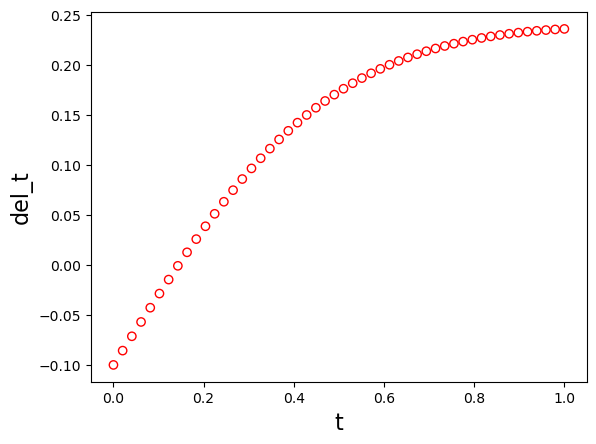

In [19]:
plt.figure()

plt.scatter(X,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
# plt.scatter(X,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)

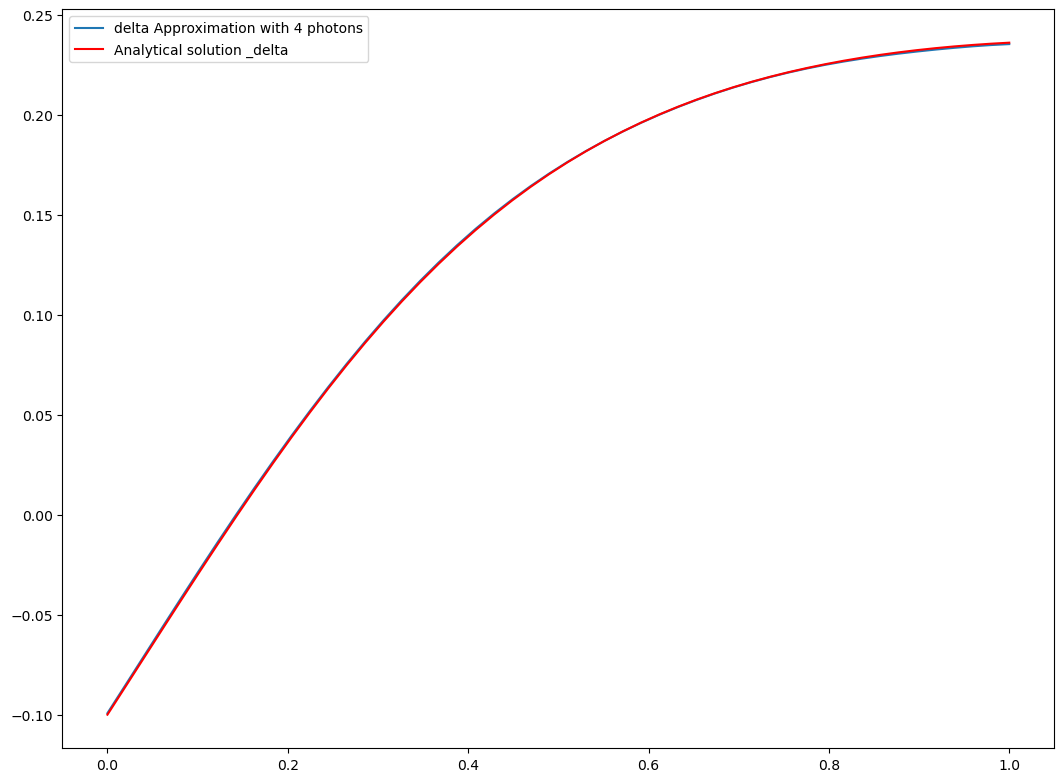

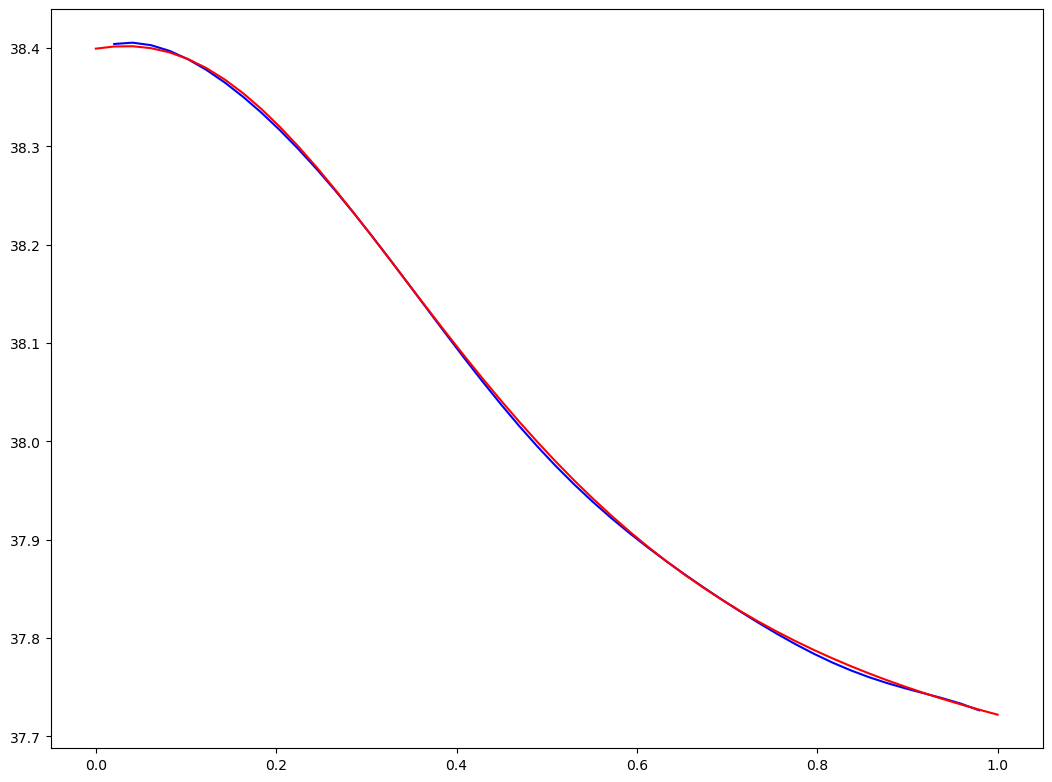

In [20]:
# X = np.linspace(range_min, range_max, 50)

# Change the plot size
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

# delta_pred = plot_solution(m, N, X, res.x, lambda_random,'delta')
delta_pred = plot_solution(m, N, X, best_param, lambda_random,'delta')

plt.plot(X, y_delta_real, 'r', label='Analytical solution _delta')
plt.legend()

plt.figure()

delta_pred = np.array(delta_pred)
delta_prime = (delta_pred[2:] - delta_pred[:-2])/(2*dx)
omega = delta_prime+ws


plt.plot(X[1:-1], omega, 'b', label='prediction solution _omega')
plt.plot(X, y_omega_real, 'r', label='Analytical solution _omega')
# plt.legend()


plt.show()

Text(0, 0.5, 'Loss function value')

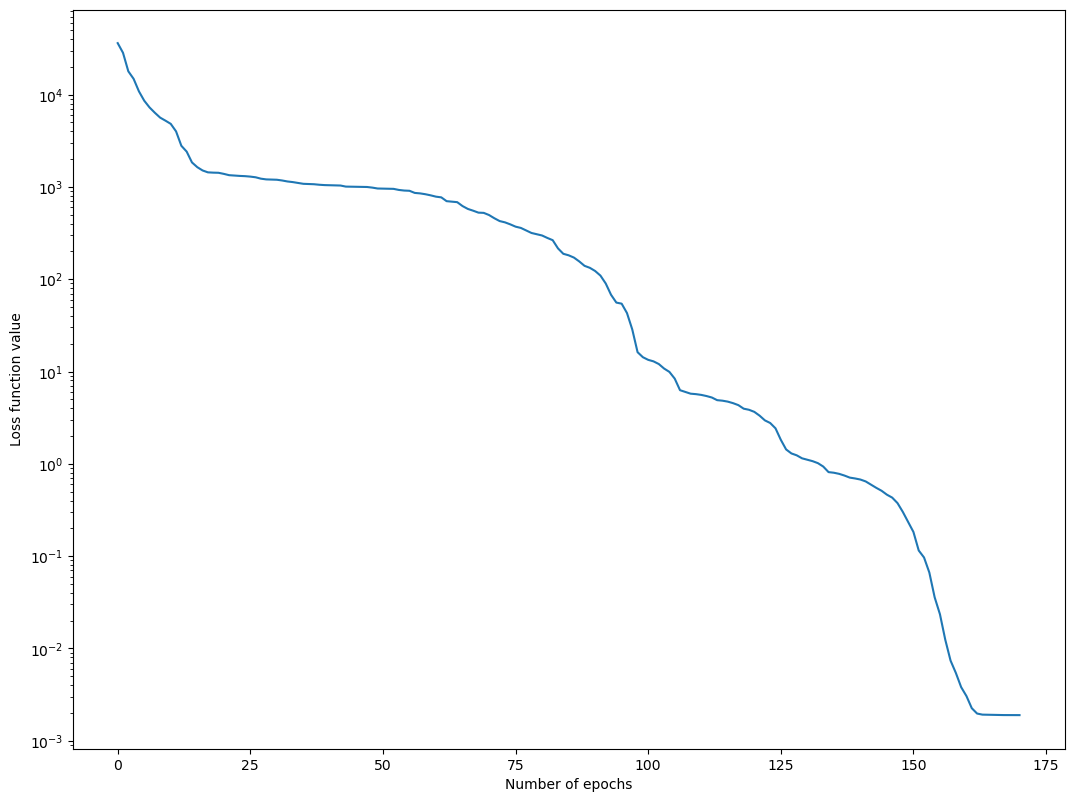

In [21]:

plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")